In [19]:
from astropy.time import Time
import astropy.units as u

import astromet

from random import randint
import matplotlib.pyplot as plt

import scanninglaw.times as times
from scanninglaw.source import Source
from scanninglaw.config import config

import numpy as np
from astropy import units as u

from pathlib import Path

mas = (1.0*u.mas).to(u.deg).value

In [20]:
### use Times New Roman font in Figures ####
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [21]:
def generate_random_digits(n: int):
    return int(''.join(["{}".format(randint(0, 9)) for num in range(0, n)]))

In [22]:
#create these directories if running for the first time

In [23]:
#change these directories if necessary
dir_current=Path().absolute()
game_dir = str(Path(dir_current).parents[0]) # one directory up
config['data_dir'] = game_dir+'/scanninglaw'
sing_source_dir = game_dir+'/sing_source/'
microlensing_dir = game_dir+'/microlensing/'
microlensing_only_dir = game_dir+'/microlensing_only/'
binary_dir = game_dir+'/binary/'
figure_dir = game_dir+'/Figures/'

#if running for the first time, you have to create these directories
#mkdir $game_dir/sing_source/
#mkdir $game_dir/microlensing/
#mkdir $game_dir/binary/
#mkdir $game_dir/Figures/

# Run the first time if you haven't downloaded the times yet
# times.fetch(version='dr3_nominal')

In [24]:
from typing import Dict
import pandas as pd
import numpy as np

def to_mock_lpc(
    source_id: float, mean_g_mag: float, ref_epoch: float,
    gaia_results: Dict[str, float],
    x_obs: np.array, x_obs_no_lensing: np.array,
    x_err: np.array, phi_obs: np.array,
    rac_obs: np.array, dec_obs: np.array,
    nmeasure: int = 9) -> pd.DataFrame:

    n_rows = x_obs.shape[0]

    random_transit_id = generate_random_digits(12)
    random_obmt = generate_random_digits(17)
    n_range = np.repeat(np.arange(int(n_rows/nmeasure)), nmeasure)

    mock_obmt_rev = np.repeat(np.linspace(1200, 9000, int(n_rows/nmeasure)), nmeasure)+\
        np.repeat(np.linspace(0., 0.01, nmeasure).reshape((-1, 1)), int(n_rows/nmeasure), axis=1).T.flatten()

    mock_fov = np.repeat(np.repeat(np.array([0, 1]), nmeasure).reshape((-1, 1)).T,
        int(n_rows/(2*nmeasure))+nmeasure, axis=0).flatten()[:n_rows]

    mock_strip = np.repeat(np.arange(0, 12).reshape((-1, 1)), int(n_rows/nmeasure), axis=1).T.flatten()[:n_rows]
    
    df: pd.DateFrame = pd.DataFrame(
        data = {
            'sourceId': np.repeat(source_id, n_rows),
            'transitId': random_transit_id+n_range,
            'obmt': random_obmt+np.arange(n_rows),
            'w': x_obs,
            'z': x_obs*10,
            'wError': x_err,
            'zError': x_err*10,
            'wDiff': x_obs-x_obs_no_lensing,
            'zDiff': (x_obs-x_obs_no_lensing)*10,
            'theta': phi_obs,
            'varpiFactorAl': np.repeat(0.5, n_rows),
            'varpiFactorAc': np.repeat(1., n_rows),
            'ra': np.repeat(gaia_results['ra_ref'], n_rows),
            'dec': np.repeat(gaia_results['dec_ref'], n_rows),
            'varpi': np.repeat(gaia_results['parallax'], n_rows),
            'varpiError': np.repeat(gaia_results['parallax_error'], n_rows),
            'pmra': np.repeat(gaia_results['pmrac'], n_rows),
            'pmraError': np.repeat(gaia_results['pmrac_error'], n_rows),
            'pmdec': np.repeat(gaia_results['pmdec'], n_rows),
            'pmdecError': np.repeat(gaia_results['pmdec_error'], n_rows),
            'refEpoch': np.repeat(ref_epoch, n_rows),
            'GMag': np.repeat(mean_g_mag, n_rows),
            'nuEff': np.repeat(0.1, n_rows),
            'excessNoise': np.repeat(gaia_results['excess_noise'], n_rows),
            'chi2Al': np.repeat(gaia_results['chi2'], n_rows),
            'chi2Ac': np.repeat(gaia_results['chi2'], n_rows)*10,
            'a': rac_obs,
            'd': dec_obs,
            'elapsedNanoSecs': ((t_obs-2010.)*u.year).to(u.nanosecond).value,
            'fov': mock_fov,
            'row': np.random.choice([4, 6], size=n_rows),
            'strip': mock_strip,
            'mu': np.repeat(0, n_rows),
            'gate': np.repeat(0, n_rows),
            'gclass': np.repeat(1, n_rows),
            'ccdProcFlags': np.repeat(0, n_rows),
            'transitProcFlags': np.repeat(0, n_rows),
            'alrate': np.repeat(np.random.normal(), n_rows),
            'acrate': np.repeat(np.random.normal()*1e-6, n_rows),
            'omega': np.linspace(-3, 3, n_rows),
            'obmt_rev': mock_obmt_rev,
            'subpixel': np.random.uniform(0, 1, size=n_rows)
        }
    )

    return df

# GAIA scanning law: Find points that are limited by a certain number of visits 

In [25]:
import astropy.units as units

rec_list_1d = np.linspace(0.0, 360.0, 500)
dec_list_1d = np.linspace(-90.0,90.0, 250)

rec_list, dec_list = np.meshgrid(rec_list_1d, dec_list_1d)
coords = Source(rec_list*units.deg, dec_list*units.deg, frame='icrs')
scl = times.Times(version='dr3_nominal')
scantimes = scl(coords)


Loading auxilliary data ...
t = 25.420 s
  auxilliary:  10.290 s
          sf:   7.721 s
interpolator:   7.409 s


Coordinates of max positions (RA,DEC): 6.492985971943888 -47.34939759036145
Coordinates of Nvisit=20 in DR3 positions (RA,DEC): 287.85571142284573 45.90361445783134
Coordinates of Nvisit=7 in DR3 (RA,DEC): 208.49699398797597 -43.01204819277108


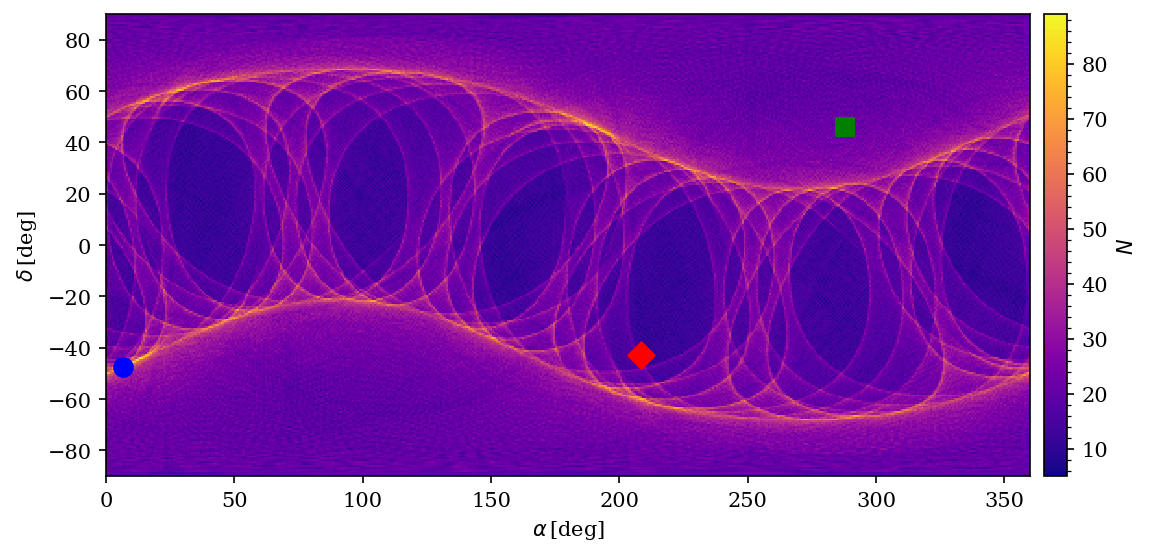

In [26]:
#create the figure in the ICRS frame
from numpy import unravel_index

fig = plt.figure(figsize=(12,4), dpi=150)

nscan=np.asarray(scantimes['counts'][0], dtype=float) # [0] is for FOV1, [1] is for FOV2: https://scanninglaw.readthedocs.io/en/latest/examples.html

#find regions of different number of GAIA visits
i_ra_max,i_dec_max = np.where(nscan==np.max(nscan))[1][0],np.where(nscan==np.max(nscan))[0][0]
i_ra_60,i_dec_60 = np.where(nscan==60)[1][0],np.where(nscan==60)[0][0]
i_ra_20,i_dec_20 = np.where(nscan==20)[1][5000],np.where(nscan==20)[0][5000]
i_ra_7,i_dec_7 = np.where(nscan==7)[1][0],np.where(nscan==7)[0][0]


pos_ra_max,pos_dec_max = rec_list_1d[i_ra_max], dec_list_1d[i_dec_max]
pos_ra_med,pos_dec_med = rec_list_1d[i_ra_60], dec_list_1d[i_dec_60]
pos_ra_min,pos_dec_min = rec_list_1d[i_ra_20], dec_list_1d[i_dec_20]

# new 
pos_ra_med,pos_dec_med = rec_list_1d[i_ra_20], dec_list_1d[i_dec_20] # Nv=91 in DR4
pos_ra_min,pos_dec_min = rec_list_1d[i_ra_7], dec_list_1d[i_dec_7] # Nv=69 in DR4


plt.xlabel(r'$\alpha\,$[deg]')
plt.ylabel(r'$\delta\,$[deg]')

im=plt.imshow(nscan,origin='lower',interpolation='nearest',cmap='plasma', aspect='equal',extent=[0,360,-90,90])
plt.scatter(pos_ra_max,pos_dec_max,c='blue',s=80)
plt.scatter(pos_ra_med,pos_dec_med,c='green',s=80,marker='s')
plt.scatter(pos_ra_min,pos_dec_min,c='red',s=80,marker='D')


cbar = fig.colorbar(im,pad=0.01)
cbar.minorticks_on()
cbar.set_label(r'$N$')

plt.savefig('map.png', bbox_inches='tight', dpi=150)
plt.savefig('map.pdf', bbox_inches='tight', dpi=150)

print('Coordinates of max positions (RA,DEC):',pos_ra_max,pos_dec_max)
print('Coordinates of Nvisit=20 in DR3 positions (RA,DEC):',pos_ra_med,pos_dec_med)
#print('Coordinates of Nvisit=20 (RA,DEC):',pos_ra_min,pos_dec_min)
print('Coordinates of Nvisit=7 in DR3 (RA,DEC):',pos_ra_min,pos_dec_min)

# Choose position, magnitude and DR

In [39]:
choose_DR='DR4' # DR3, DR4, DR5
choose_position = 'max' # max, med, min
mean_g_mag = 14 # change here 
Nsource=500 # number of events

if choose_position=='max':
    RA, DEC= pos_ra_max,pos_dec_max
elif choose_position=='med':
    RA, DEC= pos_ra_med,pos_dec_med
elif choose_position=='min':
    RA, DEC= pos_ra_min,pos_dec_min
 
if choose_DR=='DR3':
    REFERENCE_EPOCH: float = 2016.
elif choose_DR=='DR4':
    REFERENCE_EPOCH: float = 2017.5
elif choose_DR=='DR5':
    REFERENCE_EPOCH: float = 2019.5 

# Convert DR format from GOST

In [40]:
from datetime import datetime, timedelta

def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    # Calculate the start of the year
    start_of_year = datetime(year, 1, 1)
    
    # Calculate the number of days in the year
    if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
        days_in_year = 366
    else:
        days_in_year = 365
    
    # Calculate the fractional part of the year in days
    fractional_days = (decimal_year - year) * days_in_year
    
    # Calculate the final date by adding the fractional days to the start of the year
    final_date = start_of_year + timedelta(days=fractional_days)
    
    return final_date.year, final_date.month, final_date.day

position: 6.492985971943888 -47.34939759036145
DR3 start: July 28 2014, DR3 end: April 7 2017
DR4 start: April 8 2017, DR4 end: December 31 2019
DR5 start: January 1 20202, DR5 end: December 31 2024
DR start: 2014.686752863009
DR end: 2019.9756326015734
number of observations GOST: 281


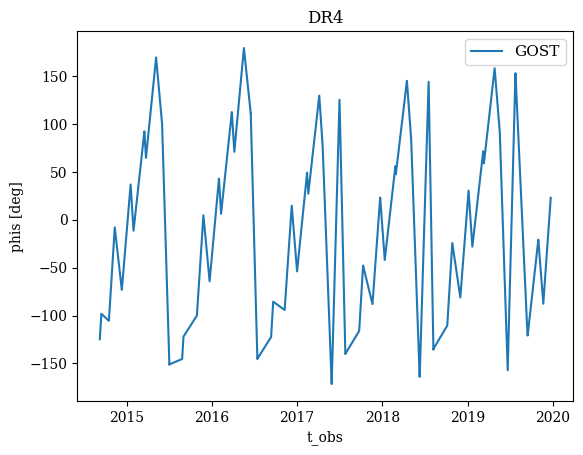

In [41]:
#### check for DR3 ####
print('position:',RA,DEC)

print('DR3 start: July 28 2014, DR3 end: April 7 2017')
print('DR4 start: April 8 2017, DR4 end: December 31 2019')
print('DR5 start: January 1 20202, DR5 end: December 31 2024')
if choose_DR=='DR3':
    if choose_position=='max':
        df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR3_RA=6_49_DEC=-47_3.csv', delimiter=',')
elif choose_DR=='DR4':
    if choose_position=='max':
        df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR4_RA=6_49_DEC=-47_3.csv', delimiter=',')
    elif choose_position=='med':
        # df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR4_RA=277_8_DEC=-68_3.csv', delimiter=',') # old: Nv=200 in DR4
        df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR4_RA=287_9_DEC=45_9.csv', delimiter=',') # Nv=91 in DR4
    elif choose_position=='min':
        #df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR4_RA=287_9_DEC=45_9.csv', delimiter=',') # old: Nv=91 in DR4
        df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR4_RA=208_50_DEC=-43_01.csv', delimiter=',') # new: Nv=69 in DR4

elif choose_DR=='DR5':
    if choose_position=='max':
        df_sl = pd.read_csv(game_dir+'/Data/GOST/gost_DR5_RA=6_49_DEC=-47_3.csv', delimiter=',')

# Strip any leading or trailing spaces from column names
df_sl.columns = df_sl.columns.str.strip()
ts_gost = df_sl['ObservationTimeAtBarycentre[BarycentricJulianDateInTCB]']
phis_gost = df_sl['scanAngle[rad]']
ts_gost_list = ts_gost.tolist()
phis_gost_list = phis_gost.tolist()

# Convert the list of timestamps to decimal years
ts_gost = Time(ts_gost_list, format='jd').decimalyear

#Convert phis
phis_gost = np.asarray(phis_gost_list)*180/np.pi

print('DR start:',ts_gost[0])
print('DR end:',ts_gost[-1])
plt.plot(ts_gost,phis_gost,linestyle='solid',linewidth=1.5,label='GOST')

plt.xlabel('t_obs')
plt.ylabel('phis [deg]')
plt.legend(fontsize=11)
if choose_DR=='DR3':
    plt.title('DR3')
elif choose_DR=='DR4':
    plt.title('DR4')
elif choose_DR=='DR5':
    plt.title('DR5')
ts, phis= ts_gost,phis_gost
print('number of observations GOST:',len(phis))

# Generating mock data for the case of microlensing

In [42]:
cd $microlensing_only_dir

/d7/CAC/tj0014/Projects/GAME/Taj_GAME/microlensing_only


/d7/CAC/tj0014/anaconda3/envs/GAME_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [43]:
#MICROLENSING
ra, dec, pmra, pmdec, parallax, UWE = [], [], [], [], [], []
u_0, theta_E, t_0, t_E, pi_EN, pi_EE = [], [], [], [], [], []

ra_fit,dec_fit,ra_fit_nol,dec_fit_nol=[],[],[],[]
pmra_fit, pmdec_fit, parallax_fit,pmra_fit_err, pmdec_fit_err, parallax_fit_err = [], [], [],[], [], []

for i in range(Nsource):
  pmd = np.random.uniform(-40, 40)
  pma = np.random.uniform(-40, 40)
  pi = np.random.uniform(1e-5, 2) # not from 0 because distance is 1/pi
  ra.append(RA)
  dec.append(DEC)
  pmra.append(pma)
  pmdec.append(pmd)
  parallax.append(pi)

  SOURCE_ID: int = generate_random_digits(19) # why is this necessary?

  piEN=np.random.uniform(-1, 1)
  piEE=np.random.uniform(-1, 1)
  u0=np.random.uniform(-5, 5) #change here
    
  tE=np.random.uniform(0.1, 730) # from 0-2year    
  t0=np.random.uniform(Time(np.min(ts), format='decimalyear').jd -2450000,Time(np.max(ts), format='decimalyear').jd -2450000) # entire DR 
  #t0=np.random.uniform(5197.5, 10310.5) # from 2010- 2024
  thetaE = np.random.uniform(0.1, 10)

    
  params = astromet.params()
  params.epoch=REFERENCE_EPOCH
  params = astromet.define_lens(params, RA, DEC,
                              u0=u0,
                              t0=t0,
                              tE=tE,
                              piEN=piEN,
                              piEE=piEE,
                              m0=mean_g_mag,
                              fbl=1,
                              pmrac_source=pmra[i],
                              pmdec_source=pmdec[i],
                              d_source=1/parallax[i],
                              thetaE=thetaE)
  #no lensing


  ldracs, lddecs, mag_diff = astromet.track(ts, params)
  nmeasure=9
  magnitude_measurements = np.repeat(mag_diff, nmeasure)+mean_g_mag
  ast_err = astromet.sigma_ast(magnitude_measurements)

  t_obs,x_obs,phi_obs,rac_obs,dec_obs = astromet.mock_obs(ts, phis, ldracs, lddecs, err=ast_err, nmeasure=nmeasure) 

  #no_noise: Not possible to set noise=0. UWE is calculated as reqsults['uwe']= np.sqrt(np.sum(R**2 / xerr**2)/(np.sum(weights>0.2)-nparam)) which gives nan if ast_err=0.

  # fit 5p fit and generate xobs
  results = astromet.fit(t_obs, x_obs, phi_obs, ast_err, RA, DEC)

  params_nol = astromet.params()
  params_nol.epoch=REFERENCE_EPOCH
  params_nol.ra = results['ra_ref']
  params_nol.dec = results['dec_ref']
  params_nol.pmrac = results['pmrac']
  params_nol.pmdec = results['pmdec']
  params_nol.parallax = results['parallax']
    
  ldracs_nol, lddecs_nol = astromet.track(ts, params_nol)
  ast_err_nol = astromet.sigma_ast(mean_g_mag)
  t_obs_nol, x_obs_nol, phi_obs_nol, rac_obs_nol, dec_obs_nol = astromet.mock_obs(ts, phis, ldracs_nol, lddecs_nol, err=ast_err_nol, nmeasure=nmeasure)

  mock_lpc = to_mock_lpc(
    SOURCE_ID,
    mean_g_mag,
    REFERENCE_EPOCH,
    results,
    x_obs, x_obs_nol,
    ast_err,
    phi_obs,
    rac_obs, dec_obs)
    
  u_0.append(u0)
  t_E.append(tE)
  pi_EN.append(piEN)
  pi_EE.append(piEE)
  theta_E.append(thetaE)
  mock_lpc.to_parquet("mock_lpc_" + str(i+1) + ".parquet")
  UWE.append(results['uwe'])
  t_0.append(t0)
  ra_fit.append(results['ra_ref'])
  dec_fit.append(results['dec_ref'])
  pmra_fit.append(results['pmrac'])
  pmdec_fit.append(results['pmdec'])
  parallax_fit.append(results['parallax'])

UWE_microlensing=UWE

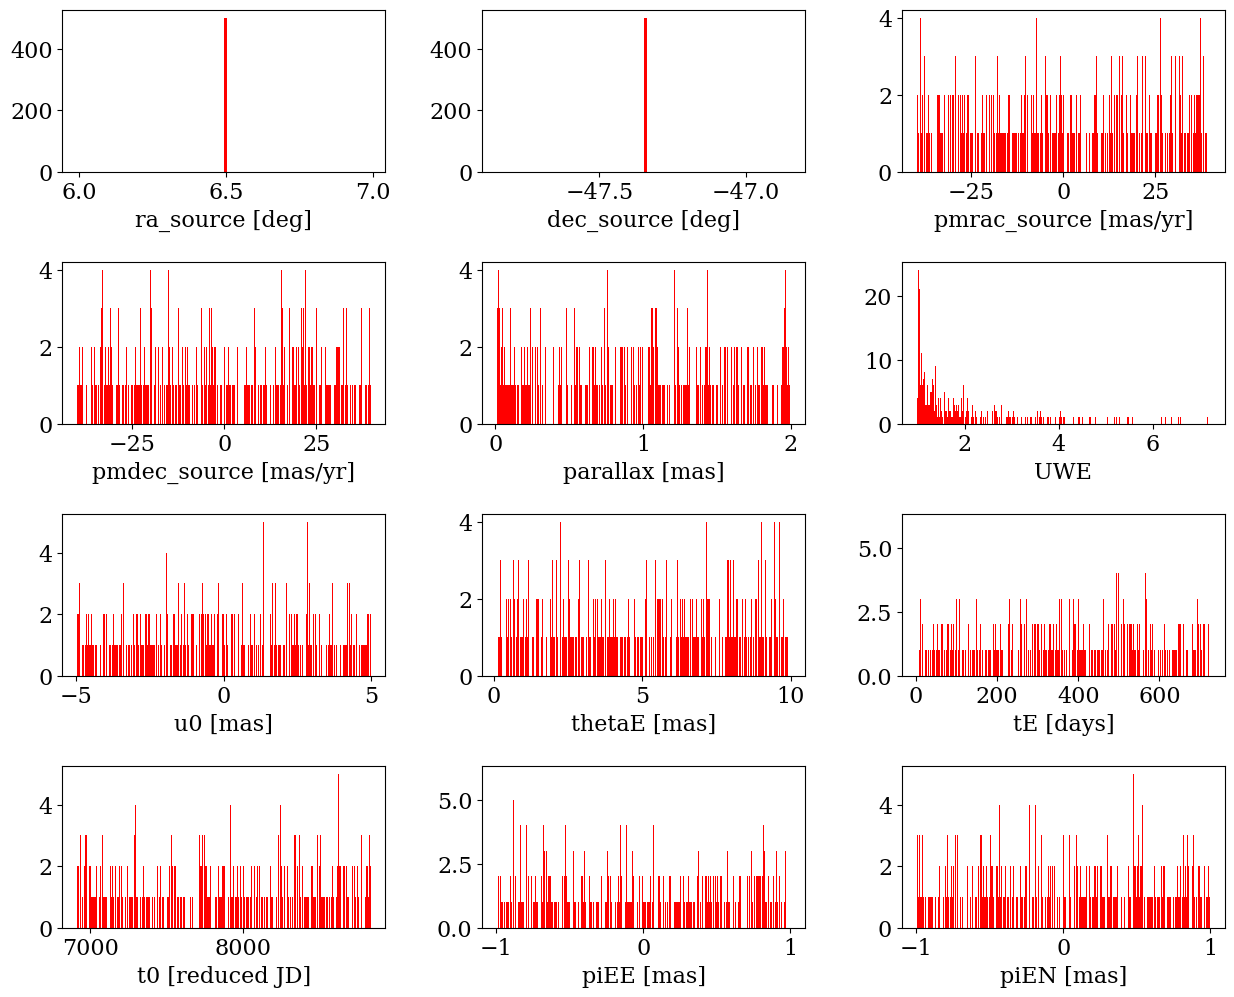

In [44]:
fig, axs = plt.subplots(4, 3, figsize=(15, 12), subplot_kw=dict(box_aspect=0.5))
font_size=16

axs[0, 0].hist(ra,bins=100,color='red')
axs[0, 0].set_xlabel('ra_source [deg]', fontsize=font_size)
axs[0, 0].tick_params(labelsize=font_size)
axs[0, 1].hist(dec,bins=100,color='red')
axs[0, 1].set_xlabel('dec_source [deg]', fontsize=font_size)
axs[0, 1].tick_params(labelsize=font_size)
axs[0, 2].hist(pmra,bins=500,color='red')
axs[0, 2].set_xlabel('pmrac_source [mas/yr]', fontsize=font_size)
axs[0, 2].tick_params(labelsize=font_size)
axs[1, 0].hist(pmdec,bins=500,color='red')
axs[1, 0].set_xlabel('pmdec_source [mas/yr]', fontsize=font_size)
axs[1, 0].tick_params(labelsize=font_size)
axs[1, 1].hist(parallax,bins=500,color='red')
axs[1, 1].set_xlabel('parallax [mas]', fontsize=font_size)
axs[1, 1].tick_params(labelsize=font_size)
axs[1, 2].hist(UWE,bins=500,color='red')
axs[1, 2].set_xlabel('UWE', fontsize=font_size)
axs[1, 2].tick_params(labelsize=font_size)
axs[2, 0].hist(u_0,bins=500,color='red')
axs[2, 0].set_xlabel('u0 [mas]', fontsize=font_size)
axs[2, 0].tick_params(labelsize=font_size)
axs[2, 1].hist(theta_E,bins=500,color='red')
axs[2, 1].set_xlabel('thetaE [mas]', fontsize=font_size)
axs[2, 1].tick_params(labelsize=font_size)
axs[2, 2].hist(t_E,bins=500,color='red')
axs[2, 2].set_xlabel('tE [days]', fontsize=font_size)
axs[2, 2].tick_params(labelsize=font_size)
axs[3, 0].hist(t_0,bins=500,color='red')
axs[3, 0].set_xlabel('t0 [reduced JD]', fontsize=font_size)
axs[3, 0].tick_params(labelsize=font_size)
axs[3, 1].hist(pi_EE,bins=500,color='red')
axs[3, 1].set_xlabel('piEE [mas]', fontsize=font_size)
axs[3, 1].tick_params(labelsize=font_size)
axs[3, 2].hist(pi_EN,bins=500,color='red')
axs[3, 2].set_xlabel('piEN [mas]', fontsize=font_size)
axs[3, 2].tick_params(labelsize=font_size)
#for ax in axs.flat:
#    ax.set(xlabel='x-label', ylabel='y-label')
fig.subplots_adjust(hspace=0.5) #adjust vertical space
fig.subplots_adjust(wspace=0.3) #adjust width

#fig.suptitle("Microlensing", fontsize=18, y=0.92)
fig.savefig(figure_dir + 'histogram_microlensing.png', dpi=150, bbox_inches='tight')

In [45]:
n_rows = len(u_0)
d = {'u_0': u_0,
     'theta_E': theta_E,
     't_E': t_E,
     't_0': t_0,
     'pi_EE': pi_EE,
     'pi_EN': pi_EN}
microlensing_params = pd.DataFrame(data = d, index = np.arange(1, Nsource+1))

In [46]:
microlensing_params.to_csv('microlensing_params.csv', index=False)

In [47]:
d = {'ra': ra,
  'dec': dec,
 'pmra': pmra,
 'pmdec': pmdec,
 'parallax': parallax,
 'UWE': UWE}
params = pd.DataFrame(data = d, index = np.arange(1,Nsource+1))
params.to_csv('params.csv', index=False)

In [48]:
# Fitted values
d_fit = {'ra': ra_fit,
  'dec': dec_fit,
 'pmra': pmra_fit,
 'pmdec': pmdec_fit,
 'parallax': parallax_fit,
 'UWE': UWE}
params_fit = pd.DataFrame(data = d_fit, index = np.arange(1,Nsource+1))
params_fit.to_csv('params_fit.csv', index=False)


In [49]:
! zip -r $game_dir/microlensing_only.zip *

updating: map.pdf (deflated 5%)
updating: map.png (deflated 2%)
updating: microlensing_params.csv (deflated 49%)
updating: mock_lpc_1.parquet (deflated 36%)
updating: mock_lpc_2.parquet (deflated 36%)
updating: mock_lpc_3.parquet (deflated 36%)
updating: mock_lpc_4.parquet (deflated 36%)
updating: mock_lpc_5.parquet (deflated 36%)
updating: params.csv (deflated 64%)
updating: params_fit.csv (deflated 64%)
  adding: mock_lpc_100.parquet (deflated 36%)
  adding: mock_lpc_101.parquet (deflated 36%)
  adding: mock_lpc_102.parquet (deflated 36%)
  adding: mock_lpc_103.parquet (deflated 36%)
  adding: mock_lpc_104.parquet (deflated 36%)
  adding: mock_lpc_105.parquet (deflated 36%)
  adding: mock_lpc_106.parquet (deflated 35%)
  adding: mock_lpc_107.parquet (deflated 36%)
  adding: mock_lpc_108.parquet (deflated 36%)
  adding: mock_lpc_109.parquet (deflated 36%)
  adding: mock_lpc_10.parquet (deflated 36%)
  adding: mock_lpc_110.parquet (deflated 36%)
  adding: mock_lpc_111.parquet (deflated

  adding: mock_lpc_11106.parquet (deflated 35%)
  adding: mock_lpc_11107.parquet (deflated 35%)
  adding: mock_lpc_11108.parquet (deflated 35%)
  adding: mock_lpc_11109.parquet (deflated 35%)
  adding: mock_lpc_1110.parquet (deflated 35%)
  adding: mock_lpc_11110.parquet (deflated 35%)
  adding: mock_lpc_11111.parquet (deflated 35%)
  adding: mock_lpc_11112.parquet (deflated 35%)
  adding: mock_lpc_11113.parquet (deflated 35%)
  adding: mock_lpc_11114.parquet (deflated 35%)
  adding: mock_lpc_11115.parquet (deflated 35%)
  adding: mock_lpc_11116.parquet (deflated 35%)
  adding: mock_lpc_11117.parquet (deflated 35%)
  adding: mock_lpc_11118.parquet (deflated 35%)
  adding: mock_lpc_11119.parquet (deflated 35%)
  adding: mock_lpc_1111.parquet (deflated 35%)
  adding: mock_lpc_11120.parquet (deflated 35%)
  adding: mock_lpc_11121.parquet (deflated 35%)
  adding: mock_lpc_11122.parquet (deflated 35%)
  adding: mock_lpc_11123.parquet (deflated 35%)
  adding: mock_lpc_11124.parquet (deflated

  adding: mock_lpc_11265.parquet (deflated 35%)
  adding: mock_lpc_11266.parquet (deflated 35%)
  adding: mock_lpc_11267.parquet (deflated 35%)
  adding: mock_lpc_11268.parquet (deflated 35%)
  adding: mock_lpc_11269.parquet (deflated 35%)
  adding: mock_lpc_1126.parquet (deflated 35%)
  adding: mock_lpc_11270.parquet (deflated 35%)
  adding: mock_lpc_11271.parquet (deflated 35%)
  adding: mock_lpc_11272.parquet (deflated 35%)
  adding: mock_lpc_11273.parquet (deflated 35%)
  adding: mock_lpc_11274.parquet (deflated 35%)
  adding: mock_lpc_11275.parquet (deflated 35%)
  adding: mock_lpc_11276.parquet (deflated 35%)
  adding: mock_lpc_11277.parquet (deflated 35%)
  adding: mock_lpc_11278.parquet (deflated 35%)
  adding: mock_lpc_11279.parquet (deflated 35%)
  adding: mock_lpc_1127.parquet (deflated 35%)
  adding: mock_lpc_11280.parquet (deflated 35%)
  adding: mock_lpc_11281.parquet (deflated 35%)
  adding: mock_lpc_11282.parquet (deflated 35%)
  adding: mock_lpc_11283.parquet (deflated

  adding: mock_lpc_11423.parquet (deflated 35%)
  adding: mock_lpc_11424.parquet (deflated 35%)
  adding: mock_lpc_11425.parquet (deflated 35%)
  adding: mock_lpc_11426.parquet (deflated 35%)
  adding: mock_lpc_11427.parquet (deflated 35%)
  adding: mock_lpc_11428.parquet (deflated 35%)
  adding: mock_lpc_11429.parquet (deflated 35%)
  adding: mock_lpc_1142.parquet (deflated 35%)
  adding: mock_lpc_11430.parquet (deflated 35%)
  adding: mock_lpc_11431.parquet (deflated 35%)
  adding: mock_lpc_11432.parquet (deflated 35%)
  adding: mock_lpc_11433.parquet (deflated 35%)
  adding: mock_lpc_11434.parquet (deflated 35%)
  adding: mock_lpc_11435.parquet (deflated 35%)
  adding: mock_lpc_11436.parquet (deflated 35%)
  adding: mock_lpc_11437.parquet (deflated 35%)
  adding: mock_lpc_11438.parquet (deflated 35%)
  adding: mock_lpc_11439.parquet (deflated 35%)
  adding: mock_lpc_1143.parquet (deflated 35%)
  adding: mock_lpc_11440.parquet (deflated 35%)
  adding: mock_lpc_11441.parquet (deflated

  adding: mock_lpc_11584.parquet (deflated 35%)
  adding: mock_lpc_11585.parquet (deflated 35%)
  adding: mock_lpc_11586.parquet (deflated 35%)
  adding: mock_lpc_11587.parquet (deflated 35%)
  adding: mock_lpc_11588.parquet (deflated 35%)
  adding: mock_lpc_11589.parquet (deflated 35%)
  adding: mock_lpc_1158.parquet (deflated 35%)
  adding: mock_lpc_11590.parquet (deflated 35%)
  adding: mock_lpc_11591.parquet (deflated 35%)
  adding: mock_lpc_11592.parquet (deflated 35%)
  adding: mock_lpc_11593.parquet (deflated 35%)
  adding: mock_lpc_11594.parquet (deflated 35%)
  adding: mock_lpc_11595.parquet (deflated 35%)
  adding: mock_lpc_11596.parquet (deflated 35%)
  adding: mock_lpc_11597.parquet (deflated 35%)
  adding: mock_lpc_11598.parquet (deflated 35%)
  adding: mock_lpc_11599.parquet (deflated 35%)
  adding: mock_lpc_1159.parquet (deflated 35%)
  adding: mock_lpc_115.parquet (deflated 35%)
  adding: mock_lpc_11600.parquet (deflated 35%)
  adding: mock_lpc_11601.parquet (deflated 3

  adding: mock_lpc_11744.parquet (deflated 35%)
  adding: mock_lpc_11745.parquet (deflated 35%)
  adding: mock_lpc_11746.parquet (deflated 35%)
  adding: mock_lpc_11747.parquet (deflated 35%)
  adding: mock_lpc_11748.parquet (deflated 35%)
  adding: mock_lpc_11749.parquet (deflated 35%)
  adding: mock_lpc_1174.parquet (deflated 35%)
  adding: mock_lpc_11750.parquet (deflated 35%)
  adding: mock_lpc_11751.parquet (deflated 35%)
  adding: mock_lpc_11752.parquet (deflated 35%)
  adding: mock_lpc_11753.parquet (deflated 35%)
  adding: mock_lpc_11754.parquet (deflated 35%)
  adding: mock_lpc_11755.parquet (deflated 35%)
  adding: mock_lpc_11756.parquet (deflated 35%)
  adding: mock_lpc_11757.parquet (deflated 35%)
  adding: mock_lpc_11758.parquet (deflated 35%)
  adding: mock_lpc_11759.parquet (deflated 35%)
  adding: mock_lpc_1175.parquet (deflated 35%)
  adding: mock_lpc_11760.parquet (deflated 35%)
  adding: mock_lpc_11761.parquet (deflated 35%)
  adding: mock_lpc_11762.parquet (deflated

  adding: mock_lpc_11904.parquet (deflated 35%)
  adding: mock_lpc_11905.parquet (deflated 35%)
  adding: mock_lpc_11906.parquet (deflated 35%)
  adding: mock_lpc_11907.parquet (deflated 35%)
  adding: mock_lpc_11908.parquet (deflated 35%)
  adding: mock_lpc_11909.parquet (deflated 35%)
  adding: mock_lpc_1190.parquet (deflated 35%)
  adding: mock_lpc_11910.parquet (deflated 35%)
  adding: mock_lpc_11911.parquet (deflated 35%)
  adding: mock_lpc_11912.parquet (deflated 35%)
  adding: mock_lpc_11913.parquet (deflated 35%)
  adding: mock_lpc_11914.parquet (deflated 35%)
  adding: mock_lpc_11915.parquet (deflated 35%)
  adding: mock_lpc_11916.parquet (deflated 35%)
  adding: mock_lpc_11917.parquet (deflated 35%)
  adding: mock_lpc_11918.parquet (deflated 35%)
  adding: mock_lpc_11919.parquet (deflated 35%)
  adding: mock_lpc_1191.parquet (deflated 35%)
  adding: mock_lpc_11920.parquet (deflated 35%)
  adding: mock_lpc_11921.parquet (deflated 35%)
  adding: mock_lpc_11922.parquet (deflated

  adding: mock_lpc_12063.parquet (deflated 35%)
  adding: mock_lpc_12064.parquet (deflated 35%)
  adding: mock_lpc_12065.parquet (deflated 35%)
  adding: mock_lpc_12066.parquet (deflated 35%)
  adding: mock_lpc_12067.parquet (deflated 35%)
  adding: mock_lpc_12068.parquet (deflated 35%)
  adding: mock_lpc_12069.parquet (deflated 35%)
  adding: mock_lpc_1206.parquet (deflated 35%)
  adding: mock_lpc_12070.parquet (deflated 35%)
  adding: mock_lpc_12071.parquet (deflated 35%)
  adding: mock_lpc_12072.parquet (deflated 35%)
  adding: mock_lpc_12073.parquet (deflated 35%)
  adding: mock_lpc_12074.parquet (deflated 35%)
  adding: mock_lpc_12075.parquet (deflated 35%)
  adding: mock_lpc_12076.parquet (deflated 35%)
  adding: mock_lpc_12077.parquet (deflated 35%)
  adding: mock_lpc_12078.parquet (deflated 35%)
  adding: mock_lpc_12079.parquet (deflated 35%)
  adding: mock_lpc_1207.parquet (deflated 35%)
  adding: mock_lpc_12080.parquet (deflated 35%)
  adding: mock_lpc_12081.parquet (deflated

  adding: mock_lpc_12223.parquet (deflated 35%)
  adding: mock_lpc_12224.parquet (deflated 35%)
  adding: mock_lpc_12225.parquet (deflated 35%)
  adding: mock_lpc_12226.parquet (deflated 35%)
  adding: mock_lpc_12227.parquet (deflated 35%)
  adding: mock_lpc_12228.parquet (deflated 35%)
  adding: mock_lpc_12229.parquet (deflated 35%)
  adding: mock_lpc_1222.parquet (deflated 35%)
  adding: mock_lpc_12230.parquet (deflated 35%)
  adding: mock_lpc_12231.parquet (deflated 35%)
  adding: mock_lpc_12232.parquet (deflated 35%)
  adding: mock_lpc_12233.parquet (deflated 35%)
  adding: mock_lpc_12234.parquet (deflated 35%)
  adding: mock_lpc_12235.parquet (deflated 35%)
  adding: mock_lpc_12236.parquet (deflated 35%)
  adding: mock_lpc_12237.parquet (deflated 35%)
  adding: mock_lpc_12238.parquet (deflated 35%)
  adding: mock_lpc_12239.parquet (deflated 35%)
  adding: mock_lpc_1223.parquet (deflated 35%)
  adding: mock_lpc_12240.parquet (deflated 35%)
  adding: mock_lpc_12241.parquet (deflated

  adding: mock_lpc_12384.parquet (deflated 35%)
  adding: mock_lpc_12385.parquet (deflated 35%)
  adding: mock_lpc_12386.parquet (deflated 35%)
  adding: mock_lpc_12387.parquet (deflated 35%)
  adding: mock_lpc_12388.parquet (deflated 35%)
  adding: mock_lpc_12389.parquet (deflated 35%)
  adding: mock_lpc_1238.parquet (deflated 35%)
  adding: mock_lpc_12390.parquet (deflated 35%)
  adding: mock_lpc_12391.parquet (deflated 35%)
  adding: mock_lpc_12392.parquet (deflated 35%)
  adding: mock_lpc_12393.parquet (deflated 35%)
  adding: mock_lpc_12394.parquet (deflated 35%)
  adding: mock_lpc_12395.parquet (deflated 35%)
  adding: mock_lpc_12396.parquet (deflated 35%)
  adding: mock_lpc_12397.parquet (deflated 35%)
  adding: mock_lpc_12398.parquet (deflated 35%)
  adding: mock_lpc_12399.parquet (deflated 35%)
  adding: mock_lpc_1239.parquet (deflated 35%)
  adding: mock_lpc_123.parquet (deflated 35%)
  adding: mock_lpc_12400.parquet (deflated 35%)
  adding: mock_lpc_12401.parquet (deflated 3

  adding: mock_lpc_12543.parquet (deflated 35%)
  adding: mock_lpc_12544.parquet (deflated 35%)
  adding: mock_lpc_12545.parquet (deflated 35%)
  adding: mock_lpc_12546.parquet (deflated 35%)
  adding: mock_lpc_12547.parquet (deflated 35%)
  adding: mock_lpc_12548.parquet (deflated 35%)
  adding: mock_lpc_12549.parquet (deflated 35%)
  adding: mock_lpc_1254.parquet (deflated 35%)
  adding: mock_lpc_12550.parquet (deflated 35%)
  adding: mock_lpc_12551.parquet (deflated 35%)
  adding: mock_lpc_12552.parquet (deflated 35%)
  adding: mock_lpc_12553.parquet (deflated 35%)
  adding: mock_lpc_12554.parquet (deflated 35%)
  adding: mock_lpc_12555.parquet (deflated 35%)
  adding: mock_lpc_12556.parquet (deflated 35%)
  adding: mock_lpc_12557.parquet (deflated 35%)
  adding: mock_lpc_12558.parquet (deflated 35%)
  adding: mock_lpc_12559.parquet (deflated 35%)
  adding: mock_lpc_1255.parquet (deflated 35%)
  adding: mock_lpc_12560.parquet (deflated 35%)
  adding: mock_lpc_12561.parquet (deflated

  adding: mock_lpc_12703.parquet (deflated 35%)
  adding: mock_lpc_12704.parquet (deflated 35%)
  adding: mock_lpc_12705.parquet (deflated 35%)
  adding: mock_lpc_12706.parquet (deflated 35%)
  adding: mock_lpc_12707.parquet (deflated 35%)
  adding: mock_lpc_12708.parquet (deflated 35%)
  adding: mock_lpc_12709.parquet (deflated 35%)
  adding: mock_lpc_1270.parquet (deflated 35%)
  adding: mock_lpc_12710.parquet (deflated 35%)
  adding: mock_lpc_12711.parquet (deflated 35%)
  adding: mock_lpc_12712.parquet (deflated 35%)
  adding: mock_lpc_12713.parquet (deflated 35%)
  adding: mock_lpc_12714.parquet (deflated 35%)
  adding: mock_lpc_12715.parquet (deflated 35%)
  adding: mock_lpc_12716.parquet (deflated 35%)
  adding: mock_lpc_12717.parquet (deflated 35%)
  adding: mock_lpc_12718.parquet (deflated 35%)
  adding: mock_lpc_12719.parquet (deflated 35%)
  adding: mock_lpc_1271.parquet (deflated 35%)
  adding: mock_lpc_12720.parquet (deflated 35%)
  adding: mock_lpc_12721.parquet (deflated

  adding: mock_lpc_12863.parquet (deflated 35%)
  adding: mock_lpc_12864.parquet (deflated 35%)
  adding: mock_lpc_12865.parquet (deflated 35%)
  adding: mock_lpc_12866.parquet (deflated 35%)
  adding: mock_lpc_12867.parquet (deflated 35%)
  adding: mock_lpc_12868.parquet (deflated 35%)
  adding: mock_lpc_12869.parquet (deflated 35%)
  adding: mock_lpc_1286.parquet (deflated 35%)
  adding: mock_lpc_12870.parquet (deflated 35%)
  adding: mock_lpc_12871.parquet (deflated 35%)
  adding: mock_lpc_12872.parquet (deflated 35%)
  adding: mock_lpc_12873.parquet (deflated 35%)
  adding: mock_lpc_12874.parquet (deflated 35%)
  adding: mock_lpc_12875.parquet (deflated 35%)
  adding: mock_lpc_12876.parquet (deflated 35%)
  adding: mock_lpc_12877.parquet (deflated 35%)
  adding: mock_lpc_12878.parquet (deflated 35%)
  adding: mock_lpc_12879.parquet (deflated 35%)
  adding: mock_lpc_1287.parquet (deflated 35%)
  adding: mock_lpc_12880.parquet (deflated 35%)
  adding: mock_lpc_12881.parquet (deflated

  adding: mock_lpc_13022.parquet (deflated 35%)
  adding: mock_lpc_13023.parquet (deflated 35%)
  adding: mock_lpc_13024.parquet (deflated 35%)
  adding: mock_lpc_13025.parquet (deflated 35%)
  adding: mock_lpc_13026.parquet (deflated 35%)
  adding: mock_lpc_13027.parquet (deflated 35%)
  adding: mock_lpc_13028.parquet (deflated 35%)
  adding: mock_lpc_13029.parquet (deflated 35%)
  adding: mock_lpc_1302.parquet (deflated 35%)
  adding: mock_lpc_13030.parquet (deflated 35%)
  adding: mock_lpc_13031.parquet (deflated 35%)
  adding: mock_lpc_13032.parquet (deflated 35%)
  adding: mock_lpc_13033.parquet (deflated 35%)
  adding: mock_lpc_13034.parquet (deflated 35%)
  adding: mock_lpc_13035.parquet (deflated 35%)
  adding: mock_lpc_13036.parquet (deflated 35%)
  adding: mock_lpc_13037.parquet (deflated 35%)
  adding: mock_lpc_13038.parquet (deflated 35%)
  adding: mock_lpc_13039.parquet (deflated 35%)
  adding: mock_lpc_1303.parquet (deflated 35%)
  adding: mock_lpc_13040.parquet (deflated

  adding: mock_lpc_13182.parquet (deflated 35%)
  adding: mock_lpc_13183.parquet (deflated 35%)
  adding: mock_lpc_13184.parquet (deflated 35%)
  adding: mock_lpc_13185.parquet (deflated 35%)
  adding: mock_lpc_13186.parquet (deflated 35%)
  adding: mock_lpc_13187.parquet (deflated 35%)
  adding: mock_lpc_13188.parquet (deflated 35%)
  adding: mock_lpc_13189.parquet (deflated 35%)
  adding: mock_lpc_1318.parquet (deflated 35%)
  adding: mock_lpc_13190.parquet (deflated 35%)
  adding: mock_lpc_13191.parquet (deflated 35%)
  adding: mock_lpc_13192.parquet (deflated 35%)
  adding: mock_lpc_13193.parquet (deflated 35%)
  adding: mock_lpc_13194.parquet (deflated 35%)
  adding: mock_lpc_13195.parquet (deflated 35%)
  adding: mock_lpc_13196.parquet (deflated 35%)
  adding: mock_lpc_13197.parquet (deflated 35%)
  adding: mock_lpc_13198.parquet (deflated 35%)
  adding: mock_lpc_13199.parquet (deflated 35%)
  adding: mock_lpc_1319.parquet (deflated 35%)
  adding: mock_lpc_131.parquet (deflated 3

  adding: mock_lpc_13342.parquet (deflated 35%)
  adding: mock_lpc_13343.parquet (deflated 35%)
  adding: mock_lpc_13344.parquet (deflated 35%)
  adding: mock_lpc_13345.parquet (deflated 35%)
  adding: mock_lpc_13346.parquet (deflated 35%)
  adding: mock_lpc_13347.parquet (deflated 35%)
  adding: mock_lpc_13348.parquet (deflated 35%)
  adding: mock_lpc_13349.parquet (deflated 35%)
  adding: mock_lpc_1334.parquet (deflated 35%)
  adding: mock_lpc_13350.parquet (deflated 35%)
  adding: mock_lpc_13351.parquet (deflated 35%)
  adding: mock_lpc_13352.parquet (deflated 35%)
  adding: mock_lpc_13353.parquet (deflated 35%)
  adding: mock_lpc_13354.parquet (deflated 35%)
  adding: mock_lpc_13355.parquet (deflated 35%)
  adding: mock_lpc_13356.parquet (deflated 35%)
  adding: mock_lpc_13357.parquet (deflated 35%)
  adding: mock_lpc_13358.parquet (deflated 35%)
  adding: mock_lpc_13359.parquet (deflated 35%)
  adding: mock_lpc_1335.parquet (deflated 35%)
  adding: mock_lpc_13360.parquet (deflated

  adding: mock_lpc_13501.parquet (deflated 35%)
  adding: mock_lpc_13502.parquet (deflated 35%)
  adding: mock_lpc_13503.parquet (deflated 35%)
  adding: mock_lpc_13504.parquet (deflated 35%)
  adding: mock_lpc_13505.parquet (deflated 35%)
  adding: mock_lpc_13506.parquet (deflated 35%)
  adding: mock_lpc_13507.parquet (deflated 35%)
  adding: mock_lpc_13508.parquet (deflated 35%)
  adding: mock_lpc_13509.parquet (deflated 35%)
  adding: mock_lpc_1350.parquet (deflated 35%)
  adding: mock_lpc_13510.parquet (deflated 35%)
  adding: mock_lpc_13511.parquet (deflated 35%)
  adding: mock_lpc_13512.parquet (deflated 35%)
  adding: mock_lpc_13513.parquet (deflated 35%)
  adding: mock_lpc_13514.parquet (deflated 35%)
  adding: mock_lpc_13515.parquet (deflated 35%)
  adding: mock_lpc_13516.parquet (deflated 35%)
  adding: mock_lpc_13517.parquet (deflated 35%)
  adding: mock_lpc_13518.parquet (deflated 35%)
  adding: mock_lpc_13519.parquet (deflated 35%)
  adding: mock_lpc_1351.parquet (deflated

  adding: mock_lpc_13661.parquet (deflated 35%)
  adding: mock_lpc_13662.parquet (deflated 35%)
  adding: mock_lpc_13663.parquet (deflated 35%)
  adding: mock_lpc_13664.parquet (deflated 35%)
  adding: mock_lpc_13665.parquet (deflated 35%)
  adding: mock_lpc_13666.parquet (deflated 35%)
  adding: mock_lpc_13667.parquet (deflated 35%)
  adding: mock_lpc_13668.parquet (deflated 35%)
  adding: mock_lpc_13669.parquet (deflated 35%)
  adding: mock_lpc_1366.parquet (deflated 35%)
  adding: mock_lpc_13670.parquet (deflated 35%)
  adding: mock_lpc_13671.parquet (deflated 35%)
  adding: mock_lpc_13672.parquet (deflated 35%)
  adding: mock_lpc_13673.parquet (deflated 35%)
  adding: mock_lpc_13674.parquet (deflated 35%)
  adding: mock_lpc_13675.parquet (deflated 35%)
  adding: mock_lpc_13676.parquet (deflated 35%)
  adding: mock_lpc_13677.parquet (deflated 35%)
  adding: mock_lpc_13678.parquet (deflated 35%)
  adding: mock_lpc_13679.parquet (deflated 35%)
  adding: mock_lpc_1367.parquet (deflated

  adding: mock_lpc_13820.parquet (deflated 35%)
  adding: mock_lpc_13821.parquet (deflated 35%)
  adding: mock_lpc_13822.parquet (deflated 35%)
  adding: mock_lpc_13823.parquet (deflated 35%)
  adding: mock_lpc_13824.parquet (deflated 35%)
  adding: mock_lpc_13825.parquet (deflated 35%)
  adding: mock_lpc_13826.parquet (deflated 35%)
  adding: mock_lpc_13827.parquet (deflated 35%)
  adding: mock_lpc_13828.parquet (deflated 35%)
  adding: mock_lpc_13829.parquet (deflated 35%)
  adding: mock_lpc_1382.parquet (deflated 35%)
  adding: mock_lpc_13830.parquet (deflated 35%)
  adding: mock_lpc_13831.parquet (deflated 35%)
  adding: mock_lpc_13832.parquet (deflated 35%)
  adding: mock_lpc_13833.parquet (deflated 35%)
  adding: mock_lpc_13834.parquet (deflated 35%)
  adding: mock_lpc_13835.parquet (deflated 35%)
  adding: mock_lpc_13836.parquet (deflated 35%)
  adding: mock_lpc_13837.parquet (deflated 35%)
  adding: mock_lpc_13838.parquet (deflated 35%)
  adding: mock_lpc_13839.parquet (deflate

  adding: mock_lpc_13980.parquet (deflated 35%)
  adding: mock_lpc_13981.parquet (deflated 35%)
  adding: mock_lpc_13982.parquet (deflated 35%)
  adding: mock_lpc_13983.parquet (deflated 35%)
  adding: mock_lpc_13984.parquet (deflated 35%)
  adding: mock_lpc_13985.parquet (deflated 35%)
  adding: mock_lpc_13986.parquet (deflated 35%)
  adding: mock_lpc_13987.parquet (deflated 35%)
  adding: mock_lpc_13988.parquet (deflated 35%)
  adding: mock_lpc_13989.parquet (deflated 35%)
  adding: mock_lpc_1398.parquet (deflated 35%)
  adding: mock_lpc_13990.parquet (deflated 35%)
  adding: mock_lpc_13991.parquet (deflated 35%)
  adding: mock_lpc_13992.parquet (deflated 35%)
  adding: mock_lpc_13993.parquet (deflated 35%)
  adding: mock_lpc_13994.parquet (deflated 35%)
  adding: mock_lpc_13995.parquet (deflated 35%)
  adding: mock_lpc_13996.parquet (deflated 35%)
  adding: mock_lpc_13997.parquet (deflated 35%)
  adding: mock_lpc_13998.parquet (deflated 35%)
  adding: mock_lpc_13999.parquet (deflate

  adding: mock_lpc_14139.parquet (deflated 35%)
  adding: mock_lpc_1413.parquet (deflated 35%)
  adding: mock_lpc_14140.parquet (deflated 35%)
  adding: mock_lpc_14141.parquet (deflated 35%)
  adding: mock_lpc_14142.parquet (deflated 35%)
  adding: mock_lpc_14143.parquet (deflated 35%)
  adding: mock_lpc_14144.parquet (deflated 35%)
  adding: mock_lpc_14145.parquet (deflated 35%)
  adding: mock_lpc_14146.parquet (deflated 35%)
  adding: mock_lpc_14147.parquet (deflated 35%)
  adding: mock_lpc_14148.parquet (deflated 35%)
  adding: mock_lpc_14149.parquet (deflated 35%)
  adding: mock_lpc_1414.parquet (deflated 35%)
  adding: mock_lpc_14150.parquet (deflated 35%)
  adding: mock_lpc_14151.parquet (deflated 35%)
  adding: mock_lpc_14152.parquet (deflated 35%)
  adding: mock_lpc_14153.parquet (deflated 35%)
  adding: mock_lpc_14154.parquet (deflated 35%)
  adding: mock_lpc_14155.parquet (deflated 35%)
  adding: mock_lpc_14156.parquet (deflated 35%)
  adding: mock_lpc_14157.parquet (deflated

  adding: mock_lpc_14299.parquet (deflated 35%)
  adding: mock_lpc_1429.parquet (deflated 35%)
  adding: mock_lpc_142.parquet (deflated 35%)
  adding: mock_lpc_14300.parquet (deflated 35%)
  adding: mock_lpc_14301.parquet (deflated 35%)
  adding: mock_lpc_14302.parquet (deflated 35%)
  adding: mock_lpc_14303.parquet (deflated 35%)
  adding: mock_lpc_14304.parquet (deflated 35%)
  adding: mock_lpc_14305.parquet (deflated 35%)
  adding: mock_lpc_14306.parquet (deflated 35%)
  adding: mock_lpc_14307.parquet (deflated 35%)
  adding: mock_lpc_14308.parquet (deflated 35%)
  adding: mock_lpc_14309.parquet (deflated 35%)
  adding: mock_lpc_1430.parquet (deflated 35%)
  adding: mock_lpc_14310.parquet (deflated 35%)
  adding: mock_lpc_14311.parquet (deflated 35%)
  adding: mock_lpc_14312.parquet (deflated 35%)
  adding: mock_lpc_14313.parquet (deflated 35%)
  adding: mock_lpc_14314.parquet (deflated 35%)
  adding: mock_lpc_14315.parquet (deflated 35%)
  adding: mock_lpc_14316.parquet (deflated 3

  adding: mock_lpc_14459.parquet (deflated 35%)
  adding: mock_lpc_1445.parquet (deflated 35%)
  adding: mock_lpc_14460.parquet (deflated 35%)
  adding: mock_lpc_14461.parquet (deflated 35%)
  adding: mock_lpc_14462.parquet (deflated 35%)
  adding: mock_lpc_14463.parquet (deflated 35%)
  adding: mock_lpc_14464.parquet (deflated 35%)
  adding: mock_lpc_14465.parquet (deflated 35%)
  adding: mock_lpc_14466.parquet (deflated 35%)
  adding: mock_lpc_14467.parquet (deflated 35%)
  adding: mock_lpc_14468.parquet (deflated 35%)
  adding: mock_lpc_14469.parquet (deflated 35%)
  adding: mock_lpc_1446.parquet (deflated 35%)
  adding: mock_lpc_14470.parquet (deflated 35%)
  adding: mock_lpc_14471.parquet (deflated 35%)
  adding: mock_lpc_14472.parquet (deflated 35%)
  adding: mock_lpc_14473.parquet (deflated 35%)
  adding: mock_lpc_14474.parquet (deflated 35%)
  adding: mock_lpc_14475.parquet (deflated 35%)
  adding: mock_lpc_14476.parquet (deflated 35%)
  adding: mock_lpc_14477.parquet (deflated

  adding: mock_lpc_14619.parquet (deflated 35%)
  adding: mock_lpc_1461.parquet (deflated 35%)
  adding: mock_lpc_14620.parquet (deflated 35%)
  adding: mock_lpc_14621.parquet (deflated 35%)
  adding: mock_lpc_14622.parquet (deflated 35%)
  adding: mock_lpc_14623.parquet (deflated 35%)
  adding: mock_lpc_14624.parquet (deflated 35%)
  adding: mock_lpc_14625.parquet (deflated 35%)
  adding: mock_lpc_14626.parquet (deflated 35%)
  adding: mock_lpc_14627.parquet (deflated 35%)
  adding: mock_lpc_14628.parquet (deflated 35%)
  adding: mock_lpc_14629.parquet (deflated 35%)
  adding: mock_lpc_1462.parquet (deflated 35%)
  adding: mock_lpc_14630.parquet (deflated 35%)
  adding: mock_lpc_14631.parquet (deflated 35%)
  adding: mock_lpc_14632.parquet (deflated 35%)
  adding: mock_lpc_14633.parquet (deflated 35%)
  adding: mock_lpc_14634.parquet (deflated 36%)
  adding: mock_lpc_14635.parquet (deflated 35%)
  adding: mock_lpc_14636.parquet (deflated 35%)
  adding: mock_lpc_14637.parquet (deflated

  adding: mock_lpc_14778.parquet (deflated 35%)
  adding: mock_lpc_14779.parquet (deflated 35%)
  adding: mock_lpc_1477.parquet (deflated 35%)
  adding: mock_lpc_14780.parquet (deflated 35%)
  adding: mock_lpc_14781.parquet (deflated 35%)
  adding: mock_lpc_14782.parquet (deflated 35%)
  adding: mock_lpc_14783.parquet (deflated 35%)
  adding: mock_lpc_14784.parquet (deflated 35%)
  adding: mock_lpc_14785.parquet (deflated 35%)
  adding: mock_lpc_14786.parquet (deflated 35%)
  adding: mock_lpc_14787.parquet (deflated 35%)
  adding: mock_lpc_14788.parquet (deflated 35%)
  adding: mock_lpc_14789.parquet (deflated 35%)
  adding: mock_lpc_1478.parquet (deflated 35%)
  adding: mock_lpc_14790.parquet (deflated 35%)
  adding: mock_lpc_14791.parquet (deflated 35%)
  adding: mock_lpc_14792.parquet (deflated 35%)
  adding: mock_lpc_14793.parquet (deflated 35%)
  adding: mock_lpc_14794.parquet (deflated 35%)
  adding: mock_lpc_14795.parquet (deflated 35%)
  adding: mock_lpc_14796.parquet (deflated

  adding: mock_lpc_14938.parquet (deflated 35%)
  adding: mock_lpc_14939.parquet (deflated 35%)
  adding: mock_lpc_1493.parquet (deflated 35%)
  adding: mock_lpc_14940.parquet (deflated 35%)
  adding: mock_lpc_14941.parquet (deflated 35%)
  adding: mock_lpc_14942.parquet (deflated 35%)
  adding: mock_lpc_14943.parquet (deflated 35%)
  adding: mock_lpc_14944.parquet (deflated 35%)
  adding: mock_lpc_14945.parquet (deflated 35%)
  adding: mock_lpc_14946.parquet (deflated 35%)
  adding: mock_lpc_14947.parquet (deflated 35%)
  adding: mock_lpc_14948.parquet (deflated 35%)
  adding: mock_lpc_14949.parquet (deflated 35%)
  adding: mock_lpc_1494.parquet (deflated 35%)
  adding: mock_lpc_14950.parquet (deflated 35%)
  adding: mock_lpc_14951.parquet (deflated 35%)
  adding: mock_lpc_14952.parquet (deflated 35%)
  adding: mock_lpc_14953.parquet (deflated 35%)
  adding: mock_lpc_14954.parquet (deflated 35%)
  adding: mock_lpc_14955.parquet (deflated 35%)
  adding: mock_lpc_14956.parquet (deflated

  adding: mock_lpc_15096.parquet (deflated 35%)
  adding: mock_lpc_15097.parquet (deflated 35%)
  adding: mock_lpc_15098.parquet (deflated 35%)
  adding: mock_lpc_15099.parquet (deflated 35%)
  adding: mock_lpc_1509.parquet (deflated 35%)
  adding: mock_lpc_150.parquet (deflated 35%)
  adding: mock_lpc_15100.parquet (deflated 35%)
  adding: mock_lpc_15101.parquet (deflated 35%)
  adding: mock_lpc_15102.parquet (deflated 35%)
  adding: mock_lpc_15103.parquet (deflated 35%)
  adding: mock_lpc_15104.parquet (deflated 35%)
  adding: mock_lpc_15105.parquet (deflated 35%)
  adding: mock_lpc_15106.parquet (deflated 35%)
  adding: mock_lpc_15107.parquet (deflated 35%)
  adding: mock_lpc_15108.parquet (deflated 35%)
  adding: mock_lpc_15109.parquet (deflated 35%)
  adding: mock_lpc_1510.parquet (deflated 35%)
  adding: mock_lpc_15110.parquet (deflated 35%)
  adding: mock_lpc_15111.parquet (deflated 35%)
  adding: mock_lpc_15112.parquet (deflated 35%)
  adding: mock_lpc_15113.parquet (deflated 3

  adding: mock_lpc_15254.parquet (deflated 35%)
  adding: mock_lpc_15255.parquet (deflated 35%)
  adding: mock_lpc_15256.parquet (deflated 35%)
  adding: mock_lpc_15257.parquet (deflated 35%)
  adding: mock_lpc_15258.parquet (deflated 35%)
  adding: mock_lpc_15259.parquet (deflated 35%)
  adding: mock_lpc_1525.parquet (deflated 35%)
  adding: mock_lpc_15260.parquet (deflated 35%)
  adding: mock_lpc_15261.parquet (deflated 35%)
  adding: mock_lpc_15262.parquet (deflated 35%)
  adding: mock_lpc_15263.parquet (deflated 35%)
  adding: mock_lpc_15264.parquet (deflated 35%)
  adding: mock_lpc_15265.parquet (deflated 35%)
  adding: mock_lpc_15266.parquet (deflated 35%)
  adding: mock_lpc_15267.parquet (deflated 35%)
  adding: mock_lpc_15268.parquet (deflated 35%)
  adding: mock_lpc_15269.parquet (deflated 35%)
  adding: mock_lpc_1526.parquet (deflated 35%)
  adding: mock_lpc_15270.parquet (deflated 35%)
  adding: mock_lpc_15271.parquet (deflated 35%)
  adding: mock_lpc_15272.parquet (deflated

  adding: mock_lpc_15411.parquet (deflated 35%)
  adding: mock_lpc_15412.parquet (deflated 35%)
  adding: mock_lpc_15413.parquet (deflated 35%)
  adding: mock_lpc_15414.parquet (deflated 35%)
  adding: mock_lpc_15415.parquet (deflated 35%)
  adding: mock_lpc_15416.parquet (deflated 35%)
  adding: mock_lpc_15417.parquet (deflated 35%)
  adding: mock_lpc_15418.parquet (deflated 35%)
  adding: mock_lpc_15419.parquet (deflated 35%)
  adding: mock_lpc_1541.parquet (deflated 35%)
  adding: mock_lpc_15420.parquet (deflated 35%)
  adding: mock_lpc_15421.parquet (deflated 35%)
  adding: mock_lpc_15422.parquet (deflated 35%)
  adding: mock_lpc_15423.parquet (deflated 35%)
  adding: mock_lpc_15424.parquet (deflated 35%)
  adding: mock_lpc_15425.parquet (deflated 35%)
  adding: mock_lpc_15426.parquet (deflated 35%)
  adding: mock_lpc_15427.parquet (deflated 35%)
  adding: mock_lpc_15428.parquet (deflated 35%)
  adding: mock_lpc_15429.parquet (deflated 35%)
  adding: mock_lpc_1542.parquet (deflated

  adding: mock_lpc_15570.parquet (deflated 35%)
  adding: mock_lpc_15571.parquet (deflated 35%)
  adding: mock_lpc_15572.parquet (deflated 35%)
  adding: mock_lpc_15573.parquet (deflated 35%)
  adding: mock_lpc_15574.parquet (deflated 35%)
  adding: mock_lpc_15575.parquet (deflated 35%)
  adding: mock_lpc_15576.parquet (deflated 35%)
  adding: mock_lpc_15577.parquet (deflated 35%)
  adding: mock_lpc_15578.parquet (deflated 35%)
  adding: mock_lpc_15579.parquet (deflated 35%)
  adding: mock_lpc_1557.parquet (deflated 35%)
  adding: mock_lpc_15580.parquet (deflated 35%)
  adding: mock_lpc_15581.parquet (deflated 35%)
  adding: mock_lpc_15582.parquet (deflated 35%)
  adding: mock_lpc_15583.parquet (deflated 35%)
  adding: mock_lpc_15584.parquet (deflated 35%)
  adding: mock_lpc_15585.parquet (deflated 35%)
  adding: mock_lpc_15586.parquet (deflated 35%)
  adding: mock_lpc_15587.parquet (deflated 35%)
  adding: mock_lpc_15588.parquet (deflated 35%)
  adding: mock_lpc_15589.parquet (deflate

  adding: mock_lpc_15729.parquet (deflated 35%)
  adding: mock_lpc_1572.parquet (deflated 35%)
  adding: mock_lpc_15730.parquet (deflated 35%)
  adding: mock_lpc_15731.parquet (deflated 35%)
  adding: mock_lpc_15732.parquet (deflated 35%)
  adding: mock_lpc_15733.parquet (deflated 35%)
  adding: mock_lpc_15734.parquet (deflated 35%)
  adding: mock_lpc_15735.parquet (deflated 35%)
  adding: mock_lpc_15736.parquet (deflated 35%)
  adding: mock_lpc_15737.parquet (deflated 35%)
  adding: mock_lpc_15738.parquet (deflated 35%)
  adding: mock_lpc_15739.parquet (deflated 35%)
  adding: mock_lpc_1573.parquet (deflated 35%)
  adding: mock_lpc_15740.parquet (deflated 35%)
  adding: mock_lpc_15741.parquet (deflated 35%)
  adding: mock_lpc_15742.parquet (deflated 35%)
  adding: mock_lpc_15743.parquet (deflated 35%)
  adding: mock_lpc_15744.parquet (deflated 35%)
  adding: mock_lpc_15745.parquet (deflated 35%)
  adding: mock_lpc_15746.parquet (deflated 35%)
  adding: mock_lpc_15747.parquet (deflated

  adding: mock_lpc_15889.parquet (deflated 35%)
  adding: mock_lpc_1588.parquet (deflated 35%)
  adding: mock_lpc_15890.parquet (deflated 35%)
  adding: mock_lpc_15891.parquet (deflated 35%)
  adding: mock_lpc_15892.parquet (deflated 35%)
  adding: mock_lpc_15893.parquet (deflated 35%)
  adding: mock_lpc_15894.parquet (deflated 35%)
  adding: mock_lpc_15895.parquet (deflated 35%)
  adding: mock_lpc_15896.parquet (deflated 35%)
  adding: mock_lpc_15897.parquet (deflated 35%)
  adding: mock_lpc_15898.parquet (deflated 35%)
  adding: mock_lpc_15899.parquet (deflated 35%)
  adding: mock_lpc_1589.parquet (deflated 35%)
  adding: mock_lpc_158.parquet (deflated 35%)
  adding: mock_lpc_15900.parquet (deflated 35%)
  adding: mock_lpc_15901.parquet (deflated 35%)
  adding: mock_lpc_15902.parquet (deflated 35%)
  adding: mock_lpc_15903.parquet (deflated 35%)
  adding: mock_lpc_15904.parquet (deflated 35%)
  adding: mock_lpc_15905.parquet (deflated 35%)
  adding: mock_lpc_15906.parquet (deflated 3

  adding: mock_lpc_16045.parquet (deflated 35%)
  adding: mock_lpc_16046.parquet (deflated 35%)
  adding: mock_lpc_16047.parquet (deflated 35%)
  adding: mock_lpc_16048.parquet (deflated 35%)
  adding: mock_lpc_16049.parquet (deflated 35%)
  adding: mock_lpc_1604.parquet (deflated 35%)
  adding: mock_lpc_16050.parquet (deflated 35%)
  adding: mock_lpc_16051.parquet (deflated 35%)
  adding: mock_lpc_16052.parquet (deflated 35%)
  adding: mock_lpc_16053.parquet (deflated 35%)
  adding: mock_lpc_16054.parquet (deflated 35%)
  adding: mock_lpc_16055.parquet (deflated 35%)
  adding: mock_lpc_16056.parquet (deflated 35%)
  adding: mock_lpc_16057.parquet (deflated 35%)
  adding: mock_lpc_16058.parquet (deflated 35%)
  adding: mock_lpc_16059.parquet (deflated 35%)
  adding: mock_lpc_1605.parquet (deflated 35%)
  adding: mock_lpc_16060.parquet (deflated 35%)
  adding: mock_lpc_16061.parquet (deflated 35%)
  adding: mock_lpc_16062.parquet (deflated 35%)
  adding: mock_lpc_16063.parquet (deflated

  adding: mock_lpc_16204.parquet (deflated 35%)
  adding: mock_lpc_16205.parquet (deflated 35%)
  adding: mock_lpc_16206.parquet (deflated 35%)
  adding: mock_lpc_16207.parquet (deflated 35%)
  adding: mock_lpc_16208.parquet (deflated 35%)
  adding: mock_lpc_16209.parquet (deflated 35%)
  adding: mock_lpc_1620.parquet (deflated 35%)
  adding: mock_lpc_16210.parquet (deflated 35%)
  adding: mock_lpc_16211.parquet (deflated 35%)
  adding: mock_lpc_16212.parquet (deflated 35%)
  adding: mock_lpc_16213.parquet (deflated 35%)
  adding: mock_lpc_16214.parquet (deflated 35%)
  adding: mock_lpc_16215.parquet (deflated 35%)
  adding: mock_lpc_16216.parquet (deflated 35%)
  adding: mock_lpc_16217.parquet (deflated 35%)
  adding: mock_lpc_16218.parquet (deflated 35%)
  adding: mock_lpc_16219.parquet (deflated 35%)
  adding: mock_lpc_1621.parquet (deflated 35%)
  adding: mock_lpc_16220.parquet (deflated 35%)
  adding: mock_lpc_16221.parquet (deflated 35%)
  adding: mock_lpc_16222.parquet (deflated

  adding: mock_lpc_16362.parquet (deflated 35%)
  adding: mock_lpc_16363.parquet (deflated 35%)
  adding: mock_lpc_16364.parquet (deflated 35%)
  adding: mock_lpc_16365.parquet (deflated 35%)
  adding: mock_lpc_16366.parquet (deflated 35%)
  adding: mock_lpc_16367.parquet (deflated 35%)
  adding: mock_lpc_16368.parquet (deflated 35%)
  adding: mock_lpc_16369.parquet (deflated 35%)
  adding: mock_lpc_1636.parquet (deflated 35%)
  adding: mock_lpc_16370.parquet (deflated 35%)
  adding: mock_lpc_16371.parquet (deflated 35%)
  adding: mock_lpc_16372.parquet (deflated 35%)
  adding: mock_lpc_16373.parquet (deflated 35%)
  adding: mock_lpc_16374.parquet (deflated 35%)
  adding: mock_lpc_16375.parquet (deflated 35%)
  adding: mock_lpc_16376.parquet (deflated 35%)
  adding: mock_lpc_16377.parquet (deflated 35%)
  adding: mock_lpc_16378.parquet (deflated 35%)
  adding: mock_lpc_16379.parquet (deflated 35%)
  adding: mock_lpc_1637.parquet (deflated 35%)
  adding: mock_lpc_16380.parquet (deflated

  adding: mock_lpc_16521.parquet (deflated 35%)
  adding: mock_lpc_16522.parquet (deflated 35%)
  adding: mock_lpc_16523.parquet (deflated 35%)
  adding: mock_lpc_16524.parquet (deflated 35%)
  adding: mock_lpc_16525.parquet (deflated 35%)
  adding: mock_lpc_16526.parquet (deflated 35%)
  adding: mock_lpc_16527.parquet (deflated 35%)
  adding: mock_lpc_16528.parquet (deflated 35%)
  adding: mock_lpc_16529.parquet (deflated 35%)
  adding: mock_lpc_1652.parquet (deflated 35%)
  adding: mock_lpc_16530.parquet (deflated 35%)
  adding: mock_lpc_16531.parquet (deflated 35%)
  adding: mock_lpc_16532.parquet (deflated 35%)
  adding: mock_lpc_16533.parquet (deflated 35%)
  adding: mock_lpc_16534.parquet (deflated 35%)
  adding: mock_lpc_16535.parquet (deflated 35%)
  adding: mock_lpc_16536.parquet (deflated 35%)
  adding: mock_lpc_16537.parquet (deflated 35%)
  adding: mock_lpc_16538.parquet (deflated 35%)
  adding: mock_lpc_16539.parquet (deflated 35%)
  adding: mock_lpc_1653.parquet (deflated

  adding: mock_lpc_16679.parquet (deflated 35%)
  adding: mock_lpc_1667.parquet (deflated 35%)
  adding: mock_lpc_16680.parquet (deflated 35%)
  adding: mock_lpc_16681.parquet (deflated 35%)
  adding: mock_lpc_16682.parquet (deflated 35%)
  adding: mock_lpc_16683.parquet (deflated 35%)
  adding: mock_lpc_16684.parquet (deflated 35%)
  adding: mock_lpc_16685.parquet (deflated 35%)
  adding: mock_lpc_16686.parquet (deflated 35%)
  adding: mock_lpc_16687.parquet (deflated 35%)
  adding: mock_lpc_16688.parquet (deflated 35%)
  adding: mock_lpc_16689.parquet (deflated 35%)
  adding: mock_lpc_1668.parquet (deflated 35%)
  adding: mock_lpc_16690.parquet (deflated 35%)
  adding: mock_lpc_16691.parquet (deflated 35%)
  adding: mock_lpc_16692.parquet (deflated 35%)
  adding: mock_lpc_16693.parquet (deflated 35%)
  adding: mock_lpc_16694.parquet (deflated 35%)
  adding: mock_lpc_16695.parquet (deflated 35%)
  adding: mock_lpc_16696.parquet (deflated 35%)
  adding: mock_lpc_16697.parquet (deflated

  adding: mock_lpc_16839.parquet (deflated 35%)
  adding: mock_lpc_1683.parquet (deflated 35%)
  adding: mock_lpc_16840.parquet (deflated 35%)
  adding: mock_lpc_16841.parquet (deflated 35%)
  adding: mock_lpc_16842.parquet (deflated 35%)
  adding: mock_lpc_16843.parquet (deflated 35%)
  adding: mock_lpc_16844.parquet (deflated 35%)
  adding: mock_lpc_16845.parquet (deflated 35%)
  adding: mock_lpc_16846.parquet (deflated 35%)
  adding: mock_lpc_16847.parquet (deflated 35%)
  adding: mock_lpc_16848.parquet (deflated 35%)
  adding: mock_lpc_16849.parquet (deflated 35%)
  adding: mock_lpc_1684.parquet (deflated 35%)
  adding: mock_lpc_16850.parquet (deflated 35%)
  adding: mock_lpc_16851.parquet (deflated 35%)
  adding: mock_lpc_16852.parquet (deflated 35%)
  adding: mock_lpc_16853.parquet (deflated 35%)
  adding: mock_lpc_16854.parquet (deflated 35%)
  adding: mock_lpc_16855.parquet (deflated 35%)
  adding: mock_lpc_16856.parquet (deflated 35%)
  adding: mock_lpc_16857.parquet (deflated

  adding: mock_lpc_16.parquet (deflated 35%)
  adding: mock_lpc_17000.parquet (deflated 35%)
  adding: mock_lpc_17001.parquet (deflated 35%)
  adding: mock_lpc_17002.parquet (deflated 35%)
  adding: mock_lpc_17003.parquet (deflated 35%)
  adding: mock_lpc_17004.parquet (deflated 35%)
  adding: mock_lpc_17005.parquet (deflated 35%)
  adding: mock_lpc_17006.parquet (deflated 35%)
  adding: mock_lpc_17007.parquet (deflated 35%)
  adding: mock_lpc_17008.parquet (deflated 35%)
  adding: mock_lpc_17009.parquet (deflated 35%)
  adding: mock_lpc_1700.parquet (deflated 35%)
  adding: mock_lpc_17010.parquet (deflated 35%)
  adding: mock_lpc_17011.parquet (deflated 35%)
  adding: mock_lpc_17012.parquet (deflated 35%)
  adding: mock_lpc_17013.parquet (deflated 35%)
  adding: mock_lpc_17014.parquet (deflated 35%)
  adding: mock_lpc_17015.parquet (deflated 35%)
  adding: mock_lpc_17016.parquet (deflated 35%)
  adding: mock_lpc_17017.parquet (deflated 35%)
  adding: mock_lpc_17018.parquet (deflated 3

  adding: mock_lpc_17161.parquet (deflated 35%)
  adding: mock_lpc_17162.parquet (deflated 35%)
  adding: mock_lpc_17163.parquet (deflated 35%)
  adding: mock_lpc_17164.parquet (deflated 35%)
  adding: mock_lpc_17165.parquet (deflated 35%)
  adding: mock_lpc_17166.parquet (deflated 35%)
  adding: mock_lpc_17167.parquet (deflated 35%)
  adding: mock_lpc_17168.parquet (deflated 35%)
  adding: mock_lpc_17169.parquet (deflated 35%)
  adding: mock_lpc_1716.parquet (deflated 35%)
  adding: mock_lpc_17170.parquet (deflated 35%)
  adding: mock_lpc_17171.parquet (deflated 35%)
  adding: mock_lpc_17172.parquet (deflated 35%)
  adding: mock_lpc_17173.parquet (deflated 35%)
  adding: mock_lpc_17174.parquet (deflated 35%)
  adding: mock_lpc_17175.parquet (deflated 35%)
  adding: mock_lpc_17176.parquet (deflated 35%)
  adding: mock_lpc_17177.parquet (deflated 35%)
  adding: mock_lpc_17178.parquet (deflated 35%)
  adding: mock_lpc_17179.parquet (deflated 35%)
  adding: mock_lpc_1717.parquet (deflated

  adding: mock_lpc_17316.parquet (deflated 35%)
  adding: mock_lpc_17317.parquet (deflated 35%)
  adding: mock_lpc_17318.parquet (deflated 35%)
  adding: mock_lpc_17319.parquet (deflated 35%)
  adding: mock_lpc_1731.parquet (deflated 35%)
  adding: mock_lpc_17320.parquet (deflated 35%)
  adding: mock_lpc_17321.parquet (deflated 35%)
  adding: mock_lpc_17322.parquet (deflated 35%)
  adding: mock_lpc_17323.parquet (deflated 35%)
  adding: mock_lpc_17324.parquet (deflated 35%)
  adding: mock_lpc_17325.parquet (deflated 35%)
  adding: mock_lpc_17326.parquet (deflated 35%)
  adding: mock_lpc_17327.parquet (deflated 35%)
  adding: mock_lpc_17328.parquet (deflated 35%)
  adding: mock_lpc_17329.parquet (deflated 35%)
  adding: mock_lpc_1732.parquet (deflated 35%)
  adding: mock_lpc_17330.parquet (deflated 35%)
  adding: mock_lpc_17331.parquet (deflated 35%)
  adding: mock_lpc_17332.parquet (deflated 35%)
  adding: mock_lpc_17333.parquet (deflated 35%)
  adding: mock_lpc_17334.parquet (deflated

  adding: mock_lpc_17478.parquet (deflated 35%)
  adding: mock_lpc_17479.parquet (deflated 35%)
  adding: mock_lpc_1747.parquet (deflated 35%)
  adding: mock_lpc_17480.parquet (deflated 35%)
  adding: mock_lpc_17481.parquet (deflated 35%)
  adding: mock_lpc_17482.parquet (deflated 35%)
  adding: mock_lpc_17483.parquet (deflated 35%)
  adding: mock_lpc_17484.parquet (deflated 35%)
  adding: mock_lpc_17485.parquet (deflated 35%)
  adding: mock_lpc_17486.parquet (deflated 35%)
  adding: mock_lpc_17487.parquet (deflated 35%)
  adding: mock_lpc_17488.parquet (deflated 35%)
  adding: mock_lpc_17489.parquet (deflated 35%)
  adding: mock_lpc_1748.parquet (deflated 35%)
  adding: mock_lpc_17490.parquet (deflated 35%)
  adding: mock_lpc_17491.parquet (deflated 35%)
  adding: mock_lpc_17492.parquet (deflated 35%)
  adding: mock_lpc_17493.parquet (deflated 35%)
  adding: mock_lpc_17494.parquet (deflated 35%)
  adding: mock_lpc_17495.parquet (deflated 35%)
  adding: mock_lpc_17496.parquet (deflated

  adding: mock_lpc_17638.parquet (deflated 35%)
  adding: mock_lpc_17639.parquet (deflated 35%)
  adding: mock_lpc_1763.parquet (deflated 35%)
  adding: mock_lpc_17640.parquet (deflated 35%)
  adding: mock_lpc_17641.parquet (deflated 35%)
  adding: mock_lpc_17642.parquet (deflated 35%)
  adding: mock_lpc_17643.parquet (deflated 35%)
  adding: mock_lpc_17644.parquet (deflated 35%)
  adding: mock_lpc_17645.parquet (deflated 35%)
  adding: mock_lpc_17646.parquet (deflated 35%)
  adding: mock_lpc_17647.parquet (deflated 35%)
  adding: mock_lpc_17648.parquet (deflated 35%)
  adding: mock_lpc_17649.parquet (deflated 35%)
  adding: mock_lpc_1764.parquet (deflated 35%)
  adding: mock_lpc_17650.parquet (deflated 35%)
  adding: mock_lpc_17651.parquet (deflated 35%)
  adding: mock_lpc_17652.parquet (deflated 35%)
  adding: mock_lpc_17653.parquet (deflated 35%)
  adding: mock_lpc_17654.parquet (deflated 35%)
  adding: mock_lpc_17655.parquet (deflated 35%)
  adding: mock_lpc_17656.parquet (deflated

  adding: mock_lpc_177.parquet (deflated 35%)
  adding: mock_lpc_17800.parquet (deflated 35%)
  adding: mock_lpc_17801.parquet (deflated 35%)
  adding: mock_lpc_17802.parquet (deflated 35%)
  adding: mock_lpc_17803.parquet (deflated 35%)
  adding: mock_lpc_17804.parquet (deflated 35%)
  adding: mock_lpc_17805.parquet (deflated 35%)
  adding: mock_lpc_17806.parquet (deflated 35%)
  adding: mock_lpc_17807.parquet (deflated 35%)
  adding: mock_lpc_17808.parquet (deflated 35%)
  adding: mock_lpc_17809.parquet (deflated 35%)
  adding: mock_lpc_1780.parquet (deflated 35%)
  adding: mock_lpc_17810.parquet (deflated 35%)
  adding: mock_lpc_17811.parquet (deflated 35%)
  adding: mock_lpc_17812.parquet (deflated 35%)
  adding: mock_lpc_17813.parquet (deflated 35%)
  adding: mock_lpc_17814.parquet (deflated 35%)
  adding: mock_lpc_17815.parquet (deflated 35%)
  adding: mock_lpc_17816.parquet (deflated 35%)
  adding: mock_lpc_17817.parquet (deflated 35%)
  adding: mock_lpc_17818.parquet (deflated 

  adding: mock_lpc_1795.parquet (deflated 35%)
  adding: mock_lpc_17960.parquet (deflated 35%)
  adding: mock_lpc_17961.parquet (deflated 35%)
  adding: mock_lpc_17962.parquet (deflated 35%)
  adding: mock_lpc_17963.parquet (deflated 35%)
  adding: mock_lpc_17964.parquet (deflated 35%)
  adding: mock_lpc_17965.parquet (deflated 35%)
  adding: mock_lpc_17966.parquet (deflated 35%)
  adding: mock_lpc_17967.parquet (deflated 35%)
  adding: mock_lpc_17968.parquet (deflated 35%)
  adding: mock_lpc_17969.parquet (deflated 35%)
  adding: mock_lpc_1796.parquet (deflated 35%)
  adding: mock_lpc_17970.parquet (deflated 35%)
  adding: mock_lpc_17971.parquet (deflated 35%)
  adding: mock_lpc_17972.parquet (deflated 35%)
  adding: mock_lpc_17973.parquet (deflated 35%)
  adding: mock_lpc_17974.parquet (deflated 35%)
  adding: mock_lpc_17975.parquet (deflated 35%)
  adding: mock_lpc_17976.parquet (deflated 35%)
  adding: mock_lpc_17977.parquet (deflated 35%)
  adding: mock_lpc_17978.parquet (deflated

  adding: mock_lpc_18118.parquet (deflated 35%)
  adding: mock_lpc_18119.parquet (deflated 35%)
  adding: mock_lpc_1811.parquet (deflated 35%)
  adding: mock_lpc_18120.parquet (deflated 35%)
  adding: mock_lpc_18121.parquet (deflated 35%)
  adding: mock_lpc_18122.parquet (deflated 35%)
  adding: mock_lpc_18123.parquet (deflated 35%)
  adding: mock_lpc_18124.parquet (deflated 35%)
  adding: mock_lpc_18125.parquet (deflated 35%)
  adding: mock_lpc_18126.parquet (deflated 35%)
  adding: mock_lpc_18127.parquet (deflated 35%)
  adding: mock_lpc_18128.parquet (deflated 35%)
  adding: mock_lpc_18129.parquet (deflated 35%)
  adding: mock_lpc_1812.parquet (deflated 35%)
  adding: mock_lpc_18130.parquet (deflated 35%)
  adding: mock_lpc_18131.parquet (deflated 35%)
  adding: mock_lpc_18132.parquet (deflated 35%)
  adding: mock_lpc_18133.parquet (deflated 35%)
  adding: mock_lpc_18134.parquet (deflated 35%)
  adding: mock_lpc_18135.parquet (deflated 35%)
  adding: mock_lpc_18136.parquet (deflated

  adding: mock_lpc_1827.parquet (deflated 35%)
  adding: mock_lpc_18280.parquet (deflated 35%)
  adding: mock_lpc_18281.parquet (deflated 35%)
  adding: mock_lpc_18282.parquet (deflated 35%)
  adding: mock_lpc_18283.parquet (deflated 35%)
  adding: mock_lpc_18284.parquet (deflated 35%)
  adding: mock_lpc_18285.parquet (deflated 35%)
  adding: mock_lpc_18286.parquet (deflated 35%)
  adding: mock_lpc_18287.parquet (deflated 35%)
  adding: mock_lpc_18288.parquet (deflated 35%)
  adding: mock_lpc_18289.parquet (deflated 35%)
  adding: mock_lpc_1828.parquet (deflated 35%)
  adding: mock_lpc_18290.parquet (deflated 35%)
  adding: mock_lpc_18291.parquet (deflated 35%)
  adding: mock_lpc_18292.parquet (deflated 35%)
  adding: mock_lpc_18293.parquet (deflated 35%)
  adding: mock_lpc_18294.parquet (deflated 35%)
  adding: mock_lpc_18295.parquet (deflated 35%)
  adding: mock_lpc_18296.parquet (deflated 35%)
  adding: mock_lpc_18297.parquet (deflated 35%)
  adding: mock_lpc_18298.parquet (deflated

  adding: mock_lpc_1843.parquet (deflated 35%)
  adding: mock_lpc_18440.parquet (deflated 35%)
  adding: mock_lpc_18441.parquet (deflated 35%)
  adding: mock_lpc_18442.parquet (deflated 35%)
  adding: mock_lpc_18443.parquet (deflated 35%)
  adding: mock_lpc_18444.parquet (deflated 35%)
  adding: mock_lpc_18445.parquet (deflated 35%)
  adding: mock_lpc_18446.parquet (deflated 35%)
  adding: mock_lpc_18447.parquet (deflated 35%)
  adding: mock_lpc_18448.parquet (deflated 35%)
  adding: mock_lpc_18449.parquet (deflated 35%)
  adding: mock_lpc_1844.parquet (deflated 35%)
  adding: mock_lpc_18450.parquet (deflated 35%)
  adding: mock_lpc_18451.parquet (deflated 35%)
  adding: mock_lpc_18452.parquet (deflated 35%)
  adding: mock_lpc_18453.parquet (deflated 35%)
  adding: mock_lpc_18454.parquet (deflated 35%)
  adding: mock_lpc_18455.parquet (deflated 35%)
  adding: mock_lpc_18456.parquet (deflated 35%)
  adding: mock_lpc_18457.parquet (deflated 35%)
  adding: mock_lpc_18458.parquet (deflated

  adding: mock_lpc_18601.parquet (deflated 35%)
  adding: mock_lpc_18602.parquet (deflated 35%)
  adding: mock_lpc_18603.parquet (deflated 35%)
  adding: mock_lpc_18604.parquet (deflated 35%)
  adding: mock_lpc_18605.parquet (deflated 35%)
  adding: mock_lpc_18606.parquet (deflated 35%)
  adding: mock_lpc_18607.parquet (deflated 35%)
  adding: mock_lpc_18608.parquet (deflated 35%)
  adding: mock_lpc_18609.parquet (deflated 35%)
  adding: mock_lpc_1860.parquet (deflated 35%)
  adding: mock_lpc_18610.parquet (deflated 35%)
  adding: mock_lpc_18611.parquet (deflated 35%)
  adding: mock_lpc_18612.parquet (deflated 35%)
  adding: mock_lpc_18613.parquet (deflated 35%)
  adding: mock_lpc_18614.parquet (deflated 35%)
  adding: mock_lpc_18615.parquet (deflated 35%)
  adding: mock_lpc_18616.parquet (deflated 35%)
  adding: mock_lpc_18617.parquet (deflated 35%)
  adding: mock_lpc_18618.parquet (deflated 35%)
  adding: mock_lpc_18619.parquet (deflated 35%)
  adding: mock_lpc_1861.parquet (deflated

  adding: mock_lpc_18762.parquet (deflated 35%)
  adding: mock_lpc_18763.parquet (deflated 35%)
  adding: mock_lpc_18764.parquet (deflated 35%)
  adding: mock_lpc_18765.parquet (deflated 35%)
  adding: mock_lpc_18766.parquet (deflated 35%)
  adding: mock_lpc_18767.parquet (deflated 35%)
  adding: mock_lpc_18768.parquet (deflated 35%)
  adding: mock_lpc_18769.parquet (deflated 35%)
  adding: mock_lpc_1876.parquet (deflated 35%)
  adding: mock_lpc_18770.parquet (deflated 35%)
  adding: mock_lpc_18771.parquet (deflated 35%)
  adding: mock_lpc_18772.parquet (deflated 35%)
  adding: mock_lpc_18773.parquet (deflated 35%)
  adding: mock_lpc_18774.parquet (deflated 35%)
  adding: mock_lpc_18775.parquet (deflated 35%)
  adding: mock_lpc_18776.parquet (deflated 35%)
  adding: mock_lpc_18777.parquet (deflated 35%)
  adding: mock_lpc_18778.parquet (deflated 35%)
  adding: mock_lpc_18779.parquet (deflated 35%)
  adding: mock_lpc_1877.parquet (deflated 35%)
  adding: mock_lpc_18780.parquet (deflated

  adding: mock_lpc_18924.parquet (deflated 35%)
  adding: mock_lpc_18925.parquet (deflated 35%)
  adding: mock_lpc_18926.parquet (deflated 35%)
  adding: mock_lpc_18927.parquet (deflated 35%)
  adding: mock_lpc_18928.parquet (deflated 35%)
  adding: mock_lpc_18929.parquet (deflated 35%)
  adding: mock_lpc_1892.parquet (deflated 35%)
  adding: mock_lpc_18930.parquet (deflated 35%)
  adding: mock_lpc_18931.parquet (deflated 35%)
  adding: mock_lpc_18932.parquet (deflated 35%)
  adding: mock_lpc_18933.parquet (deflated 35%)
  adding: mock_lpc_18934.parquet (deflated 35%)
  adding: mock_lpc_18935.parquet (deflated 35%)
  adding: mock_lpc_18936.parquet (deflated 35%)
  adding: mock_lpc_18937.parquet (deflated 35%)
  adding: mock_lpc_18938.parquet (deflated 35%)
  adding: mock_lpc_18939.parquet (deflated 35%)
  adding: mock_lpc_1893.parquet (deflated 35%)
  adding: mock_lpc_18940.parquet (deflated 35%)
  adding: mock_lpc_18941.parquet (deflated 35%)
  adding: mock_lpc_18942.parquet (deflated

  adding: mock_lpc_19085.parquet (deflated 35%)
  adding: mock_lpc_19086.parquet (deflated 35%)
  adding: mock_lpc_19087.parquet (deflated 35%)
  adding: mock_lpc_19088.parquet (deflated 35%)
  adding: mock_lpc_19089.parquet (deflated 35%)
  adding: mock_lpc_1908.parquet (deflated 35%)
  adding: mock_lpc_19090.parquet (deflated 35%)
  adding: mock_lpc_19091.parquet (deflated 35%)
  adding: mock_lpc_19092.parquet (deflated 35%)
  adding: mock_lpc_19093.parquet (deflated 35%)
  adding: mock_lpc_19094.parquet (deflated 35%)
  adding: mock_lpc_19095.parquet (deflated 35%)
  adding: mock_lpc_19096.parquet (deflated 35%)
  adding: mock_lpc_19097.parquet (deflated 35%)
  adding: mock_lpc_19098.parquet (deflated 35%)
  adding: mock_lpc_19099.parquet (deflated 35%)
  adding: mock_lpc_1909.parquet (deflated 35%)
  adding: mock_lpc_190.parquet (deflated 35%)
  adding: mock_lpc_19100.parquet (deflated 35%)
  adding: mock_lpc_19101.parquet (deflated 35%)
  adding: mock_lpc_19102.parquet (deflated 3

  adding: mock_lpc_19247.parquet (deflated 35%)
  adding: mock_lpc_19248.parquet (deflated 35%)
  adding: mock_lpc_19249.parquet (deflated 35%)
  adding: mock_lpc_1924.parquet (deflated 35%)
  adding: mock_lpc_19250.parquet (deflated 35%)
  adding: mock_lpc_19251.parquet (deflated 35%)
  adding: mock_lpc_19252.parquet (deflated 35%)
  adding: mock_lpc_19253.parquet (deflated 35%)
  adding: mock_lpc_19254.parquet (deflated 35%)
  adding: mock_lpc_19255.parquet (deflated 35%)
  adding: mock_lpc_19256.parquet (deflated 35%)
  adding: mock_lpc_19257.parquet (deflated 35%)
  adding: mock_lpc_19258.parquet (deflated 35%)
  adding: mock_lpc_19259.parquet (deflated 35%)
  adding: mock_lpc_1925.parquet (deflated 35%)
  adding: mock_lpc_19260.parquet (deflated 35%)
  adding: mock_lpc_19261.parquet (deflated 35%)
  adding: mock_lpc_19262.parquet (deflated 35%)
  adding: mock_lpc_19263.parquet (deflated 35%)
  adding: mock_lpc_19264.parquet (deflated 35%)
  adding: mock_lpc_19265.parquet (deflated

  adding: mock_lpc_19408.parquet (deflated 35%)
  adding: mock_lpc_19409.parquet (deflated 35%)
  adding: mock_lpc_1940.parquet (deflated 35%)
  adding: mock_lpc_19410.parquet (deflated 35%)
  adding: mock_lpc_19411.parquet (deflated 35%)
  adding: mock_lpc_19412.parquet (deflated 35%)
  adding: mock_lpc_19413.parquet (deflated 35%)
  adding: mock_lpc_19414.parquet (deflated 35%)
  adding: mock_lpc_19415.parquet (deflated 35%)
  adding: mock_lpc_19416.parquet (deflated 35%)
  adding: mock_lpc_19417.parquet (deflated 35%)
  adding: mock_lpc_19418.parquet (deflated 35%)
  adding: mock_lpc_19419.parquet (deflated 35%)
  adding: mock_lpc_1941.parquet (deflated 35%)
  adding: mock_lpc_19420.parquet (deflated 35%)
  adding: mock_lpc_19421.parquet (deflated 35%)
  adding: mock_lpc_19422.parquet (deflated 35%)
  adding: mock_lpc_19423.parquet (deflated 35%)
  adding: mock_lpc_19424.parquet (deflated 35%)
  adding: mock_lpc_19425.parquet (deflated 35%)
  adding: mock_lpc_19426.parquet (deflated

  adding: mock_lpc_1956.parquet (deflated 35%)
  adding: mock_lpc_19570.parquet (deflated 35%)
  adding: mock_lpc_19571.parquet (deflated 35%)
  adding: mock_lpc_19572.parquet (deflated 35%)
  adding: mock_lpc_19573.parquet (deflated 35%)
  adding: mock_lpc_19574.parquet (deflated 35%)
  adding: mock_lpc_19575.parquet (deflated 35%)
  adding: mock_lpc_19576.parquet (deflated 35%)
  adding: mock_lpc_19577.parquet (deflated 35%)
  adding: mock_lpc_19578.parquet (deflated 35%)
  adding: mock_lpc_19579.parquet (deflated 35%)
  adding: mock_lpc_1957.parquet (deflated 35%)
  adding: mock_lpc_19580.parquet (deflated 35%)
  adding: mock_lpc_19581.parquet (deflated 35%)
  adding: mock_lpc_19582.parquet (deflated 35%)
  adding: mock_lpc_19583.parquet (deflated 35%)
  adding: mock_lpc_19584.parquet (deflated 35%)
  adding: mock_lpc_19585.parquet (deflated 35%)
  adding: mock_lpc_19586.parquet (deflated 35%)
  adding: mock_lpc_19587.parquet (deflated 35%)
  adding: mock_lpc_19588.parquet (deflated

  adding: mock_lpc_19730.parquet (deflated 35%)
  adding: mock_lpc_19731.parquet (deflated 35%)
  adding: mock_lpc_19732.parquet (deflated 35%)
  adding: mock_lpc_19733.parquet (deflated 35%)
  adding: mock_lpc_19734.parquet (deflated 35%)
  adding: mock_lpc_19735.parquet (deflated 35%)
  adding: mock_lpc_19736.parquet (deflated 35%)
  adding: mock_lpc_19737.parquet (deflated 35%)
  adding: mock_lpc_19738.parquet (deflated 35%)
  adding: mock_lpc_19739.parquet (deflated 35%)
  adding: mock_lpc_1973.parquet (deflated 35%)
  adding: mock_lpc_19740.parquet (deflated 35%)
  adding: mock_lpc_19741.parquet (deflated 35%)
  adding: mock_lpc_19742.parquet (deflated 35%)
  adding: mock_lpc_19743.parquet (deflated 35%)
  adding: mock_lpc_19744.parquet (deflated 35%)
  adding: mock_lpc_19745.parquet (deflated 35%)
  adding: mock_lpc_19746.parquet (deflated 35%)
  adding: mock_lpc_19747.parquet (deflated 35%)
  adding: mock_lpc_19748.parquet (deflated 35%)
  adding: mock_lpc_19749.parquet (deflate

  adding: mock_lpc_19885.parquet (deflated 35%)
  adding: mock_lpc_19886.parquet (deflated 35%)
  adding: mock_lpc_19887.parquet (deflated 35%)
  adding: mock_lpc_19888.parquet (deflated 35%)
  adding: mock_lpc_19889.parquet (deflated 35%)
  adding: mock_lpc_1988.parquet (deflated 35%)
  adding: mock_lpc_19890.parquet (deflated 35%)
  adding: mock_lpc_19891.parquet (deflated 35%)
  adding: mock_lpc_19892.parquet (deflated 35%)
  adding: mock_lpc_19893.parquet (deflated 35%)
  adding: mock_lpc_19894.parquet (deflated 35%)
  adding: mock_lpc_19895.parquet (deflated 35%)
  adding: mock_lpc_19896.parquet (deflated 35%)
  adding: mock_lpc_19897.parquet (deflated 35%)
  adding: mock_lpc_19898.parquet (deflated 35%)
  adding: mock_lpc_19899.parquet (deflated 35%)
  adding: mock_lpc_1989.parquet (deflated 35%)
  adding: mock_lpc_198.parquet (deflated 35%)
  adding: mock_lpc_19900.parquet (deflated 35%)
  adding: mock_lpc_19901.parquet (deflated 35%)
  adding: mock_lpc_19902.parquet (deflated 3

  adding: mock_lpc_20038.parquet (deflated 35%)
  adding: mock_lpc_20039.parquet (deflated 35%)
  adding: mock_lpc_2003.parquet (deflated 35%)
  adding: mock_lpc_20040.parquet (deflated 35%)
  adding: mock_lpc_20041.parquet (deflated 35%)
  adding: mock_lpc_20042.parquet (deflated 35%)
  adding: mock_lpc_20043.parquet (deflated 35%)
  adding: mock_lpc_20044.parquet (deflated 35%)
  adding: mock_lpc_20045.parquet (deflated 35%)
  adding: mock_lpc_20046.parquet (deflated 35%)
  adding: mock_lpc_20047.parquet (deflated 35%)
  adding: mock_lpc_20048.parquet (deflated 35%)
  adding: mock_lpc_20049.parquet (deflated 35%)
  adding: mock_lpc_2004.parquet (deflated 35%)
  adding: mock_lpc_20050.parquet (deflated 35%)
  adding: mock_lpc_20051.parquet (deflated 35%)
  adding: mock_lpc_20052.parquet (deflated 35%)
  adding: mock_lpc_20053.parquet (deflated 35%)
  adding: mock_lpc_20054.parquet (deflated 35%)
  adding: mock_lpc_20055.parquet (deflated 35%)
  adding: mock_lpc_20056.parquet (deflated

  adding: mock_lpc_20192.parquet (deflated 35%)
  adding: mock_lpc_20193.parquet (deflated 35%)
  adding: mock_lpc_20194.parquet (deflated 35%)
  adding: mock_lpc_20195.parquet (deflated 35%)
  adding: mock_lpc_20196.parquet (deflated 35%)
  adding: mock_lpc_20197.parquet (deflated 35%)
  adding: mock_lpc_20198.parquet (deflated 35%)
  adding: mock_lpc_20199.parquet (deflated 35%)
  adding: mock_lpc_2019.parquet (deflated 35%)
  adding: mock_lpc_201.parquet (deflated 35%)
  adding: mock_lpc_20200.parquet (deflated 35%)
  adding: mock_lpc_20201.parquet (deflated 35%)
  adding: mock_lpc_20202.parquet (deflated 35%)
  adding: mock_lpc_20203.parquet (deflated 35%)
  adding: mock_lpc_20204.parquet (deflated 35%)
  adding: mock_lpc_20205.parquet (deflated 35%)
  adding: mock_lpc_20206.parquet (deflated 35%)
  adding: mock_lpc_20207.parquet (deflated 35%)
  adding: mock_lpc_20208.parquet (deflated 35%)
  adding: mock_lpc_20209.parquet (deflated 35%)
  adding: mock_lpc_2020.parquet (deflated 3

  adding: mock_lpc_20354.parquet (deflated 35%)
  adding: mock_lpc_20355.parquet (deflated 35%)
  adding: mock_lpc_20356.parquet (deflated 35%)
  adding: mock_lpc_20357.parquet (deflated 35%)
  adding: mock_lpc_20358.parquet (deflated 35%)
  adding: mock_lpc_20359.parquet (deflated 35%)
  adding: mock_lpc_2035.parquet (deflated 35%)
  adding: mock_lpc_20360.parquet (deflated 35%)
  adding: mock_lpc_20361.parquet (deflated 35%)
  adding: mock_lpc_20362.parquet (deflated 35%)
  adding: mock_lpc_20363.parquet (deflated 35%)
  adding: mock_lpc_20364.parquet (deflated 35%)
  adding: mock_lpc_20365.parquet (deflated 35%)
  adding: mock_lpc_20366.parquet (deflated 35%)
  adding: mock_lpc_20367.parquet (deflated 35%)
  adding: mock_lpc_20368.parquet (deflated 35%)
  adding: mock_lpc_20369.parquet (deflated 35%)
  adding: mock_lpc_2036.parquet (deflated 35%)
  adding: mock_lpc_20370.parquet (deflated 35%)
  adding: mock_lpc_20371.parquet (deflated 35%)
  adding: mock_lpc_20372.parquet (deflated

  adding: mock_lpc_20513.parquet (deflated 35%)
  adding: mock_lpc_20514.parquet (deflated 35%)
  adding: mock_lpc_20515.parquet (deflated 35%)
  adding: mock_lpc_20516.parquet (deflated 35%)
  adding: mock_lpc_20517.parquet (deflated 35%)
  adding: mock_lpc_20518.parquet (deflated 35%)
  adding: mock_lpc_20519.parquet (deflated 35%)
  adding: mock_lpc_2051.parquet (deflated 35%)
  adding: mock_lpc_20520.parquet (deflated 35%)
  adding: mock_lpc_20521.parquet (deflated 35%)
  adding: mock_lpc_20522.parquet (deflated 35%)
  adding: mock_lpc_20523.parquet (deflated 35%)
  adding: mock_lpc_20524.parquet (deflated 35%)
  adding: mock_lpc_20525.parquet (deflated 35%)
  adding: mock_lpc_20526.parquet (deflated 35%)
  adding: mock_lpc_20527.parquet (deflated 35%)
  adding: mock_lpc_20528.parquet (deflated 35%)
  adding: mock_lpc_20529.parquet (deflated 35%)
  adding: mock_lpc_2052.parquet (deflated 35%)
  adding: mock_lpc_20530.parquet (deflated 35%)
  adding: mock_lpc_20531.parquet (deflated

  adding: mock_lpc_20675.parquet (deflated 35%)
  adding: mock_lpc_20676.parquet (deflated 35%)
  adding: mock_lpc_20677.parquet (deflated 35%)
  adding: mock_lpc_20678.parquet (deflated 35%)
  adding: mock_lpc_20679.parquet (deflated 35%)
  adding: mock_lpc_2067.parquet (deflated 35%)
  adding: mock_lpc_20680.parquet (deflated 35%)
  adding: mock_lpc_20681.parquet (deflated 35%)
  adding: mock_lpc_20682.parquet (deflated 35%)
  adding: mock_lpc_20683.parquet (deflated 35%)
  adding: mock_lpc_20684.parquet (deflated 35%)
  adding: mock_lpc_20685.parquet (deflated 35%)
  adding: mock_lpc_20686.parquet (deflated 35%)
  adding: mock_lpc_20687.parquet (deflated 35%)
  adding: mock_lpc_20688.parquet (deflated 35%)
  adding: mock_lpc_20689.parquet (deflated 35%)
  adding: mock_lpc_2068.parquet (deflated 35%)
  adding: mock_lpc_20690.parquet (deflated 35%)
  adding: mock_lpc_20691.parquet (deflated 35%)
  adding: mock_lpc_20692.parquet (deflated 35%)
  adding: mock_lpc_20693.parquet (deflated

  adding: mock_lpc_20837.parquet (deflated 35%)
  adding: mock_lpc_20838.parquet (deflated 35%)
  adding: mock_lpc_20839.parquet (deflated 35%)
  adding: mock_lpc_2083.parquet (deflated 35%)
  adding: mock_lpc_20840.parquet (deflated 35%)
  adding: mock_lpc_20841.parquet (deflated 35%)
  adding: mock_lpc_20842.parquet (deflated 35%)
  adding: mock_lpc_20843.parquet (deflated 35%)
  adding: mock_lpc_20844.parquet (deflated 35%)
  adding: mock_lpc_20845.parquet (deflated 35%)
  adding: mock_lpc_20846.parquet (deflated 35%)
  adding: mock_lpc_20847.parquet (deflated 35%)
  adding: mock_lpc_20848.parquet (deflated 35%)
  adding: mock_lpc_20849.parquet (deflated 35%)
  adding: mock_lpc_2084.parquet (deflated 35%)
  adding: mock_lpc_20850.parquet (deflated 35%)
  adding: mock_lpc_20851.parquet (deflated 35%)
  adding: mock_lpc_20852.parquet (deflated 35%)
  adding: mock_lpc_20853.parquet (deflated 35%)
  adding: mock_lpc_20854.parquet (deflated 35%)
  adding: mock_lpc_20855.parquet (deflated

  adding: mock_lpc_20998.parquet (deflated 35%)
  adding: mock_lpc_20999.parquet (deflated 35%)
  adding: mock_lpc_2099.parquet (deflated 35%)
  adding: mock_lpc_209.parquet (deflated 35%)
  adding: mock_lpc_20.parquet (deflated 35%)
  adding: mock_lpc_21000.parquet (deflated 35%)
  adding: mock_lpc_21001.parquet (deflated 35%)
  adding: mock_lpc_21002.parquet (deflated 35%)
  adding: mock_lpc_21003.parquet (deflated 35%)
  adding: mock_lpc_21004.parquet (deflated 35%)
  adding: mock_lpc_21005.parquet (deflated 35%)
  adding: mock_lpc_21006.parquet (deflated 35%)
  adding: mock_lpc_21007.parquet (deflated 35%)
  adding: mock_lpc_21008.parquet (deflated 35%)
  adding: mock_lpc_21009.parquet (deflated 35%)
  adding: mock_lpc_2100.parquet (deflated 35%)
  adding: mock_lpc_21010.parquet (deflated 35%)
  adding: mock_lpc_21011.parquet (deflated 35%)
  adding: mock_lpc_21012.parquet (deflated 35%)
  adding: mock_lpc_21013.parquet (deflated 35%)
  adding: mock_lpc_21014.parquet (deflated 35%)

  adding: mock_lpc_21158.parquet (deflated 35%)
  adding: mock_lpc_21159.parquet (deflated 35%)
  adding: mock_lpc_2115.parquet (deflated 35%)
  adding: mock_lpc_21160.parquet (deflated 35%)
  adding: mock_lpc_21161.parquet (deflated 35%)
  adding: mock_lpc_21162.parquet (deflated 35%)
  adding: mock_lpc_21163.parquet (deflated 35%)
  adding: mock_lpc_21164.parquet (deflated 35%)
  adding: mock_lpc_21165.parquet (deflated 35%)
  adding: mock_lpc_21166.parquet (deflated 35%)
  adding: mock_lpc_21167.parquet (deflated 35%)
  adding: mock_lpc_21168.parquet (deflated 35%)
  adding: mock_lpc_21169.parquet (deflated 35%)
  adding: mock_lpc_2116.parquet (deflated 35%)
  adding: mock_lpc_21170.parquet (deflated 35%)
  adding: mock_lpc_21171.parquet (deflated 35%)
  adding: mock_lpc_21172.parquet (deflated 35%)
  adding: mock_lpc_21173.parquet (deflated 35%)
  adding: mock_lpc_21174.parquet (deflated 35%)
  adding: mock_lpc_21175.parquet (deflated 35%)
  adding: mock_lpc_21176.parquet (deflated

  adding: mock_lpc_21319.parquet (deflated 35%)
  adding: mock_lpc_2131.parquet (deflated 35%)
  adding: mock_lpc_21320.parquet (deflated 35%)
  adding: mock_lpc_21321.parquet (deflated 35%)
  adding: mock_lpc_21322.parquet (deflated 35%)
  adding: mock_lpc_21323.parquet (deflated 35%)
  adding: mock_lpc_21324.parquet (deflated 35%)
  adding: mock_lpc_21325.parquet (deflated 35%)
  adding: mock_lpc_21326.parquet (deflated 35%)
  adding: mock_lpc_21327.parquet (deflated 35%)
  adding: mock_lpc_21328.parquet (deflated 35%)
  adding: mock_lpc_21329.parquet (deflated 35%)
  adding: mock_lpc_2132.parquet (deflated 35%)
  adding: mock_lpc_21330.parquet (deflated 35%)
  adding: mock_lpc_21331.parquet (deflated 35%)
  adding: mock_lpc_21332.parquet (deflated 35%)
  adding: mock_lpc_21333.parquet (deflated 35%)
  adding: mock_lpc_21334.parquet (deflated 35%)
  adding: mock_lpc_21335.parquet (deflated 35%)
  adding: mock_lpc_21336.parquet (deflated 35%)
  adding: mock_lpc_21337.parquet (deflated

  adding: mock_lpc_21481.parquet (deflated 35%)
  adding: mock_lpc_21482.parquet (deflated 35%)
  adding: mock_lpc_21483.parquet (deflated 35%)
  adding: mock_lpc_21484.parquet (deflated 35%)
  adding: mock_lpc_21485.parquet (deflated 35%)
  adding: mock_lpc_21486.parquet (deflated 35%)
  adding: mock_lpc_21487.parquet (deflated 35%)
  adding: mock_lpc_21488.parquet (deflated 35%)
  adding: mock_lpc_21489.parquet (deflated 35%)
  adding: mock_lpc_2148.parquet (deflated 35%)
  adding: mock_lpc_21490.parquet (deflated 35%)
  adding: mock_lpc_21491.parquet (deflated 35%)
  adding: mock_lpc_21492.parquet (deflated 35%)
  adding: mock_lpc_21493.parquet (deflated 35%)
  adding: mock_lpc_21494.parquet (deflated 35%)
  adding: mock_lpc_21495.parquet (deflated 35%)
  adding: mock_lpc_21496.parquet (deflated 35%)
  adding: mock_lpc_21497.parquet (deflated 35%)
  adding: mock_lpc_21498.parquet (deflated 35%)
  adding: mock_lpc_21499.parquet (deflated 35%)
  adding: mock_lpc_2149.parquet (deflated

  adding: mock_lpc_21641.parquet (deflated 35%)
  adding: mock_lpc_21642.parquet (deflated 35%)
  adding: mock_lpc_21643.parquet (deflated 35%)
  adding: mock_lpc_21644.parquet (deflated 35%)
  adding: mock_lpc_21645.parquet (deflated 35%)
  adding: mock_lpc_21646.parquet (deflated 35%)
  adding: mock_lpc_21647.parquet (deflated 35%)
  adding: mock_lpc_21648.parquet (deflated 35%)
  adding: mock_lpc_21649.parquet (deflated 35%)
  adding: mock_lpc_2164.parquet (deflated 35%)
  adding: mock_lpc_21650.parquet (deflated 35%)
  adding: mock_lpc_21651.parquet (deflated 35%)
  adding: mock_lpc_21652.parquet (deflated 35%)
  adding: mock_lpc_21653.parquet (deflated 35%)
  adding: mock_lpc_21654.parquet (deflated 35%)
  adding: mock_lpc_21655.parquet (deflated 35%)
  adding: mock_lpc_21656.parquet (deflated 35%)
  adding: mock_lpc_21657.parquet (deflated 35%)
  adding: mock_lpc_21658.parquet (deflated 35%)
  adding: mock_lpc_21659.parquet (deflated 35%)
  adding: mock_lpc_2165.parquet (deflated

  adding: mock_lpc_21801.parquet (deflated 35%)
  adding: mock_lpc_21802.parquet (deflated 35%)
  adding: mock_lpc_21803.parquet (deflated 35%)
  adding: mock_lpc_21804.parquet (deflated 35%)
  adding: mock_lpc_21805.parquet (deflated 35%)
  adding: mock_lpc_21806.parquet (deflated 35%)
  adding: mock_lpc_21807.parquet (deflated 35%)
  adding: mock_lpc_21808.parquet (deflated 35%)
  adding: mock_lpc_21809.parquet (deflated 35%)
  adding: mock_lpc_2180.parquet (deflated 35%)
  adding: mock_lpc_21810.parquet (deflated 35%)
  adding: mock_lpc_21811.parquet (deflated 35%)
  adding: mock_lpc_21812.parquet (deflated 35%)
  adding: mock_lpc_21813.parquet (deflated 35%)
  adding: mock_lpc_21814.parquet (deflated 35%)
  adding: mock_lpc_21815.parquet (deflated 35%)
  adding: mock_lpc_21816.parquet (deflated 35%)
  adding: mock_lpc_21817.parquet (deflated 35%)
  adding: mock_lpc_21818.parquet (deflated 35%)
  adding: mock_lpc_21819.parquet (deflated 35%)
  adding: mock_lpc_2181.parquet (deflated

  adding: mock_lpc_21962.parquet (deflated 35%)
  adding: mock_lpc_21963.parquet (deflated 35%)
  adding: mock_lpc_21964.parquet (deflated 35%)
  adding: mock_lpc_21965.parquet (deflated 35%)
  adding: mock_lpc_21966.parquet (deflated 35%)
  adding: mock_lpc_21967.parquet (deflated 35%)
  adding: mock_lpc_21968.parquet (deflated 35%)
  adding: mock_lpc_21969.parquet (deflated 35%)
  adding: mock_lpc_2196.parquet (deflated 35%)
  adding: mock_lpc_21970.parquet (deflated 35%)
  adding: mock_lpc_21971.parquet (deflated 35%)
  adding: mock_lpc_21972.parquet (deflated 35%)
  adding: mock_lpc_21973.parquet (deflated 35%)
  adding: mock_lpc_21974.parquet (deflated 35%)
  adding: mock_lpc_21975.parquet (deflated 35%)
  adding: mock_lpc_21976.parquet (deflated 35%)
  adding: mock_lpc_21977.parquet (deflated 35%)
  adding: mock_lpc_21978.parquet (deflated 35%)
  adding: mock_lpc_21979.parquet (deflated 35%)
  adding: mock_lpc_2197.parquet (deflated 35%)
  adding: mock_lpc_21980.parquet (deflated

  adding: mock_lpc_22122.parquet (deflated 35%)
  adding: mock_lpc_22123.parquet (deflated 35%)
  adding: mock_lpc_22124.parquet (deflated 35%)
  adding: mock_lpc_22125.parquet (deflated 35%)
  adding: mock_lpc_22126.parquet (deflated 35%)
  adding: mock_lpc_22127.parquet (deflated 35%)
  adding: mock_lpc_22128.parquet (deflated 35%)
  adding: mock_lpc_22129.parquet (deflated 35%)
  adding: mock_lpc_2212.parquet (deflated 35%)
  adding: mock_lpc_22130.parquet (deflated 35%)
  adding: mock_lpc_22131.parquet (deflated 35%)
  adding: mock_lpc_22132.parquet (deflated 35%)
  adding: mock_lpc_22133.parquet (deflated 35%)
  adding: mock_lpc_22134.parquet (deflated 35%)
  adding: mock_lpc_22135.parquet (deflated 35%)
  adding: mock_lpc_22136.parquet (deflated 35%)
  adding: mock_lpc_22137.parquet (deflated 35%)
  adding: mock_lpc_22138.parquet (deflated 35%)
  adding: mock_lpc_22139.parquet (deflated 35%)
  adding: mock_lpc_2213.parquet (deflated 35%)
  adding: mock_lpc_22140.parquet (deflated

  adding: mock_lpc_22277.parquet (deflated 35%)
  adding: mock_lpc_22278.parquet (deflated 35%)
  adding: mock_lpc_22279.parquet (deflated 35%)
  adding: mock_lpc_2227.parquet (deflated 35%)
  adding: mock_lpc_22280.parquet (deflated 35%)
  adding: mock_lpc_22281.parquet (deflated 35%)
  adding: mock_lpc_22282.parquet (deflated 35%)
  adding: mock_lpc_22283.parquet (deflated 35%)
  adding: mock_lpc_22284.parquet (deflated 35%)
  adding: mock_lpc_22285.parquet (deflated 35%)
  adding: mock_lpc_22286.parquet (deflated 35%)
  adding: mock_lpc_22287.parquet (deflated 35%)
  adding: mock_lpc_22288.parquet (deflated 35%)
  adding: mock_lpc_22289.parquet (deflated 35%)
  adding: mock_lpc_2228.parquet (deflated 35%)
  adding: mock_lpc_22290.parquet (deflated 35%)
  adding: mock_lpc_22291.parquet (deflated 35%)
  adding: mock_lpc_22292.parquet (deflated 35%)
  adding: mock_lpc_22293.parquet (deflated 35%)
  adding: mock_lpc_22294.parquet (deflated 35%)
  adding: mock_lpc_22295.parquet (deflated

  adding: mock_lpc_22430.parquet (deflated 35%)
  adding: mock_lpc_22431.parquet (deflated 35%)
  adding: mock_lpc_22432.parquet (deflated 35%)
  adding: mock_lpc_22433.parquet (deflated 35%)
  adding: mock_lpc_22434.parquet (deflated 35%)
  adding: mock_lpc_22435.parquet (deflated 35%)
  adding: mock_lpc_22436.parquet (deflated 35%)
  adding: mock_lpc_22437.parquet (deflated 35%)
  adding: mock_lpc_22438.parquet (deflated 35%)
  adding: mock_lpc_22439.parquet (deflated 35%)
  adding: mock_lpc_2243.parquet (deflated 35%)
  adding: mock_lpc_22440.parquet (deflated 35%)
  adding: mock_lpc_22441.parquet (deflated 35%)
  adding: mock_lpc_22442.parquet (deflated 35%)
  adding: mock_lpc_22443.parquet (deflated 35%)
  adding: mock_lpc_22444.parquet (deflated 35%)
  adding: mock_lpc_22445.parquet (deflated 35%)
  adding: mock_lpc_22446.parquet (deflated 35%)
  adding: mock_lpc_22447.parquet (deflated 35%)
  adding: mock_lpc_22448.parquet (deflated 35%)
  adding: mock_lpc_22449.parquet (deflate

  adding: mock_lpc_22585.parquet (deflated 35%)
  adding: mock_lpc_22586.parquet (deflated 35%)
  adding: mock_lpc_22587.parquet (deflated 35%)
  adding: mock_lpc_22588.parquet (deflated 35%)
  adding: mock_lpc_22589.parquet (deflated 35%)
  adding: mock_lpc_2258.parquet (deflated 35%)
  adding: mock_lpc_22590.parquet (deflated 35%)
  adding: mock_lpc_22591.parquet (deflated 35%)
  adding: mock_lpc_22592.parquet (deflated 35%)
  adding: mock_lpc_22593.parquet (deflated 35%)
  adding: mock_lpc_22594.parquet (deflated 35%)
  adding: mock_lpc_22595.parquet (deflated 35%)
  adding: mock_lpc_22596.parquet (deflated 35%)
  adding: mock_lpc_22597.parquet (deflated 35%)
  adding: mock_lpc_22598.parquet (deflated 35%)
  adding: mock_lpc_22599.parquet (deflated 35%)
  adding: mock_lpc_2259.parquet (deflated 35%)
  adding: mock_lpc_225.parquet (deflated 35%)
  adding: mock_lpc_22600.parquet (deflated 35%)
  adding: mock_lpc_22601.parquet (deflated 35%)
  adding: mock_lpc_22602.parquet (deflated 3

  adding: mock_lpc_2273.parquet (deflated 35%)
  adding: mock_lpc_22740.parquet (deflated 35%)
  adding: mock_lpc_22741.parquet (deflated 35%)
  adding: mock_lpc_22742.parquet (deflated 35%)
  adding: mock_lpc_22743.parquet (deflated 35%)
  adding: mock_lpc_22744.parquet (deflated 35%)
  adding: mock_lpc_22745.parquet (deflated 35%)
  adding: mock_lpc_22746.parquet (deflated 35%)
  adding: mock_lpc_22747.parquet (deflated 35%)
  adding: mock_lpc_22748.parquet (deflated 35%)
  adding: mock_lpc_22749.parquet (deflated 35%)
  adding: mock_lpc_2274.parquet (deflated 35%)
  adding: mock_lpc_22750.parquet (deflated 35%)
  adding: mock_lpc_22751.parquet (deflated 35%)
  adding: mock_lpc_22752.parquet (deflated 35%)
  adding: mock_lpc_22753.parquet (deflated 35%)
  adding: mock_lpc_22754.parquet (deflated 35%)
  adding: mock_lpc_22755.parquet (deflated 35%)
  adding: mock_lpc_22756.parquet (deflated 35%)
  adding: mock_lpc_22757.parquet (deflated 35%)
  adding: mock_lpc_22758.parquet (deflated

  adding: mock_lpc_22894.parquet (deflated 35%)
  adding: mock_lpc_22895.parquet (deflated 35%)
  adding: mock_lpc_22896.parquet (deflated 35%)
  adding: mock_lpc_22897.parquet (deflated 35%)
  adding: mock_lpc_22898.parquet (deflated 35%)
  adding: mock_lpc_22899.parquet (deflated 35%)
  adding: mock_lpc_2289.parquet (deflated 35%)
  adding: mock_lpc_228.parquet (deflated 35%)
  adding: mock_lpc_22900.parquet (deflated 35%)
  adding: mock_lpc_22901.parquet (deflated 35%)
  adding: mock_lpc_22902.parquet (deflated 35%)
  adding: mock_lpc_22903.parquet (deflated 35%)
  adding: mock_lpc_22904.parquet (deflated 35%)
  adding: mock_lpc_22905.parquet (deflated 35%)
  adding: mock_lpc_22906.parquet (deflated 35%)
  adding: mock_lpc_22907.parquet (deflated 35%)
  adding: mock_lpc_22908.parquet (deflated 35%)
  adding: mock_lpc_22909.parquet (deflated 35%)
  adding: mock_lpc_2290.parquet (deflated 35%)
  adding: mock_lpc_22910.parquet (deflated 35%)
  adding: mock_lpc_22911.parquet (deflated 3

  adding: mock_lpc_23047.parquet (deflated 35%)
  adding: mock_lpc_23048.parquet (deflated 35%)
  adding: mock_lpc_23049.parquet (deflated 35%)
  adding: mock_lpc_2304.parquet (deflated 35%)
  adding: mock_lpc_23050.parquet (deflated 35%)
  adding: mock_lpc_23051.parquet (deflated 35%)
  adding: mock_lpc_23052.parquet (deflated 35%)
  adding: mock_lpc_23053.parquet (deflated 35%)
  adding: mock_lpc_23054.parquet (deflated 35%)
  adding: mock_lpc_23055.parquet (deflated 35%)
  adding: mock_lpc_23056.parquet (deflated 35%)
  adding: mock_lpc_23057.parquet (deflated 35%)
  adding: mock_lpc_23058.parquet (deflated 35%)
  adding: mock_lpc_23059.parquet (deflated 35%)
  adding: mock_lpc_2305.parquet (deflated 35%)
  adding: mock_lpc_23060.parquet (deflated 35%)
  adding: mock_lpc_23061.parquet (deflated 35%)
  adding: mock_lpc_23062.parquet (deflated 35%)
  adding: mock_lpc_23063.parquet (deflated 35%)
  adding: mock_lpc_23064.parquet (deflated 35%)
  adding: mock_lpc_23065.parquet (deflated

  adding: mock_lpc_23200.parquet (deflated 35%)
  adding: mock_lpc_23201.parquet (deflated 35%)
  adding: mock_lpc_23202.parquet (deflated 35%)
  adding: mock_lpc_23203.parquet (deflated 35%)
  adding: mock_lpc_23204.parquet (deflated 35%)
  adding: mock_lpc_23205.parquet (deflated 35%)
  adding: mock_lpc_23206.parquet (deflated 35%)
  adding: mock_lpc_23207.parquet (deflated 35%)
  adding: mock_lpc_23208.parquet (deflated 35%)
  adding: mock_lpc_23209.parquet (deflated 35%)
  adding: mock_lpc_2320.parquet (deflated 35%)
  adding: mock_lpc_23210.parquet (deflated 35%)
  adding: mock_lpc_23211.parquet (deflated 35%)
  adding: mock_lpc_23212.parquet (deflated 35%)
  adding: mock_lpc_23213.parquet (deflated 35%)
  adding: mock_lpc_23214.parquet (deflated 35%)
  adding: mock_lpc_23215.parquet (deflated 35%)
  adding: mock_lpc_23216.parquet (deflated 35%)
  adding: mock_lpc_23217.parquet (deflated 35%)
  adding: mock_lpc_23218.parquet (deflated 35%)
  adding: mock_lpc_23219.parquet (deflate

  adding: mock_lpc_23355.parquet (deflated 35%)
  adding: mock_lpc_23356.parquet (deflated 35%)
  adding: mock_lpc_23357.parquet (deflated 35%)
  adding: mock_lpc_23358.parquet (deflated 35%)
  adding: mock_lpc_23359.parquet (deflated 35%)
  adding: mock_lpc_2335.parquet (deflated 35%)
  adding: mock_lpc_23360.parquet (deflated 35%)
  adding: mock_lpc_23361.parquet (deflated 35%)
  adding: mock_lpc_23362.parquet (deflated 35%)
  adding: mock_lpc_23363.parquet (deflated 35%)
  adding: mock_lpc_23364.parquet (deflated 35%)
  adding: mock_lpc_23365.parquet (deflated 35%)
  adding: mock_lpc_23366.parquet (deflated 35%)
  adding: mock_lpc_23367.parquet (deflated 35%)
  adding: mock_lpc_23368.parquet (deflated 35%)
  adding: mock_lpc_23369.parquet (deflated 35%)
  adding: mock_lpc_2336.parquet (deflated 35%)
  adding: mock_lpc_23370.parquet (deflated 35%)
  adding: mock_lpc_23371.parquet (deflated 35%)
  adding: mock_lpc_23372.parquet (deflated 35%)
  adding: mock_lpc_23373.parquet (deflated

  adding: mock_lpc_23516.parquet (deflated 35%)
  adding: mock_lpc_23517.parquet (deflated 35%)
  adding: mock_lpc_23518.parquet (deflated 35%)
  adding: mock_lpc_23519.parquet (deflated 35%)
  adding: mock_lpc_2351.parquet (deflated 35%)
  adding: mock_lpc_23520.parquet (deflated 35%)
  adding: mock_lpc_23521.parquet (deflated 35%)
  adding: mock_lpc_23522.parquet (deflated 35%)
  adding: mock_lpc_23523.parquet (deflated 35%)
  adding: mock_lpc_23524.parquet (deflated 35%)
  adding: mock_lpc_23525.parquet (deflated 35%)
  adding: mock_lpc_23526.parquet (deflated 35%)
  adding: mock_lpc_23527.parquet (deflated 35%)
  adding: mock_lpc_23528.parquet (deflated 35%)
  adding: mock_lpc_23529.parquet (deflated 35%)
  adding: mock_lpc_2352.parquet (deflated 35%)
  adding: mock_lpc_23530.parquet (deflated 35%)
  adding: mock_lpc_23531.parquet (deflated 35%)
  adding: mock_lpc_23532.parquet (deflated 35%)
  adding: mock_lpc_23533.parquet (deflated 35%)
  adding: mock_lpc_23534.parquet (deflated

  adding: mock_lpc_23678.parquet (deflated 35%)
  adding: mock_lpc_23679.parquet (deflated 35%)
  adding: mock_lpc_2367.parquet (deflated 35%)
  adding: mock_lpc_23680.parquet (deflated 35%)
  adding: mock_lpc_23681.parquet (deflated 35%)
  adding: mock_lpc_23682.parquet (deflated 35%)
  adding: mock_lpc_23683.parquet (deflated 35%)
  adding: mock_lpc_23684.parquet (deflated 35%)
  adding: mock_lpc_23685.parquet (deflated 35%)
  adding: mock_lpc_23686.parquet (deflated 35%)
  adding: mock_lpc_23687.parquet (deflated 35%)
  adding: mock_lpc_23688.parquet (deflated 35%)
  adding: mock_lpc_23689.parquet (deflated 35%)
  adding: mock_lpc_2368.parquet (deflated 35%)
  adding: mock_lpc_23690.parquet (deflated 35%)
  adding: mock_lpc_23691.parquet (deflated 35%)
  adding: mock_lpc_23692.parquet (deflated 35%)
  adding: mock_lpc_23693.parquet (deflated 35%)
  adding: mock_lpc_23694.parquet (deflated 35%)
  adding: mock_lpc_23695.parquet (deflated 35%)
  adding: mock_lpc_23696.parquet (deflated

  adding: mock_lpc_23839.parquet (deflated 35%)
  adding: mock_lpc_2383.parquet (deflated 35%)
  adding: mock_lpc_23840.parquet (deflated 35%)
  adding: mock_lpc_23841.parquet (deflated 35%)
  adding: mock_lpc_23842.parquet (deflated 35%)
  adding: mock_lpc_23843.parquet (deflated 35%)
  adding: mock_lpc_23844.parquet (deflated 35%)
  adding: mock_lpc_23845.parquet (deflated 35%)
  adding: mock_lpc_23846.parquet (deflated 35%)
  adding: mock_lpc_23847.parquet (deflated 35%)
  adding: mock_lpc_23848.parquet (deflated 35%)
  adding: mock_lpc_23849.parquet (deflated 35%)
  adding: mock_lpc_2384.parquet (deflated 35%)
  adding: mock_lpc_23850.parquet (deflated 35%)
  adding: mock_lpc_23851.parquet (deflated 35%)
  adding: mock_lpc_23852.parquet (deflated 35%)
  adding: mock_lpc_23853.parquet (deflated 35%)
  adding: mock_lpc_23854.parquet (deflated 35%)
  adding: mock_lpc_23855.parquet (deflated 35%)
  adding: mock_lpc_23856.parquet (deflated 35%)
  adding: mock_lpc_23857.parquet (deflated

  adding: mock_lpc_2399.parquet (deflated 35%)
  adding: mock_lpc_239.parquet (deflated 35%)
  adding: mock_lpc_23.parquet (deflated 35%)
  adding: mock_lpc_24000.parquet (deflated 35%)
  adding: mock_lpc_24001.parquet (deflated 35%)
  adding: mock_lpc_24002.parquet (deflated 35%)
  adding: mock_lpc_24003.parquet (deflated 35%)
  adding: mock_lpc_24004.parquet (deflated 35%)
  adding: mock_lpc_24005.parquet (deflated 35%)
  adding: mock_lpc_24006.parquet (deflated 35%)
  adding: mock_lpc_24007.parquet (deflated 35%)
  adding: mock_lpc_24008.parquet (deflated 35%)
  adding: mock_lpc_24009.parquet (deflated 35%)
  adding: mock_lpc_2400.parquet (deflated 35%)
  adding: mock_lpc_24010.parquet (deflated 35%)
  adding: mock_lpc_24011.parquet (deflated 35%)
  adding: mock_lpc_24012.parquet (deflated 35%)
  adding: mock_lpc_24013.parquet (deflated 35%)
  adding: mock_lpc_24014.parquet (deflated 35%)
  adding: mock_lpc_24015.parquet (deflated 35%)
  adding: mock_lpc_24016.parquet (deflated 35%)

  adding: mock_lpc_2415.parquet (deflated 35%)
  adding: mock_lpc_24160.parquet (deflated 35%)
  adding: mock_lpc_24161.parquet (deflated 35%)
  adding: mock_lpc_24162.parquet (deflated 35%)
  adding: mock_lpc_24163.parquet (deflated 35%)
  adding: mock_lpc_24164.parquet (deflated 35%)
  adding: mock_lpc_24165.parquet (deflated 35%)
  adding: mock_lpc_24166.parquet (deflated 35%)
  adding: mock_lpc_24167.parquet (deflated 35%)
  adding: mock_lpc_24168.parquet (deflated 35%)
  adding: mock_lpc_24169.parquet (deflated 35%)
  adding: mock_lpc_2416.parquet (deflated 35%)
  adding: mock_lpc_24170.parquet (deflated 35%)
  adding: mock_lpc_24171.parquet (deflated 35%)
  adding: mock_lpc_24172.parquet (deflated 35%)
  adding: mock_lpc_24173.parquet (deflated 35%)
  adding: mock_lpc_24174.parquet (deflated 35%)
  adding: mock_lpc_24175.parquet (deflated 35%)
  adding: mock_lpc_24176.parquet (deflated 35%)
  adding: mock_lpc_24177.parquet (deflated 35%)
  adding: mock_lpc_24178.parquet (deflated

  adding: mock_lpc_24320.parquet (deflated 35%)
  adding: mock_lpc_24321.parquet (deflated 35%)
  adding: mock_lpc_24322.parquet (deflated 35%)
  adding: mock_lpc_24323.parquet (deflated 35%)
  adding: mock_lpc_24324.parquet (deflated 35%)
  adding: mock_lpc_24325.parquet (deflated 35%)
  adding: mock_lpc_24326.parquet (deflated 35%)
  adding: mock_lpc_24327.parquet (deflated 35%)
  adding: mock_lpc_24328.parquet (deflated 35%)
  adding: mock_lpc_24329.parquet (deflated 35%)
  adding: mock_lpc_2432.parquet (deflated 35%)
  adding: mock_lpc_24330.parquet (deflated 35%)
  adding: mock_lpc_24331.parquet (deflated 35%)
  adding: mock_lpc_24332.parquet (deflated 35%)
  adding: mock_lpc_24333.parquet (deflated 35%)
  adding: mock_lpc_24334.parquet (deflated 35%)
  adding: mock_lpc_24335.parquet (deflated 35%)
  adding: mock_lpc_24336.parquet (deflated 35%)
  adding: mock_lpc_24337.parquet (deflated 35%)
  adding: mock_lpc_24338.parquet (deflated 35%)
  adding: mock_lpc_24339.parquet (deflate

  adding: mock_lpc_24481.parquet (deflated 35%)
  adding: mock_lpc_24482.parquet (deflated 35%)
  adding: mock_lpc_24483.parquet (deflated 35%)
  adding: mock_lpc_24484.parquet (deflated 35%)
  adding: mock_lpc_24485.parquet (deflated 35%)
  adding: mock_lpc_24486.parquet (deflated 35%)
  adding: mock_lpc_24487.parquet (deflated 35%)
  adding: mock_lpc_24488.parquet (deflated 35%)
  adding: mock_lpc_24489.parquet (deflated 35%)
  adding: mock_lpc_2448.parquet (deflated 35%)
  adding: mock_lpc_24490.parquet (deflated 35%)
  adding: mock_lpc_24491.parquet (deflated 35%)
  adding: mock_lpc_24492.parquet (deflated 35%)
  adding: mock_lpc_24493.parquet (deflated 35%)
  adding: mock_lpc_24494.parquet (deflated 35%)
  adding: mock_lpc_24495.parquet (deflated 35%)
  adding: mock_lpc_24496.parquet (deflated 35%)
  adding: mock_lpc_24497.parquet (deflated 35%)
  adding: mock_lpc_24498.parquet (deflated 35%)
  adding: mock_lpc_24499.parquet (deflated 35%)
  adding: mock_lpc_2449.parquet (deflated

  adding: mock_lpc_24638.parquet (deflated 35%)
  adding: mock_lpc_24639.parquet (deflated 35%)
  adding: mock_lpc_2463.parquet (deflated 35%)
  adding: mock_lpc_24640.parquet (deflated 35%)
  adding: mock_lpc_24641.parquet (deflated 35%)
  adding: mock_lpc_24642.parquet (deflated 35%)
  adding: mock_lpc_24643.parquet (deflated 35%)
  adding: mock_lpc_24644.parquet (deflated 35%)
  adding: mock_lpc_24645.parquet (deflated 35%)
  adding: mock_lpc_24646.parquet (deflated 35%)
  adding: mock_lpc_24647.parquet (deflated 35%)
  adding: mock_lpc_24648.parquet (deflated 35%)
  adding: mock_lpc_24649.parquet (deflated 35%)
  adding: mock_lpc_2464.parquet (deflated 35%)
  adding: mock_lpc_24650.parquet (deflated 35%)
  adding: mock_lpc_24651.parquet (deflated 35%)
  adding: mock_lpc_24652.parquet (deflated 35%)
  adding: mock_lpc_24653.parquet (deflated 35%)
  adding: mock_lpc_24654.parquet (deflated 35%)
  adding: mock_lpc_24655.parquet (deflated 35%)
  adding: mock_lpc_24656.parquet (deflated

  adding: mock_lpc_24798.parquet (deflated 35%)
  adding: mock_lpc_24799.parquet (deflated 35%)
  adding: mock_lpc_2479.parquet (deflated 35%)
  adding: mock_lpc_247.parquet (deflated 35%)
  adding: mock_lpc_24800.parquet (deflated 35%)
  adding: mock_lpc_24801.parquet (deflated 35%)
  adding: mock_lpc_24802.parquet (deflated 35%)
  adding: mock_lpc_24803.parquet (deflated 35%)
  adding: mock_lpc_24804.parquet (deflated 35%)
  adding: mock_lpc_24805.parquet (deflated 35%)
  adding: mock_lpc_24806.parquet (deflated 35%)
  adding: mock_lpc_24807.parquet (deflated 35%)
  adding: mock_lpc_24808.parquet (deflated 35%)
  adding: mock_lpc_24809.parquet (deflated 35%)
  adding: mock_lpc_2480.parquet (deflated 35%)
  adding: mock_lpc_24810.parquet (deflated 35%)
  adding: mock_lpc_24811.parquet (deflated 35%)
  adding: mock_lpc_24812.parquet (deflated 35%)
  adding: mock_lpc_24813.parquet (deflated 35%)
  adding: mock_lpc_24814.parquet (deflated 35%)
  adding: mock_lpc_24815.parquet (deflated 3

  adding: mock_lpc_24959.parquet (deflated 35%)
  adding: mock_lpc_2495.parquet (deflated 35%)
  adding: mock_lpc_24960.parquet (deflated 35%)
  adding: mock_lpc_24961.parquet (deflated 35%)
  adding: mock_lpc_24962.parquet (deflated 35%)
  adding: mock_lpc_24963.parquet (deflated 35%)
  adding: mock_lpc_24964.parquet (deflated 35%)
  adding: mock_lpc_24965.parquet (deflated 35%)
  adding: mock_lpc_24966.parquet (deflated 35%)
  adding: mock_lpc_24967.parquet (deflated 35%)
  adding: mock_lpc_24968.parquet (deflated 35%)
  adding: mock_lpc_24969.parquet (deflated 35%)
  adding: mock_lpc_2496.parquet (deflated 35%)
  adding: mock_lpc_24970.parquet (deflated 35%)
  adding: mock_lpc_24971.parquet (deflated 35%)
  adding: mock_lpc_24972.parquet (deflated 35%)
  adding: mock_lpc_24973.parquet (deflated 35%)
  adding: mock_lpc_24974.parquet (deflated 35%)
  adding: mock_lpc_24975.parquet (deflated 35%)
  adding: mock_lpc_24976.parquet (deflated 35%)
  adding: mock_lpc_24977.parquet (deflated

  adding: mock_lpc_25119.parquet (deflated 35%)
  adding: mock_lpc_2511.parquet (deflated 35%)
  adding: mock_lpc_25120.parquet (deflated 35%)
  adding: mock_lpc_25121.parquet (deflated 35%)
  adding: mock_lpc_25122.parquet (deflated 35%)
  adding: mock_lpc_25123.parquet (deflated 35%)
  adding: mock_lpc_25124.parquet (deflated 35%)
  adding: mock_lpc_25125.parquet (deflated 35%)
  adding: mock_lpc_25126.parquet (deflated 35%)
  adding: mock_lpc_25127.parquet (deflated 35%)
  adding: mock_lpc_25128.parquet (deflated 35%)
  adding: mock_lpc_25129.parquet (deflated 35%)
  adding: mock_lpc_2512.parquet (deflated 35%)
  adding: mock_lpc_25130.parquet (deflated 35%)
  adding: mock_lpc_25131.parquet (deflated 35%)
  adding: mock_lpc_25132.parquet (deflated 35%)
  adding: mock_lpc_25133.parquet (deflated 35%)
  adding: mock_lpc_25134.parquet (deflated 35%)
  adding: mock_lpc_25135.parquet (deflated 35%)
  adding: mock_lpc_25136.parquet (deflated 35%)
  adding: mock_lpc_25137.parquet (deflated

  adding: mock_lpc_2527.parquet (deflated 35%)
  adding: mock_lpc_25280.parquet (deflated 35%)
  adding: mock_lpc_25281.parquet (deflated 35%)
  adding: mock_lpc_25282.parquet (deflated 35%)
  adding: mock_lpc_25283.parquet (deflated 35%)
  adding: mock_lpc_25284.parquet (deflated 35%)
  adding: mock_lpc_25285.parquet (deflated 35%)
  adding: mock_lpc_25286.parquet (deflated 35%)
  adding: mock_lpc_25287.parquet (deflated 35%)
  adding: mock_lpc_25288.parquet (deflated 35%)
  adding: mock_lpc_25289.parquet (deflated 35%)
  adding: mock_lpc_2528.parquet (deflated 35%)
  adding: mock_lpc_25290.parquet (deflated 35%)
  adding: mock_lpc_25291.parquet (deflated 35%)
  adding: mock_lpc_25292.parquet (deflated 35%)
  adding: mock_lpc_25293.parquet (deflated 35%)
  adding: mock_lpc_25294.parquet (deflated 35%)
  adding: mock_lpc_25295.parquet (deflated 35%)
  adding: mock_lpc_25296.parquet (deflated 35%)
  adding: mock_lpc_25297.parquet (deflated 35%)
  adding: mock_lpc_25298.parquet (deflated

  adding: mock_lpc_25440.parquet (deflated 35%)
  adding: mock_lpc_25441.parquet (deflated 35%)
  adding: mock_lpc_25442.parquet (deflated 35%)
  adding: mock_lpc_25443.parquet (deflated 35%)
  adding: mock_lpc_25444.parquet (deflated 35%)
  adding: mock_lpc_25445.parquet (deflated 35%)
  adding: mock_lpc_25446.parquet (deflated 35%)
  adding: mock_lpc_25447.parquet (deflated 35%)
  adding: mock_lpc_25448.parquet (deflated 35%)
  adding: mock_lpc_25449.parquet (deflated 35%)
  adding: mock_lpc_2544.parquet (deflated 35%)
  adding: mock_lpc_25450.parquet (deflated 35%)
  adding: mock_lpc_25451.parquet (deflated 35%)
  adding: mock_lpc_25452.parquet (deflated 35%)
  adding: mock_lpc_25453.parquet (deflated 35%)
  adding: mock_lpc_25454.parquet (deflated 35%)
  adding: mock_lpc_25455.parquet (deflated 35%)
  adding: mock_lpc_25456.parquet (deflated 35%)
  adding: mock_lpc_25457.parquet (deflated 35%)
  adding: mock_lpc_25458.parquet (deflated 35%)
  adding: mock_lpc_25459.parquet (deflate

  adding: mock_lpc_25595.parquet (deflated 35%)
  adding: mock_lpc_25596.parquet (deflated 35%)
  adding: mock_lpc_25597.parquet (deflated 35%)
  adding: mock_lpc_25598.parquet (deflated 35%)
  adding: mock_lpc_25599.parquet (deflated 35%)
  adding: mock_lpc_2559.parquet (deflated 35%)
  adding: mock_lpc_255.parquet (deflated 35%)
  adding: mock_lpc_25600.parquet (deflated 35%)
  adding: mock_lpc_25601.parquet (deflated 35%)
  adding: mock_lpc_25602.parquet (deflated 35%)
  adding: mock_lpc_25603.parquet (deflated 35%)
  adding: mock_lpc_25604.parquet (deflated 35%)
  adding: mock_lpc_25605.parquet (deflated 35%)
  adding: mock_lpc_25606.parquet (deflated 35%)
  adding: mock_lpc_25607.parquet (deflated 35%)
  adding: mock_lpc_25608.parquet (deflated 35%)
  adding: mock_lpc_25609.parquet (deflated 35%)
  adding: mock_lpc_2560.parquet (deflated 35%)
  adding: mock_lpc_25610.parquet (deflated 35%)
  adding: mock_lpc_25611.parquet (deflated 35%)
  adding: mock_lpc_25612.parquet (deflated 3

  adding: mock_lpc_25756.parquet (deflated 35%)
  adding: mock_lpc_25757.parquet (deflated 35%)
  adding: mock_lpc_25758.parquet (deflated 35%)
  adding: mock_lpc_25759.parquet (deflated 35%)
  adding: mock_lpc_2575.parquet (deflated 35%)
  adding: mock_lpc_25760.parquet (deflated 35%)
  adding: mock_lpc_25761.parquet (deflated 35%)
  adding: mock_lpc_25762.parquet (deflated 35%)
  adding: mock_lpc_25763.parquet (deflated 35%)
  adding: mock_lpc_25764.parquet (deflated 35%)
  adding: mock_lpc_25765.parquet (deflated 35%)
  adding: mock_lpc_25766.parquet (deflated 35%)
  adding: mock_lpc_25767.parquet (deflated 35%)
  adding: mock_lpc_25768.parquet (deflated 35%)
  adding: mock_lpc_25769.parquet (deflated 35%)
  adding: mock_lpc_2576.parquet (deflated 35%)
  adding: mock_lpc_25770.parquet (deflated 35%)
  adding: mock_lpc_25771.parquet (deflated 35%)
  adding: mock_lpc_25772.parquet (deflated 35%)
  adding: mock_lpc_25773.parquet (deflated 35%)
  adding: mock_lpc_25774.parquet (deflated

  adding: mock_lpc_25917.parquet (deflated 35%)
  adding: mock_lpc_25918.parquet (deflated 35%)
  adding: mock_lpc_25919.parquet (deflated 35%)
  adding: mock_lpc_2591.parquet (deflated 35%)
  adding: mock_lpc_25920.parquet (deflated 35%)
  adding: mock_lpc_25921.parquet (deflated 35%)
  adding: mock_lpc_25922.parquet (deflated 35%)
  adding: mock_lpc_25923.parquet (deflated 35%)
  adding: mock_lpc_25924.parquet (deflated 35%)
  adding: mock_lpc_25925.parquet (deflated 35%)
  adding: mock_lpc_25926.parquet (deflated 35%)
  adding: mock_lpc_25927.parquet (deflated 35%)
  adding: mock_lpc_25928.parquet (deflated 35%)
  adding: mock_lpc_25929.parquet (deflated 35%)
  adding: mock_lpc_2592.parquet (deflated 35%)
  adding: mock_lpc_25930.parquet (deflated 35%)
  adding: mock_lpc_25931.parquet (deflated 35%)
  adding: mock_lpc_25932.parquet (deflated 35%)
  adding: mock_lpc_25933.parquet (deflated 35%)
  adding: mock_lpc_25934.parquet (deflated 35%)
  adding: mock_lpc_25935.parquet (deflated

  adding: mock_lpc_26077.parquet (deflated 35%)
  adding: mock_lpc_26078.parquet (deflated 35%)
  adding: mock_lpc_26079.parquet (deflated 35%)
  adding: mock_lpc_2607.parquet (deflated 35%)
  adding: mock_lpc_26080.parquet (deflated 35%)
  adding: mock_lpc_26081.parquet (deflated 35%)
  adding: mock_lpc_26082.parquet (deflated 35%)
  adding: mock_lpc_26083.parquet (deflated 35%)
  adding: mock_lpc_26084.parquet (deflated 35%)
  adding: mock_lpc_26085.parquet (deflated 35%)
  adding: mock_lpc_26086.parquet (deflated 35%)
  adding: mock_lpc_26087.parquet (deflated 35%)
  adding: mock_lpc_26088.parquet (deflated 35%)
  adding: mock_lpc_26089.parquet (deflated 35%)
  adding: mock_lpc_2608.parquet (deflated 35%)
  adding: mock_lpc_26090.parquet (deflated 35%)
  adding: mock_lpc_26091.parquet (deflated 35%)
  adding: mock_lpc_26092.parquet (deflated 35%)
  adding: mock_lpc_26093.parquet (deflated 35%)
  adding: mock_lpc_26094.parquet (deflated 35%)
  adding: mock_lpc_26095.parquet (deflated

  adding: mock_lpc_26238.parquet (deflated 35%)
  adding: mock_lpc_26239.parquet (deflated 35%)
  adding: mock_lpc_2623.parquet (deflated 35%)
  adding: mock_lpc_26240.parquet (deflated 35%)
  adding: mock_lpc_26241.parquet (deflated 35%)
  adding: mock_lpc_26242.parquet (deflated 35%)
  adding: mock_lpc_26243.parquet (deflated 35%)
  adding: mock_lpc_26244.parquet (deflated 35%)
  adding: mock_lpc_26245.parquet (deflated 35%)
  adding: mock_lpc_26246.parquet (deflated 35%)
  adding: mock_lpc_26247.parquet (deflated 35%)
  adding: mock_lpc_26248.parquet (deflated 35%)
  adding: mock_lpc_26249.parquet (deflated 35%)
  adding: mock_lpc_2624.parquet (deflated 35%)
  adding: mock_lpc_26250.parquet (deflated 35%)
  adding: mock_lpc_26251.parquet (deflated 35%)
  adding: mock_lpc_26252.parquet (deflated 35%)
  adding: mock_lpc_26253.parquet (deflated 35%)
  adding: mock_lpc_26254.parquet (deflated 35%)
  adding: mock_lpc_26255.parquet (deflated 35%)
  adding: mock_lpc_26256.parquet (deflated

  adding: mock_lpc_26397.parquet (deflated 35%)
  adding: mock_lpc_26398.parquet (deflated 35%)
  adding: mock_lpc_26399.parquet (deflated 35%)
  adding: mock_lpc_2639.parquet (deflated 35%)
  adding: mock_lpc_263.parquet (deflated 35%)
  adding: mock_lpc_26400.parquet (deflated 35%)
  adding: mock_lpc_26401.parquet (deflated 35%)
  adding: mock_lpc_26402.parquet (deflated 35%)
  adding: mock_lpc_26403.parquet (deflated 35%)
  adding: mock_lpc_26404.parquet (deflated 35%)
  adding: mock_lpc_26405.parquet (deflated 35%)
  adding: mock_lpc_26406.parquet (deflated 35%)
  adding: mock_lpc_26407.parquet (deflated 35%)
  adding: mock_lpc_26408.parquet (deflated 35%)
  adding: mock_lpc_26409.parquet (deflated 35%)
  adding: mock_lpc_2640.parquet (deflated 35%)
  adding: mock_lpc_26410.parquet (deflated 35%)
  adding: mock_lpc_26411.parquet (deflated 35%)
  adding: mock_lpc_26412.parquet (deflated 35%)
  adding: mock_lpc_26413.parquet (deflated 35%)
  adding: mock_lpc_26414.parquet (deflated 3

  adding: mock_lpc_26558.parquet (deflated 35%)
  adding: mock_lpc_26559.parquet (deflated 35%)
  adding: mock_lpc_2655.parquet (deflated 35%)
  adding: mock_lpc_26560.parquet (deflated 35%)
  adding: mock_lpc_26561.parquet (deflated 35%)
  adding: mock_lpc_26562.parquet (deflated 35%)
  adding: mock_lpc_26563.parquet (deflated 35%)
  adding: mock_lpc_26564.parquet (deflated 35%)
  adding: mock_lpc_26565.parquet (deflated 35%)
  adding: mock_lpc_26566.parquet (deflated 35%)
  adding: mock_lpc_26567.parquet (deflated 35%)
  adding: mock_lpc_26568.parquet (deflated 35%)
  adding: mock_lpc_26569.parquet (deflated 35%)
  adding: mock_lpc_2656.parquet (deflated 35%)
  adding: mock_lpc_26570.parquet (deflated 35%)
  adding: mock_lpc_26571.parquet (deflated 35%)
  adding: mock_lpc_26572.parquet (deflated 35%)
  adding: mock_lpc_26573.parquet (deflated 35%)
  adding: mock_lpc_26574.parquet (deflated 35%)
  adding: mock_lpc_26575.parquet (deflated 35%)
  adding: mock_lpc_26576.parquet (deflated

  adding: mock_lpc_26718.parquet (deflated 35%)
  adding: mock_lpc_26719.parquet (deflated 35%)
  adding: mock_lpc_2671.parquet (deflated 35%)
  adding: mock_lpc_26720.parquet (deflated 35%)
  adding: mock_lpc_26721.parquet (deflated 35%)
  adding: mock_lpc_26722.parquet (deflated 35%)
  adding: mock_lpc_26723.parquet (deflated 35%)
  adding: mock_lpc_26724.parquet (deflated 35%)
  adding: mock_lpc_26725.parquet (deflated 35%)
  adding: mock_lpc_26726.parquet (deflated 35%)
  adding: mock_lpc_26727.parquet (deflated 35%)
  adding: mock_lpc_26728.parquet (deflated 35%)
  adding: mock_lpc_26729.parquet (deflated 35%)
  adding: mock_lpc_2672.parquet (deflated 35%)
  adding: mock_lpc_26730.parquet (deflated 35%)
  adding: mock_lpc_26731.parquet (deflated 35%)
  adding: mock_lpc_26732.parquet (deflated 35%)
  adding: mock_lpc_26733.parquet (deflated 35%)
  adding: mock_lpc_26734.parquet (deflated 35%)
  adding: mock_lpc_26735.parquet (deflated 35%)
  adding: mock_lpc_26736.parquet (deflated

  adding: mock_lpc_26880.parquet (deflated 35%)
  adding: mock_lpc_26881.parquet (deflated 35%)
  adding: mock_lpc_26882.parquet (deflated 35%)
  adding: mock_lpc_26883.parquet (deflated 35%)
  adding: mock_lpc_26884.parquet (deflated 35%)
  adding: mock_lpc_26885.parquet (deflated 35%)
  adding: mock_lpc_26886.parquet (deflated 35%)
  adding: mock_lpc_26887.parquet (deflated 35%)
  adding: mock_lpc_26888.parquet (deflated 35%)
  adding: mock_lpc_26889.parquet (deflated 35%)
  adding: mock_lpc_2688.parquet (deflated 35%)
  adding: mock_lpc_26890.parquet (deflated 35%)
  adding: mock_lpc_26891.parquet (deflated 35%)
  adding: mock_lpc_26892.parquet (deflated 35%)
  adding: mock_lpc_26893.parquet (deflated 35%)
  adding: mock_lpc_26894.parquet (deflated 35%)
  adding: mock_lpc_26895.parquet (deflated 35%)
  adding: mock_lpc_26896.parquet (deflated 35%)
  adding: mock_lpc_26897.parquet (deflated 35%)
  adding: mock_lpc_26898.parquet (deflated 35%)
  adding: mock_lpc_26899.parquet (deflate

  adding: mock_lpc_27033.parquet (deflated 35%)
  adding: mock_lpc_27034.parquet (deflated 35%)
  adding: mock_lpc_27035.parquet (deflated 35%)
  adding: mock_lpc_27036.parquet (deflated 35%)
  adding: mock_lpc_27037.parquet (deflated 35%)
  adding: mock_lpc_27038.parquet (deflated 35%)
  adding: mock_lpc_27039.parquet (deflated 35%)
  adding: mock_lpc_2703.parquet (deflated 35%)
  adding: mock_lpc_27040.parquet (deflated 35%)
  adding: mock_lpc_27041.parquet (deflated 35%)
  adding: mock_lpc_27042.parquet (deflated 35%)
  adding: mock_lpc_27043.parquet (deflated 35%)
  adding: mock_lpc_27044.parquet (deflated 35%)
  adding: mock_lpc_27045.parquet (deflated 35%)
  adding: mock_lpc_27046.parquet (deflated 35%)
  adding: mock_lpc_27047.parquet (deflated 35%)
  adding: mock_lpc_27048.parquet (deflated 35%)
  adding: mock_lpc_27049.parquet (deflated 35%)
  adding: mock_lpc_2704.parquet (deflated 35%)
  adding: mock_lpc_27050.parquet (deflated 35%)
  adding: mock_lpc_27051.parquet (deflated

  adding: mock_lpc_27195.parquet (deflated 35%)
  adding: mock_lpc_27196.parquet (deflated 35%)
  adding: mock_lpc_27197.parquet (deflated 35%)
  adding: mock_lpc_27198.parquet (deflated 35%)
  adding: mock_lpc_27199.parquet (deflated 35%)
  adding: mock_lpc_2719.parquet (deflated 35%)
  adding: mock_lpc_271.parquet (deflated 35%)
  adding: mock_lpc_27200.parquet (deflated 35%)
  adding: mock_lpc_27201.parquet (deflated 35%)
  adding: mock_lpc_27202.parquet (deflated 35%)
  adding: mock_lpc_27203.parquet (deflated 35%)
  adding: mock_lpc_27204.parquet (deflated 35%)
  adding: mock_lpc_27205.parquet (deflated 35%)
  adding: mock_lpc_27206.parquet (deflated 35%)
  adding: mock_lpc_27207.parquet (deflated 35%)
  adding: mock_lpc_27208.parquet (deflated 35%)
  adding: mock_lpc_27209.parquet (deflated 35%)
  adding: mock_lpc_2720.parquet (deflated 35%)
  adding: mock_lpc_27210.parquet (deflated 35%)
  adding: mock_lpc_27211.parquet (deflated 35%)
  adding: mock_lpc_27212.parquet (deflated 3

  adding: mock_lpc_27356.parquet (deflated 35%)
  adding: mock_lpc_27357.parquet (deflated 35%)
  adding: mock_lpc_27358.parquet (deflated 35%)
  adding: mock_lpc_27359.parquet (deflated 35%)
  adding: mock_lpc_2735.parquet (deflated 35%)
  adding: mock_lpc_27360.parquet (deflated 35%)
  adding: mock_lpc_27361.parquet (deflated 35%)
  adding: mock_lpc_27362.parquet (deflated 35%)
  adding: mock_lpc_27363.parquet (deflated 35%)
  adding: mock_lpc_27364.parquet (deflated 35%)
  adding: mock_lpc_27365.parquet (deflated 35%)
  adding: mock_lpc_27366.parquet (deflated 35%)
  adding: mock_lpc_27367.parquet (deflated 35%)
  adding: mock_lpc_27368.parquet (deflated 35%)
  adding: mock_lpc_27369.parquet (deflated 35%)
  adding: mock_lpc_2736.parquet (deflated 35%)
  adding: mock_lpc_27370.parquet (deflated 35%)
  adding: mock_lpc_27371.parquet (deflated 35%)
  adding: mock_lpc_27372.parquet (deflated 35%)
  adding: mock_lpc_27373.parquet (deflated 35%)
  adding: mock_lpc_27374.parquet (deflated

  adding: mock_lpc_27518.parquet (deflated 35%)
  adding: mock_lpc_27519.parquet (deflated 35%)
  adding: mock_lpc_2751.parquet (deflated 35%)
  adding: mock_lpc_27520.parquet (deflated 35%)
  adding: mock_lpc_27521.parquet (deflated 35%)
  adding: mock_lpc_27522.parquet (deflated 35%)
  adding: mock_lpc_27523.parquet (deflated 35%)
  adding: mock_lpc_27524.parquet (deflated 35%)
  adding: mock_lpc_27525.parquet (deflated 35%)
  adding: mock_lpc_27526.parquet (deflated 35%)
  adding: mock_lpc_27527.parquet (deflated 35%)
  adding: mock_lpc_27528.parquet (deflated 35%)
  adding: mock_lpc_27529.parquet (deflated 35%)
  adding: mock_lpc_2752.parquet (deflated 35%)
  adding: mock_lpc_27530.parquet (deflated 35%)
  adding: mock_lpc_27531.parquet (deflated 35%)
  adding: mock_lpc_27532.parquet (deflated 35%)
  adding: mock_lpc_27533.parquet (deflated 35%)
  adding: mock_lpc_27534.parquet (deflated 35%)
  adding: mock_lpc_27535.parquet (deflated 35%)
  adding: mock_lpc_27536.parquet (deflated

  adding: mock_lpc_27680.parquet (deflated 35%)
  adding: mock_lpc_27681.parquet (deflated 35%)
  adding: mock_lpc_27682.parquet (deflated 35%)
  adding: mock_lpc_27683.parquet (deflated 35%)
  adding: mock_lpc_27684.parquet (deflated 35%)
  adding: mock_lpc_27685.parquet (deflated 35%)
  adding: mock_lpc_27686.parquet (deflated 35%)
  adding: mock_lpc_27687.parquet (deflated 35%)
  adding: mock_lpc_27688.parquet (deflated 35%)
  adding: mock_lpc_27689.parquet (deflated 35%)
  adding: mock_lpc_2768.parquet (deflated 35%)
  adding: mock_lpc_27690.parquet (deflated 35%)
  adding: mock_lpc_27691.parquet (deflated 35%)
  adding: mock_lpc_27692.parquet (deflated 35%)
  adding: mock_lpc_27693.parquet (deflated 35%)
  adding: mock_lpc_27694.parquet (deflated 35%)
  adding: mock_lpc_27695.parquet (deflated 35%)
  adding: mock_lpc_27696.parquet (deflated 35%)
  adding: mock_lpc_27697.parquet (deflated 35%)
  adding: mock_lpc_27698.parquet (deflated 35%)
  adding: mock_lpc_27699.parquet (deflate

  adding: mock_lpc_27841.parquet (deflated 35%)
  adding: mock_lpc_27842.parquet (deflated 35%)
  adding: mock_lpc_27843.parquet (deflated 35%)
  adding: mock_lpc_27844.parquet (deflated 35%)
  adding: mock_lpc_27845.parquet (deflated 35%)
  adding: mock_lpc_27846.parquet (deflated 35%)
  adding: mock_lpc_27847.parquet (deflated 35%)
  adding: mock_lpc_27848.parquet (deflated 35%)
  adding: mock_lpc_27849.parquet (deflated 35%)
  adding: mock_lpc_2784.parquet (deflated 35%)
  adding: mock_lpc_27850.parquet (deflated 35%)
  adding: mock_lpc_27851.parquet (deflated 35%)
  adding: mock_lpc_27852.parquet (deflated 35%)
  adding: mock_lpc_27853.parquet (deflated 35%)
  adding: mock_lpc_27854.parquet (deflated 35%)
  adding: mock_lpc_27855.parquet (deflated 35%)
  adding: mock_lpc_27856.parquet (deflated 35%)
  adding: mock_lpc_27857.parquet (deflated 35%)
  adding: mock_lpc_27858.parquet (deflated 35%)
  adding: mock_lpc_27859.parquet (deflated 35%)
  adding: mock_lpc_2785.parquet (deflated

  adding: mock_lpc_28000.parquet (deflated 35%)
  adding: mock_lpc_28001.parquet (deflated 35%)
  adding: mock_lpc_28002.parquet (deflated 35%)
  adding: mock_lpc_28003.parquet (deflated 35%)
  adding: mock_lpc_28004.parquet (deflated 35%)
  adding: mock_lpc_28005.parquet (deflated 35%)
  adding: mock_lpc_28006.parquet (deflated 35%)
  adding: mock_lpc_28007.parquet (deflated 35%)
  adding: mock_lpc_28008.parquet (deflated 35%)
  adding: mock_lpc_28009.parquet (deflated 35%)
  adding: mock_lpc_2800.parquet (deflated 35%)
  adding: mock_lpc_28010.parquet (deflated 35%)
  adding: mock_lpc_28011.parquet (deflated 35%)
  adding: mock_lpc_28012.parquet (deflated 35%)
  adding: mock_lpc_28013.parquet (deflated 35%)
  adding: mock_lpc_28014.parquet (deflated 35%)
  adding: mock_lpc_28015.parquet (deflated 35%)
  adding: mock_lpc_28016.parquet (deflated 35%)
  adding: mock_lpc_28017.parquet (deflated 35%)
  adding: mock_lpc_28018.parquet (deflated 35%)
  adding: mock_lpc_28019.parquet (deflate

  adding: mock_lpc_28161.parquet (deflated 35%)
  adding: mock_lpc_28162.parquet (deflated 35%)
  adding: mock_lpc_28163.parquet (deflated 35%)
  adding: mock_lpc_28164.parquet (deflated 35%)
  adding: mock_lpc_28165.parquet (deflated 35%)
  adding: mock_lpc_28166.parquet (deflated 35%)
  adding: mock_lpc_28167.parquet (deflated 35%)
  adding: mock_lpc_28168.parquet (deflated 35%)
  adding: mock_lpc_28169.parquet (deflated 35%)
  adding: mock_lpc_2816.parquet (deflated 35%)
  adding: mock_lpc_28170.parquet (deflated 35%)
  adding: mock_lpc_28171.parquet (deflated 35%)
  adding: mock_lpc_28172.parquet (deflated 35%)
  adding: mock_lpc_28173.parquet (deflated 35%)
  adding: mock_lpc_28174.parquet (deflated 35%)
  adding: mock_lpc_28175.parquet (deflated 35%)
  adding: mock_lpc_28176.parquet (deflated 35%)
  adding: mock_lpc_28177.parquet (deflated 35%)
  adding: mock_lpc_28178.parquet (deflated 35%)
  adding: mock_lpc_28179.parquet (deflated 35%)
  adding: mock_lpc_2817.parquet (deflated

  adding: mock_lpc_28322.parquet (deflated 35%)
  adding: mock_lpc_28323.parquet (deflated 35%)
  adding: mock_lpc_28324.parquet (deflated 35%)
  adding: mock_lpc_28325.parquet (deflated 35%)
  adding: mock_lpc_28326.parquet (deflated 35%)
  adding: mock_lpc_28327.parquet (deflated 35%)
  adding: mock_lpc_28328.parquet (deflated 35%)
  adding: mock_lpc_28329.parquet (deflated 35%)
  adding: mock_lpc_2832.parquet (deflated 35%)
  adding: mock_lpc_28330.parquet (deflated 35%)
  adding: mock_lpc_28331.parquet (deflated 35%)
  adding: mock_lpc_28332.parquet (deflated 35%)
  adding: mock_lpc_28333.parquet (deflated 35%)
  adding: mock_lpc_28334.parquet (deflated 35%)
  adding: mock_lpc_28335.parquet (deflated 35%)
  adding: mock_lpc_28336.parquet (deflated 35%)
  adding: mock_lpc_28337.parquet (deflated 35%)
  adding: mock_lpc_28338.parquet (deflated 35%)
  adding: mock_lpc_28339.parquet (deflated 35%)
  adding: mock_lpc_2833.parquet (deflated 35%)
  adding: mock_lpc_28340.parquet (deflated

  adding: mock_lpc_28483.parquet (deflated 35%)
  adding: mock_lpc_28484.parquet (deflated 35%)
  adding: mock_lpc_28485.parquet (deflated 35%)
  adding: mock_lpc_28486.parquet (deflated 35%)
  adding: mock_lpc_28487.parquet (deflated 35%)
  adding: mock_lpc_28488.parquet (deflated 35%)
  adding: mock_lpc_28489.parquet (deflated 35%)
  adding: mock_lpc_2848.parquet (deflated 35%)
  adding: mock_lpc_28490.parquet (deflated 35%)
  adding: mock_lpc_28491.parquet (deflated 35%)
  adding: mock_lpc_28492.parquet (deflated 35%)
  adding: mock_lpc_28493.parquet (deflated 35%)
  adding: mock_lpc_28494.parquet (deflated 35%)
  adding: mock_lpc_28495.parquet (deflated 35%)
  adding: mock_lpc_28496.parquet (deflated 35%)
  adding: mock_lpc_28497.parquet (deflated 35%)
  adding: mock_lpc_28498.parquet (deflated 35%)
  adding: mock_lpc_28499.parquet (deflated 35%)
  adding: mock_lpc_2849.parquet (deflated 35%)
  adding: mock_lpc_284.parquet (deflated 35%)
  adding: mock_lpc_28500.parquet (deflated 3

  adding: mock_lpc_28645.parquet (deflated 35%)
  adding: mock_lpc_28646.parquet (deflated 35%)
  adding: mock_lpc_28647.parquet (deflated 35%)
  adding: mock_lpc_28648.parquet (deflated 35%)
  adding: mock_lpc_28649.parquet (deflated 35%)
  adding: mock_lpc_2864.parquet (deflated 35%)
  adding: mock_lpc_28650.parquet (deflated 35%)
  adding: mock_lpc_28651.parquet (deflated 35%)
  adding: mock_lpc_28652.parquet (deflated 35%)
  adding: mock_lpc_28653.parquet (deflated 35%)
  adding: mock_lpc_28654.parquet (deflated 35%)
  adding: mock_lpc_28655.parquet (deflated 35%)
  adding: mock_lpc_28656.parquet (deflated 35%)
  adding: mock_lpc_28657.parquet (deflated 35%)
  adding: mock_lpc_28658.parquet (deflated 35%)
  adding: mock_lpc_28659.parquet (deflated 35%)
  adding: mock_lpc_2865.parquet (deflated 35%)
  adding: mock_lpc_28660.parquet (deflated 35%)
  adding: mock_lpc_28661.parquet (deflated 35%)
  adding: mock_lpc_28662.parquet (deflated 35%)
  adding: mock_lpc_28663.parquet (deflated

  adding: mock_lpc_28805.parquet (deflated 35%)
  adding: mock_lpc_28806.parquet (deflated 35%)
  adding: mock_lpc_28807.parquet (deflated 35%)
  adding: mock_lpc_28808.parquet (deflated 35%)
  adding: mock_lpc_28809.parquet (deflated 35%)
  adding: mock_lpc_2880.parquet (deflated 35%)
  adding: mock_lpc_28810.parquet (deflated 35%)
  adding: mock_lpc_28811.parquet (deflated 35%)
  adding: mock_lpc_28812.parquet (deflated 35%)
  adding: mock_lpc_28813.parquet (deflated 35%)
  adding: mock_lpc_28814.parquet (deflated 35%)
  adding: mock_lpc_28815.parquet (deflated 35%)
  adding: mock_lpc_28816.parquet (deflated 35%)
  adding: mock_lpc_28817.parquet (deflated 35%)
  adding: mock_lpc_28818.parquet (deflated 35%)
  adding: mock_lpc_28819.parquet (deflated 35%)
  adding: mock_lpc_2881.parquet (deflated 35%)
  adding: mock_lpc_28820.parquet (deflated 35%)
  adding: mock_lpc_28821.parquet (deflated 35%)
  adding: mock_lpc_28822.parquet (deflated 35%)
  adding: mock_lpc_28823.parquet (deflated

  adding: mock_lpc_28965.parquet (deflated 35%)
  adding: mock_lpc_28966.parquet (deflated 35%)
  adding: mock_lpc_28967.parquet (deflated 35%)
  adding: mock_lpc_28968.parquet (deflated 35%)
  adding: mock_lpc_28969.parquet (deflated 35%)
  adding: mock_lpc_2896.parquet (deflated 35%)
  adding: mock_lpc_28970.parquet (deflated 35%)
  adding: mock_lpc_28971.parquet (deflated 35%)
  adding: mock_lpc_28972.parquet (deflated 35%)
  adding: mock_lpc_28973.parquet (deflated 35%)
  adding: mock_lpc_28974.parquet (deflated 35%)
  adding: mock_lpc_28975.parquet (deflated 35%)
  adding: mock_lpc_28976.parquet (deflated 35%)
  adding: mock_lpc_28977.parquet (deflated 35%)
  adding: mock_lpc_28978.parquet (deflated 35%)
  adding: mock_lpc_28979.parquet (deflated 35%)
  adding: mock_lpc_2897.parquet (deflated 35%)
  adding: mock_lpc_28980.parquet (deflated 35%)
  adding: mock_lpc_28981.parquet (deflated 35%)
  adding: mock_lpc_28982.parquet (deflated 35%)
  adding: mock_lpc_28983.parquet (deflated

  adding: mock_lpc_29125.parquet (deflated 35%)
  adding: mock_lpc_29126.parquet (deflated 35%)
  adding: mock_lpc_29127.parquet (deflated 35%)
  adding: mock_lpc_29128.parquet (deflated 35%)
  adding: mock_lpc_29129.parquet (deflated 35%)
  adding: mock_lpc_2912.parquet (deflated 35%)
  adding: mock_lpc_29130.parquet (deflated 35%)
  adding: mock_lpc_29131.parquet (deflated 35%)
  adding: mock_lpc_29132.parquet (deflated 35%)
  adding: mock_lpc_29133.parquet (deflated 35%)
  adding: mock_lpc_29134.parquet (deflated 35%)
  adding: mock_lpc_29135.parquet (deflated 35%)
  adding: mock_lpc_29136.parquet (deflated 35%)
  adding: mock_lpc_29137.parquet (deflated 35%)
  adding: mock_lpc_29138.parquet (deflated 35%)
  adding: mock_lpc_29139.parquet (deflated 35%)
  adding: mock_lpc_2913.parquet (deflated 35%)
  adding: mock_lpc_29140.parquet (deflated 35%)
  adding: mock_lpc_29141.parquet (deflated 35%)
  adding: mock_lpc_29142.parquet (deflated 35%)
  adding: mock_lpc_29143.parquet (deflated

  adding: mock_lpc_29287.parquet (deflated 35%)
  adding: mock_lpc_29288.parquet (deflated 35%)
  adding: mock_lpc_29289.parquet (deflated 35%)
  adding: mock_lpc_2928.parquet (deflated 35%)
  adding: mock_lpc_29290.parquet (deflated 35%)
  adding: mock_lpc_29291.parquet (deflated 35%)
  adding: mock_lpc_29292.parquet (deflated 35%)
  adding: mock_lpc_29293.parquet (deflated 35%)
  adding: mock_lpc_29294.parquet (deflated 35%)
  adding: mock_lpc_29295.parquet (deflated 35%)
  adding: mock_lpc_29296.parquet (deflated 35%)
  adding: mock_lpc_29297.parquet (deflated 35%)
  adding: mock_lpc_29298.parquet (deflated 35%)
  adding: mock_lpc_29299.parquet (deflated 35%)
  adding: mock_lpc_2929.parquet (deflated 35%)
  adding: mock_lpc_292.parquet (deflated 35%)
  adding: mock_lpc_29300.parquet (deflated 35%)
  adding: mock_lpc_29301.parquet (deflated 35%)
  adding: mock_lpc_29302.parquet (deflated 35%)
  adding: mock_lpc_29303.parquet (deflated 35%)
  adding: mock_lpc_29304.parquet (deflated 3

  adding: mock_lpc_29448.parquet (deflated 35%)
  adding: mock_lpc_29449.parquet (deflated 35%)
  adding: mock_lpc_2944.parquet (deflated 35%)
  adding: mock_lpc_29450.parquet (deflated 35%)
  adding: mock_lpc_29451.parquet (deflated 35%)
  adding: mock_lpc_29452.parquet (deflated 35%)
  adding: mock_lpc_29453.parquet (deflated 35%)
  adding: mock_lpc_29454.parquet (deflated 35%)
  adding: mock_lpc_29455.parquet (deflated 35%)
  adding: mock_lpc_29456.parquet (deflated 35%)
  adding: mock_lpc_29457.parquet (deflated 35%)
  adding: mock_lpc_29458.parquet (deflated 35%)
  adding: mock_lpc_29459.parquet (deflated 35%)
  adding: mock_lpc_2945.parquet (deflated 35%)
  adding: mock_lpc_29460.parquet (deflated 35%)
  adding: mock_lpc_29461.parquet (deflated 35%)
  adding: mock_lpc_29462.parquet (deflated 35%)
  adding: mock_lpc_29463.parquet (deflated 35%)
  adding: mock_lpc_29464.parquet (deflated 35%)
  adding: mock_lpc_29465.parquet (deflated 35%)
  adding: mock_lpc_29466.parquet (deflated

  adding: mock_lpc_29609.parquet (deflated 35%)
  adding: mock_lpc_2960.parquet (deflated 35%)
  adding: mock_lpc_29610.parquet (deflated 35%)
  adding: mock_lpc_29611.parquet (deflated 35%)
  adding: mock_lpc_29612.parquet (deflated 35%)
  adding: mock_lpc_29613.parquet (deflated 35%)
  adding: mock_lpc_29614.parquet (deflated 35%)
  adding: mock_lpc_29615.parquet (deflated 35%)
  adding: mock_lpc_29616.parquet (deflated 35%)
  adding: mock_lpc_29617.parquet (deflated 35%)
  adding: mock_lpc_29618.parquet (deflated 35%)
  adding: mock_lpc_29619.parquet (deflated 35%)
  adding: mock_lpc_2961.parquet (deflated 35%)
  adding: mock_lpc_29620.parquet (deflated 35%)
  adding: mock_lpc_29621.parquet (deflated 35%)
  adding: mock_lpc_29622.parquet (deflated 35%)
  adding: mock_lpc_29623.parquet (deflated 35%)
  adding: mock_lpc_29624.parquet (deflated 35%)
  adding: mock_lpc_29625.parquet (deflated 35%)
  adding: mock_lpc_29626.parquet (deflated 35%)
  adding: mock_lpc_29627.parquet (deflated

  adding: mock_lpc_29769.parquet (deflated 35%)
  adding: mock_lpc_2976.parquet (deflated 35%)
  adding: mock_lpc_29770.parquet (deflated 35%)
  adding: mock_lpc_29771.parquet (deflated 35%)
  adding: mock_lpc_29772.parquet (deflated 35%)
  adding: mock_lpc_29773.parquet (deflated 35%)
  adding: mock_lpc_29774.parquet (deflated 35%)
  adding: mock_lpc_29775.parquet (deflated 35%)
  adding: mock_lpc_29776.parquet (deflated 35%)
  adding: mock_lpc_29777.parquet (deflated 35%)
  adding: mock_lpc_29778.parquet (deflated 35%)
  adding: mock_lpc_29779.parquet (deflated 35%)
  adding: mock_lpc_2977.parquet (deflated 35%)
  adding: mock_lpc_29780.parquet (deflated 35%)
  adding: mock_lpc_29781.parquet (deflated 35%)
  adding: mock_lpc_29782.parquet (deflated 35%)
  adding: mock_lpc_29783.parquet (deflated 35%)
  adding: mock_lpc_29784.parquet (deflated 35%)
  adding: mock_lpc_29785.parquet (deflated 35%)
  adding: mock_lpc_29786.parquet (deflated 35%)
  adding: mock_lpc_29787.parquet (deflated

  adding: mock_lpc_29929.parquet (deflated 35%)
  adding: mock_lpc_2992.parquet (deflated 35%)
  adding: mock_lpc_29930.parquet (deflated 35%)
  adding: mock_lpc_29931.parquet (deflated 35%)
  adding: mock_lpc_29932.parquet (deflated 35%)
  adding: mock_lpc_29933.parquet (deflated 35%)
  adding: mock_lpc_29934.parquet (deflated 35%)
  adding: mock_lpc_29935.parquet (deflated 35%)
  adding: mock_lpc_29936.parquet (deflated 35%)
  adding: mock_lpc_29937.parquet (deflated 35%)
  adding: mock_lpc_29938.parquet (deflated 35%)
  adding: mock_lpc_29939.parquet (deflated 35%)
  adding: mock_lpc_2993.parquet (deflated 35%)
  adding: mock_lpc_29940.parquet (deflated 35%)
  adding: mock_lpc_29941.parquet (deflated 35%)
  adding: mock_lpc_29942.parquet (deflated 35%)
  adding: mock_lpc_29943.parquet (deflated 35%)
  adding: mock_lpc_29944.parquet (deflated 35%)
  adding: mock_lpc_29945.parquet (deflated 35%)
  adding: mock_lpc_29946.parquet (deflated 35%)
  adding: mock_lpc_29947.parquet (deflated

  adding: mock_lpc_3008.parquet (deflated 35%)
  adding: mock_lpc_30090.parquet (deflated 35%)
  adding: mock_lpc_30091.parquet (deflated 35%)
  adding: mock_lpc_30092.parquet (deflated 35%)
  adding: mock_lpc_30093.parquet (deflated 35%)
  adding: mock_lpc_30094.parquet (deflated 35%)
  adding: mock_lpc_30095.parquet (deflated 35%)
  adding: mock_lpc_30096.parquet (deflated 35%)
  adding: mock_lpc_30097.parquet (deflated 35%)
  adding: mock_lpc_30098.parquet (deflated 35%)
  adding: mock_lpc_30099.parquet (deflated 35%)
  adding: mock_lpc_3009.parquet (deflated 35%)
  adding: mock_lpc_300.parquet (deflated 35%)
  adding: mock_lpc_30100.parquet (deflated 35%)
  adding: mock_lpc_30101.parquet (deflated 35%)
  adding: mock_lpc_30102.parquet (deflated 35%)
  adding: mock_lpc_30103.parquet (deflated 35%)
  adding: mock_lpc_30104.parquet (deflated 35%)
  adding: mock_lpc_30105.parquet (deflated 35%)
  adding: mock_lpc_30106.parquet (deflated 35%)
  adding: mock_lpc_30107.parquet (deflated 3

  adding: mock_lpc_3024.parquet (deflated 35%)
  adding: mock_lpc_30250.parquet (deflated 35%)
  adding: mock_lpc_30251.parquet (deflated 35%)
  adding: mock_lpc_30252.parquet (deflated 35%)
  adding: mock_lpc_30253.parquet (deflated 35%)
  adding: mock_lpc_30254.parquet (deflated 35%)
  adding: mock_lpc_30255.parquet (deflated 35%)
  adding: mock_lpc_30256.parquet (deflated 35%)
  adding: mock_lpc_30257.parquet (deflated 35%)
  adding: mock_lpc_30258.parquet (deflated 35%)
  adding: mock_lpc_30259.parquet (deflated 35%)
  adding: mock_lpc_3025.parquet (deflated 35%)
  adding: mock_lpc_30260.parquet (deflated 35%)
  adding: mock_lpc_30261.parquet (deflated 35%)
  adding: mock_lpc_30262.parquet (deflated 35%)
  adding: mock_lpc_30263.parquet (deflated 35%)
  adding: mock_lpc_30264.parquet (deflated 35%)
  adding: mock_lpc_30265.parquet (deflated 35%)
  adding: mock_lpc_30266.parquet (deflated 35%)
  adding: mock_lpc_30267.parquet (deflated 35%)
  adding: mock_lpc_30268.parquet (deflated

  adding: mock_lpc_30408.parquet (deflated 35%)
  adding: mock_lpc_30409.parquet (deflated 35%)
  adding: mock_lpc_3040.parquet (deflated 35%)
  adding: mock_lpc_30410.parquet (deflated 35%)
  adding: mock_lpc_30411.parquet (deflated 35%)
  adding: mock_lpc_30412.parquet (deflated 35%)
  adding: mock_lpc_30413.parquet (deflated 35%)
  adding: mock_lpc_30414.parquet (deflated 35%)
  adding: mock_lpc_30415.parquet (deflated 35%)
  adding: mock_lpc_30416.parquet (deflated 35%)
  adding: mock_lpc_30417.parquet (deflated 35%)
  adding: mock_lpc_30418.parquet (deflated 35%)
  adding: mock_lpc_30419.parquet (deflated 35%)
  adding: mock_lpc_3041.parquet (deflated 35%)
  adding: mock_lpc_30420.parquet (deflated 35%)
  adding: mock_lpc_30421.parquet (deflated 35%)
  adding: mock_lpc_30422.parquet (deflated 35%)
  adding: mock_lpc_30423.parquet (deflated 35%)
  adding: mock_lpc_30424.parquet (deflated 35%)
  adding: mock_lpc_30425.parquet (deflated 35%)
  adding: mock_lpc_30426.parquet (deflated

  adding: mock_lpc_3056.parquet (deflated 35%)
  adding: mock_lpc_30570.parquet (deflated 35%)
  adding: mock_lpc_30571.parquet (deflated 35%)
  adding: mock_lpc_30572.parquet (deflated 35%)
  adding: mock_lpc_30573.parquet (deflated 35%)
  adding: mock_lpc_30574.parquet (deflated 35%)
  adding: mock_lpc_30575.parquet (deflated 35%)
  adding: mock_lpc_30576.parquet (deflated 35%)
  adding: mock_lpc_30577.parquet (deflated 35%)
  adding: mock_lpc_30578.parquet (deflated 35%)
  adding: mock_lpc_30579.parquet (deflated 35%)
  adding: mock_lpc_3057.parquet (deflated 35%)
  adding: mock_lpc_30580.parquet (deflated 35%)
  adding: mock_lpc_30581.parquet (deflated 35%)
  adding: mock_lpc_30582.parquet (deflated 35%)
  adding: mock_lpc_30583.parquet (deflated 35%)
  adding: mock_lpc_30584.parquet (deflated 35%)
  adding: mock_lpc_30585.parquet (deflated 35%)
  adding: mock_lpc_30586.parquet (deflated 35%)
  adding: mock_lpc_30587.parquet (deflated 35%)
  adding: mock_lpc_30588.parquet (deflated

  adding: mock_lpc_3072.parquet (deflated 35%)
  adding: mock_lpc_30730.parquet (deflated 35%)
  adding: mock_lpc_30731.parquet (deflated 35%)
  adding: mock_lpc_30732.parquet (deflated 35%)
  adding: mock_lpc_30733.parquet (deflated 35%)
  adding: mock_lpc_30734.parquet (deflated 35%)
  adding: mock_lpc_30735.parquet (deflated 35%)
  adding: mock_lpc_30736.parquet (deflated 35%)
  adding: mock_lpc_30737.parquet (deflated 35%)
  adding: mock_lpc_30738.parquet (deflated 35%)
  adding: mock_lpc_30739.parquet (deflated 35%)
  adding: mock_lpc_3073.parquet (deflated 35%)
  adding: mock_lpc_30740.parquet (deflated 35%)
  adding: mock_lpc_30741.parquet (deflated 35%)
  adding: mock_lpc_30742.parquet (deflated 34%)
  adding: mock_lpc_30743.parquet (deflated 35%)
  adding: mock_lpc_30744.parquet (deflated 35%)
  adding: mock_lpc_30745.parquet (deflated 35%)
  adding: mock_lpc_30746.parquet (deflated 35%)
  adding: mock_lpc_30747.parquet (deflated 35%)
  adding: mock_lpc_30748.parquet (deflated

  adding: mock_lpc_30884.parquet (deflated 35%)
  adding: mock_lpc_30885.parquet (deflated 35%)
  adding: mock_lpc_30886.parquet (deflated 35%)
  adding: mock_lpc_30887.parquet (deflated 35%)
  adding: mock_lpc_30888.parquet (deflated 35%)
  adding: mock_lpc_30889.parquet (deflated 35%)
  adding: mock_lpc_3088.parquet (deflated 35%)
  adding: mock_lpc_30890.parquet (deflated 35%)
  adding: mock_lpc_30891.parquet (deflated 35%)
  adding: mock_lpc_30892.parquet (deflated 35%)
  adding: mock_lpc_30893.parquet (deflated 35%)
  adding: mock_lpc_30894.parquet (deflated 35%)
  adding: mock_lpc_30895.parquet (deflated 35%)
  adding: mock_lpc_30896.parquet (deflated 35%)
  adding: mock_lpc_30897.parquet (deflated 35%)
  adding: mock_lpc_30898.parquet (deflated 35%)
  adding: mock_lpc_30899.parquet (deflated 35%)
  adding: mock_lpc_3089.parquet (deflated 35%)
  adding: mock_lpc_308.parquet (deflated 35%)
  adding: mock_lpc_30900.parquet (deflated 35%)
  adding: mock_lpc_30901.parquet (deflated 3

  adding: mock_lpc_31037.parquet (deflated 35%)
  adding: mock_lpc_31038.parquet (deflated 35%)
  adding: mock_lpc_31039.parquet (deflated 35%)
  adding: mock_lpc_3103.parquet (deflated 35%)
  adding: mock_lpc_31040.parquet (deflated 35%)
  adding: mock_lpc_31041.parquet (deflated 35%)
  adding: mock_lpc_31042.parquet (deflated 35%)
  adding: mock_lpc_31043.parquet (deflated 35%)
  adding: mock_lpc_31044.parquet (deflated 35%)
  adding: mock_lpc_31045.parquet (deflated 35%)
  adding: mock_lpc_31046.parquet (deflated 35%)
  adding: mock_lpc_31047.parquet (deflated 35%)
  adding: mock_lpc_31048.parquet (deflated 35%)
  adding: mock_lpc_31049.parquet (deflated 35%)
  adding: mock_lpc_3104.parquet (deflated 35%)
  adding: mock_lpc_31050.parquet (deflated 35%)
  adding: mock_lpc_31051.parquet (deflated 35%)
  adding: mock_lpc_31052.parquet (deflated 35%)
  adding: mock_lpc_31053.parquet (deflated 35%)
  adding: mock_lpc_31054.parquet (deflated 35%)
  adding: mock_lpc_31055.parquet (deflated

  adding: mock_lpc_31194.parquet (deflated 35%)
  adding: mock_lpc_31195.parquet (deflated 35%)
  adding: mock_lpc_31196.parquet (deflated 35%)
  adding: mock_lpc_31197.parquet (deflated 35%)
  adding: mock_lpc_31198.parquet (deflated 35%)
  adding: mock_lpc_31199.parquet (deflated 35%)
  adding: mock_lpc_3119.parquet (deflated 35%)
  adding: mock_lpc_311.parquet (deflated 35%)
  adding: mock_lpc_31200.parquet (deflated 35%)
  adding: mock_lpc_31201.parquet (deflated 35%)
  adding: mock_lpc_31202.parquet (deflated 35%)
  adding: mock_lpc_31203.parquet (deflated 35%)
  adding: mock_lpc_31204.parquet (deflated 35%)
  adding: mock_lpc_31205.parquet (deflated 35%)
  adding: mock_lpc_31206.parquet (deflated 35%)
  adding: mock_lpc_31207.parquet (deflated 35%)
  adding: mock_lpc_31208.parquet (deflated 35%)
  adding: mock_lpc_31209.parquet (deflated 35%)
  adding: mock_lpc_3120.parquet (deflated 35%)
  adding: mock_lpc_31210.parquet (deflated 35%)
  adding: mock_lpc_31211.parquet (deflated 3

  adding: mock_lpc_3134.parquet (deflated 35%)
  adding: mock_lpc_31350.parquet (deflated 35%)
  adding: mock_lpc_31351.parquet (deflated 35%)
  adding: mock_lpc_31352.parquet (deflated 35%)
  adding: mock_lpc_31353.parquet (deflated 35%)
  adding: mock_lpc_31354.parquet (deflated 35%)
  adding: mock_lpc_31355.parquet (deflated 35%)
  adding: mock_lpc_31356.parquet (deflated 35%)
  adding: mock_lpc_31357.parquet (deflated 35%)
  adding: mock_lpc_31358.parquet (deflated 35%)
  adding: mock_lpc_31359.parquet (deflated 35%)
  adding: mock_lpc_3135.parquet (deflated 35%)
  adding: mock_lpc_31360.parquet (deflated 35%)
  adding: mock_lpc_31361.parquet (deflated 35%)
  adding: mock_lpc_31362.parquet (deflated 35%)
  adding: mock_lpc_31363.parquet (deflated 35%)
  adding: mock_lpc_31364.parquet (deflated 35%)
  adding: mock_lpc_31365.parquet (deflated 35%)
  adding: mock_lpc_31366.parquet (deflated 35%)
  adding: mock_lpc_31367.parquet (deflated 35%)
  adding: mock_lpc_31368.parquet (deflated

  adding: mock_lpc_31504.parquet (deflated 35%)
  adding: mock_lpc_31505.parquet (deflated 35%)
  adding: mock_lpc_31506.parquet (deflated 35%)
  adding: mock_lpc_31507.parquet (deflated 35%)
  adding: mock_lpc_31508.parquet (deflated 35%)
  adding: mock_lpc_31509.parquet (deflated 35%)
  adding: mock_lpc_3150.parquet (deflated 35%)
  adding: mock_lpc_31510.parquet (deflated 35%)
  adding: mock_lpc_31511.parquet (deflated 35%)
  adding: mock_lpc_31512.parquet (deflated 35%)
  adding: mock_lpc_31513.parquet (deflated 35%)
  adding: mock_lpc_31514.parquet (deflated 35%)
  adding: mock_lpc_31515.parquet (deflated 35%)
  adding: mock_lpc_31516.parquet (deflated 35%)
  adding: mock_lpc_31517.parquet (deflated 35%)
  adding: mock_lpc_31518.parquet (deflated 35%)
  adding: mock_lpc_31519.parquet (deflated 35%)
  adding: mock_lpc_3151.parquet (deflated 35%)
  adding: mock_lpc_31520.parquet (deflated 35%)
  adding: mock_lpc_31521.parquet (deflated 35%)
  adding: mock_lpc_31522.parquet (deflated

  adding: mock_lpc_3165.parquet (deflated 35%)
  adding: mock_lpc_31660.parquet (deflated 35%)
  adding: mock_lpc_31661.parquet (deflated 35%)
  adding: mock_lpc_31662.parquet (deflated 35%)
  adding: mock_lpc_31663.parquet (deflated 35%)
  adding: mock_lpc_31664.parquet (deflated 35%)
  adding: mock_lpc_31665.parquet (deflated 35%)
  adding: mock_lpc_31666.parquet (deflated 35%)
  adding: mock_lpc_31667.parquet (deflated 35%)
  adding: mock_lpc_31668.parquet (deflated 35%)
  adding: mock_lpc_31669.parquet (deflated 35%)
  adding: mock_lpc_3166.parquet (deflated 35%)
  adding: mock_lpc_31670.parquet (deflated 35%)
  adding: mock_lpc_31671.parquet (deflated 35%)
  adding: mock_lpc_31672.parquet (deflated 35%)
  adding: mock_lpc_31673.parquet (deflated 35%)
  adding: mock_lpc_31674.parquet (deflated 35%)
  adding: mock_lpc_31675.parquet (deflated 35%)
  adding: mock_lpc_31676.parquet (deflated 35%)
  adding: mock_lpc_31677.parquet (deflated 35%)
  adding: mock_lpc_31678.parquet (deflated

  adding: mock_lpc_31814.parquet (deflated 35%)
  adding: mock_lpc_31815.parquet (deflated 35%)
  adding: mock_lpc_31816.parquet (deflated 35%)
  adding: mock_lpc_31817.parquet (deflated 35%)
  adding: mock_lpc_31818.parquet (deflated 35%)
  adding: mock_lpc_31819.parquet (deflated 35%)
  adding: mock_lpc_3181.parquet (deflated 35%)
  adding: mock_lpc_31820.parquet (deflated 35%)
  adding: mock_lpc_31821.parquet (deflated 35%)
  adding: mock_lpc_31822.parquet (deflated 35%)
  adding: mock_lpc_31823.parquet (deflated 35%)
  adding: mock_lpc_31824.parquet (deflated 35%)
  adding: mock_lpc_31825.parquet (deflated 35%)
  adding: mock_lpc_31826.parquet (deflated 35%)
  adding: mock_lpc_31827.parquet (deflated 35%)
  adding: mock_lpc_31828.parquet (deflated 35%)
  adding: mock_lpc_31829.parquet (deflated 35%)
  adding: mock_lpc_3182.parquet (deflated 35%)
  adding: mock_lpc_31830.parquet (deflated 35%)
  adding: mock_lpc_31831.parquet (deflated 35%)
  adding: mock_lpc_31832.parquet (deflated

  adding: mock_lpc_31969.parquet (deflated 35%)
  adding: mock_lpc_3196.parquet (deflated 35%)
  adding: mock_lpc_31970.parquet (deflated 35%)
  adding: mock_lpc_31971.parquet (deflated 35%)
  adding: mock_lpc_31972.parquet (deflated 35%)
  adding: mock_lpc_31973.parquet (deflated 35%)
  adding: mock_lpc_31974.parquet (deflated 35%)
  adding: mock_lpc_31975.parquet (deflated 35%)
  adding: mock_lpc_31976.parquet (deflated 35%)
  adding: mock_lpc_31977.parquet (deflated 35%)
  adding: mock_lpc_31978.parquet (deflated 35%)
  adding: mock_lpc_31979.parquet (deflated 35%)
  adding: mock_lpc_3197.parquet (deflated 35%)
  adding: mock_lpc_31980.parquet (deflated 35%)
  adding: mock_lpc_31981.parquet (deflated 35%)
  adding: mock_lpc_31982.parquet (deflated 35%)
  adding: mock_lpc_31983.parquet (deflated 35%)
  adding: mock_lpc_31984.parquet (deflated 35%)
  adding: mock_lpc_31985.parquet (deflated 35%)
  adding: mock_lpc_31986.parquet (deflated 35%)
  adding: mock_lpc_31987.parquet (deflated

  adding: mock_lpc_32123.parquet (deflated 35%)
  adding: mock_lpc_32124.parquet (deflated 35%)
  adding: mock_lpc_32125.parquet (deflated 35%)
  adding: mock_lpc_32126.parquet (deflated 35%)
  adding: mock_lpc_32127.parquet (deflated 35%)
  adding: mock_lpc_32128.parquet (deflated 35%)
  adding: mock_lpc_32129.parquet (deflated 35%)
  adding: mock_lpc_3212.parquet (deflated 35%)
  adding: mock_lpc_32130.parquet (deflated 35%)
  adding: mock_lpc_32131.parquet (deflated 35%)
  adding: mock_lpc_32132.parquet (deflated 35%)
  adding: mock_lpc_32133.parquet (deflated 35%)
  adding: mock_lpc_32134.parquet (deflated 35%)
  adding: mock_lpc_32135.parquet (deflated 35%)
  adding: mock_lpc_32136.parquet (deflated 35%)
  adding: mock_lpc_32137.parquet (deflated 35%)
  adding: mock_lpc_32138.parquet (deflated 35%)
  adding: mock_lpc_32139.parquet (deflated 35%)
  adding: mock_lpc_3213.parquet (deflated 35%)
  adding: mock_lpc_32140.parquet (deflated 35%)
  adding: mock_lpc_32141.parquet (deflated

  adding: mock_lpc_32279.parquet (deflated 35%)
  adding: mock_lpc_3227.parquet (deflated 35%)
  adding: mock_lpc_32280.parquet (deflated 35%)
  adding: mock_lpc_32281.parquet (deflated 35%)
  adding: mock_lpc_32282.parquet (deflated 35%)
  adding: mock_lpc_32283.parquet (deflated 35%)
  adding: mock_lpc_32284.parquet (deflated 35%)
  adding: mock_lpc_32285.parquet (deflated 35%)
  adding: mock_lpc_32286.parquet (deflated 35%)
  adding: mock_lpc_32287.parquet (deflated 35%)
  adding: mock_lpc_32288.parquet (deflated 35%)
  adding: mock_lpc_32289.parquet (deflated 35%)
  adding: mock_lpc_3228.parquet (deflated 35%)
  adding: mock_lpc_32290.parquet (deflated 35%)
  adding: mock_lpc_32291.parquet (deflated 35%)
  adding: mock_lpc_32292.parquet (deflated 35%)
  adding: mock_lpc_32293.parquet (deflated 35%)
  adding: mock_lpc_32294.parquet (deflated 35%)
  adding: mock_lpc_32295.parquet (deflated 35%)
  adding: mock_lpc_32296.parquet (deflated 35%)
  adding: mock_lpc_32297.parquet (deflated

  adding: mock_lpc_32433.parquet (deflated 35%)
  adding: mock_lpc_32434.parquet (deflated 35%)
  adding: mock_lpc_32435.parquet (deflated 35%)
  adding: mock_lpc_32436.parquet (deflated 35%)
  adding: mock_lpc_32437.parquet (deflated 35%)
  adding: mock_lpc_32438.parquet (deflated 35%)
  adding: mock_lpc_32439.parquet (deflated 35%)
  adding: mock_lpc_3243.parquet (deflated 35%)
  adding: mock_lpc_32440.parquet (deflated 35%)
  adding: mock_lpc_32441.parquet (deflated 35%)
  adding: mock_lpc_32442.parquet (deflated 35%)
  adding: mock_lpc_32443.parquet (deflated 35%)
  adding: mock_lpc_32444.parquet (deflated 35%)
  adding: mock_lpc_32445.parquet (deflated 35%)
  adding: mock_lpc_32446.parquet (deflated 35%)
  adding: mock_lpc_32447.parquet (deflated 35%)
  adding: mock_lpc_32448.parquet (deflated 35%)
  adding: mock_lpc_32449.parquet (deflated 35%)
  adding: mock_lpc_3244.parquet (deflated 35%)
  adding: mock_lpc_32450.parquet (deflated 35%)
  adding: mock_lpc_32451.parquet (deflated

  adding: mock_lpc_3258.parquet (deflated 35%)
  adding: mock_lpc_32590.parquet (deflated 35%)
  adding: mock_lpc_32591.parquet (deflated 35%)
  adding: mock_lpc_32592.parquet (deflated 35%)
  adding: mock_lpc_32593.parquet (deflated 35%)
  adding: mock_lpc_32594.parquet (deflated 35%)
  adding: mock_lpc_32595.parquet (deflated 35%)
  adding: mock_lpc_32596.parquet (deflated 35%)
  adding: mock_lpc_32597.parquet (deflated 35%)
  adding: mock_lpc_32598.parquet (deflated 35%)
  adding: mock_lpc_32599.parquet (deflated 35%)
  adding: mock_lpc_3259.parquet (deflated 35%)
  adding: mock_lpc_325.parquet (deflated 35%)
  adding: mock_lpc_32600.parquet (deflated 35%)
  adding: mock_lpc_32601.parquet (deflated 35%)
  adding: mock_lpc_32602.parquet (deflated 35%)
  adding: mock_lpc_32603.parquet (deflated 35%)
  adding: mock_lpc_32604.parquet (deflated 35%)
  adding: mock_lpc_32605.parquet (deflated 35%)
  adding: mock_lpc_32606.parquet (deflated 35%)
  adding: mock_lpc_32607.parquet (deflated 3

  adding: mock_lpc_32745.parquet (deflated 35%)
  adding: mock_lpc_32746.parquet (deflated 35%)
  adding: mock_lpc_32747.parquet (deflated 35%)
  adding: mock_lpc_32748.parquet (deflated 35%)
  adding: mock_lpc_32749.parquet (deflated 35%)
  adding: mock_lpc_3274.parquet (deflated 35%)
  adding: mock_lpc_32750.parquet (deflated 35%)
  adding: mock_lpc_32751.parquet (deflated 35%)
  adding: mock_lpc_32752.parquet (deflated 35%)
  adding: mock_lpc_32753.parquet (deflated 35%)
  adding: mock_lpc_32754.parquet (deflated 35%)
  adding: mock_lpc_32755.parquet (deflated 35%)
  adding: mock_lpc_32756.parquet (deflated 35%)
  adding: mock_lpc_32757.parquet (deflated 35%)
  adding: mock_lpc_32758.parquet (deflated 35%)
  adding: mock_lpc_32759.parquet (deflated 35%)
  adding: mock_lpc_3275.parquet (deflated 35%)
  adding: mock_lpc_32760.parquet (deflated 35%)
  adding: mock_lpc_32761.parquet (deflated 35%)
  adding: mock_lpc_32762.parquet (deflated 35%)
  adding: mock_lpc_32763.parquet (deflated

  adding: mock_lpc_32900.parquet (deflated 35%)
  adding: mock_lpc_32901.parquet (deflated 35%)
  adding: mock_lpc_32902.parquet (deflated 35%)
  adding: mock_lpc_32903.parquet (deflated 35%)
  adding: mock_lpc_32904.parquet (deflated 35%)
  adding: mock_lpc_32905.parquet (deflated 35%)
  adding: mock_lpc_32906.parquet (deflated 35%)
  adding: mock_lpc_32907.parquet (deflated 35%)
  adding: mock_lpc_32908.parquet (deflated 35%)
  adding: mock_lpc_32909.parquet (deflated 35%)
  adding: mock_lpc_3290.parquet (deflated 35%)
  adding: mock_lpc_32910.parquet (deflated 35%)
  adding: mock_lpc_32911.parquet (deflated 35%)
  adding: mock_lpc_32912.parquet (deflated 35%)
  adding: mock_lpc_32913.parquet (deflated 35%)
  adding: mock_lpc_32914.parquet (deflated 35%)
  adding: mock_lpc_32915.parquet (deflated 35%)
  adding: mock_lpc_32916.parquet (deflated 35%)
  adding: mock_lpc_32917.parquet (deflated 35%)
  adding: mock_lpc_32918.parquet (deflated 35%)
  adding: mock_lpc_32919.parquet (deflate

  adding: mock_lpc_33055.parquet (deflated 35%)
  adding: mock_lpc_33056.parquet (deflated 35%)
  adding: mock_lpc_33057.parquet (deflated 35%)
  adding: mock_lpc_33058.parquet (deflated 35%)
  adding: mock_lpc_33059.parquet (deflated 35%)
  adding: mock_lpc_3305.parquet (deflated 35%)
  adding: mock_lpc_33060.parquet (deflated 35%)
  adding: mock_lpc_33061.parquet (deflated 35%)
  adding: mock_lpc_33062.parquet (deflated 35%)
  adding: mock_lpc_33063.parquet (deflated 35%)
  adding: mock_lpc_33064.parquet (deflated 35%)
  adding: mock_lpc_33065.parquet (deflated 35%)
  adding: mock_lpc_33066.parquet (deflated 35%)
  adding: mock_lpc_33067.parquet (deflated 35%)
  adding: mock_lpc_33068.parquet (deflated 35%)
  adding: mock_lpc_33069.parquet (deflated 35%)
  adding: mock_lpc_3306.parquet (deflated 35%)
  adding: mock_lpc_33070.parquet (deflated 35%)
  adding: mock_lpc_33071.parquet (deflated 35%)
  adding: mock_lpc_33072.parquet (deflated 35%)
  adding: mock_lpc_33073.parquet (deflated

  adding: mock_lpc_33217.parquet (deflated 35%)
  adding: mock_lpc_33218.parquet (deflated 35%)
  adding: mock_lpc_33219.parquet (deflated 35%)
  adding: mock_lpc_3321.parquet (deflated 35%)
  adding: mock_lpc_33220.parquet (deflated 35%)
  adding: mock_lpc_33221.parquet (deflated 35%)
  adding: mock_lpc_33222.parquet (deflated 35%)
  adding: mock_lpc_33223.parquet (deflated 35%)
  adding: mock_lpc_33224.parquet (deflated 35%)
  adding: mock_lpc_33225.parquet (deflated 35%)
  adding: mock_lpc_33226.parquet (deflated 35%)
  adding: mock_lpc_33227.parquet (deflated 35%)
  adding: mock_lpc_33228.parquet (deflated 35%)
  adding: mock_lpc_33229.parquet (deflated 35%)
  adding: mock_lpc_3322.parquet (deflated 35%)
  adding: mock_lpc_33230.parquet (deflated 35%)
  adding: mock_lpc_33231.parquet (deflated 35%)
  adding: mock_lpc_33232.parquet (deflated 35%)
  adding: mock_lpc_33233.parquet (deflated 35%)
  adding: mock_lpc_33234.parquet (deflated 35%)
  adding: mock_lpc_33235.parquet (deflated

  adding: mock_lpc_33372.parquet (deflated 35%)
  adding: mock_lpc_33373.parquet (deflated 35%)
  adding: mock_lpc_33374.parquet (deflated 35%)
  adding: mock_lpc_33375.parquet (deflated 35%)
  adding: mock_lpc_33376.parquet (deflated 35%)
  adding: mock_lpc_33377.parquet (deflated 35%)
  adding: mock_lpc_33378.parquet (deflated 35%)
  adding: mock_lpc_33379.parquet (deflated 35%)
  adding: mock_lpc_3337.parquet (deflated 35%)
  adding: mock_lpc_33380.parquet (deflated 35%)
  adding: mock_lpc_33381.parquet (deflated 35%)
  adding: mock_lpc_33382.parquet (deflated 35%)
  adding: mock_lpc_33383.parquet (deflated 35%)
  adding: mock_lpc_33384.parquet (deflated 35%)
  adding: mock_lpc_33385.parquet (deflated 35%)
  adding: mock_lpc_33386.parquet (deflated 35%)
  adding: mock_lpc_33387.parquet (deflated 35%)
  adding: mock_lpc_33388.parquet (deflated 35%)
  adding: mock_lpc_33389.parquet (deflated 35%)
  adding: mock_lpc_3338.parquet (deflated 35%)
  adding: mock_lpc_33390.parquet (deflated

  adding: mock_lpc_33528.parquet (deflated 35%)
  adding: mock_lpc_33529.parquet (deflated 35%)
  adding: mock_lpc_3352.parquet (deflated 35%)
  adding: mock_lpc_33530.parquet (deflated 35%)
  adding: mock_lpc_33531.parquet (deflated 35%)
  adding: mock_lpc_33532.parquet (deflated 35%)
  adding: mock_lpc_33533.parquet (deflated 35%)
  adding: mock_lpc_33534.parquet (deflated 35%)
  adding: mock_lpc_33535.parquet (deflated 35%)
  adding: mock_lpc_33536.parquet (deflated 35%)
  adding: mock_lpc_33537.parquet (deflated 35%)
  adding: mock_lpc_33538.parquet (deflated 35%)
  adding: mock_lpc_33539.parquet (deflated 35%)
  adding: mock_lpc_3353.parquet (deflated 35%)
  adding: mock_lpc_33540.parquet (deflated 35%)
  adding: mock_lpc_33541.parquet (deflated 35%)
  adding: mock_lpc_33542.parquet (deflated 35%)
  adding: mock_lpc_33543.parquet (deflated 35%)
  adding: mock_lpc_33544.parquet (deflated 35%)
  adding: mock_lpc_33545.parquet (deflated 35%)
  adding: mock_lpc_33546.parquet (deflated

  adding: mock_lpc_33684.parquet (deflated 35%)
  adding: mock_lpc_33685.parquet (deflated 35%)
  adding: mock_lpc_33686.parquet (deflated 35%)
  adding: mock_lpc_33687.parquet (deflated 35%)
  adding: mock_lpc_33688.parquet (deflated 35%)
  adding: mock_lpc_33689.parquet (deflated 35%)
  adding: mock_lpc_3368.parquet (deflated 35%)
  adding: mock_lpc_33690.parquet (deflated 35%)
  adding: mock_lpc_33691.parquet (deflated 35%)
  adding: mock_lpc_33692.parquet (deflated 35%)
  adding: mock_lpc_33693.parquet (deflated 35%)
  adding: mock_lpc_33694.parquet (deflated 35%)
  adding: mock_lpc_33695.parquet (deflated 35%)
  adding: mock_lpc_33696.parquet (deflated 35%)
  adding: mock_lpc_33697.parquet (deflated 35%)
  adding: mock_lpc_33698.parquet (deflated 35%)
  adding: mock_lpc_33699.parquet (deflated 35%)
  adding: mock_lpc_3369.parquet (deflated 35%)
  adding: mock_lpc_336.parquet (deflated 35%)
  adding: mock_lpc_33700.parquet (deflated 35%)
  adding: mock_lpc_33701.parquet (deflated 3

  adding: mock_lpc_3383.parquet (deflated 35%)
  adding: mock_lpc_33840.parquet (deflated 35%)
  adding: mock_lpc_33841.parquet (deflated 35%)
  adding: mock_lpc_33842.parquet (deflated 35%)
  adding: mock_lpc_33843.parquet (deflated 35%)
  adding: mock_lpc_33844.parquet (deflated 35%)
  adding: mock_lpc_33845.parquet (deflated 35%)
  adding: mock_lpc_33846.parquet (deflated 35%)
  adding: mock_lpc_33847.parquet (deflated 35%)
  adding: mock_lpc_33848.parquet (deflated 35%)
  adding: mock_lpc_33849.parquet (deflated 35%)
  adding: mock_lpc_3384.parquet (deflated 35%)
  adding: mock_lpc_33850.parquet (deflated 35%)
  adding: mock_lpc_33851.parquet (deflated 35%)
  adding: mock_lpc_33852.parquet (deflated 35%)
  adding: mock_lpc_33853.parquet (deflated 35%)
  adding: mock_lpc_33854.parquet (deflated 35%)
  adding: mock_lpc_33855.parquet (deflated 35%)
  adding: mock_lpc_33856.parquet (deflated 35%)
  adding: mock_lpc_33857.parquet (deflated 35%)
  adding: mock_lpc_33858.parquet (deflated

  adding: mock_lpc_33996.parquet (deflated 35%)
  adding: mock_lpc_33997.parquet (deflated 35%)
  adding: mock_lpc_33998.parquet (deflated 35%)
  adding: mock_lpc_33999.parquet (deflated 35%)
  adding: mock_lpc_3399.parquet (deflated 35%)
  adding: mock_lpc_339.parquet (deflated 35%)
  adding: mock_lpc_33.parquet (deflated 35%)
  adding: mock_lpc_34000.parquet (deflated 35%)
  adding: mock_lpc_34001.parquet (deflated 35%)
  adding: mock_lpc_34002.parquet (deflated 35%)
  adding: mock_lpc_34003.parquet (deflated 35%)
  adding: mock_lpc_34004.parquet (deflated 35%)
  adding: mock_lpc_34005.parquet (deflated 35%)
  adding: mock_lpc_34006.parquet (deflated 35%)
  adding: mock_lpc_34007.parquet (deflated 35%)
  adding: mock_lpc_34008.parquet (deflated 35%)
  adding: mock_lpc_34009.parquet (deflated 35%)
  adding: mock_lpc_3400.parquet (deflated 35%)
  adding: mock_lpc_34010.parquet (deflated 35%)
  adding: mock_lpc_34011.parquet (deflated 35%)
  adding: mock_lpc_34012.parquet (deflated 35%)

  adding: mock_lpc_3414.parquet (deflated 35%)
  adding: mock_lpc_34150.parquet (deflated 35%)
  adding: mock_lpc_34151.parquet (deflated 35%)
  adding: mock_lpc_34152.parquet (deflated 35%)
  adding: mock_lpc_34153.parquet (deflated 35%)
  adding: mock_lpc_34154.parquet (deflated 35%)
  adding: mock_lpc_34155.parquet (deflated 35%)
  adding: mock_lpc_34156.parquet (deflated 35%)
  adding: mock_lpc_34157.parquet (deflated 35%)
  adding: mock_lpc_34158.parquet (deflated 35%)
  adding: mock_lpc_34159.parquet (deflated 35%)
  adding: mock_lpc_3415.parquet (deflated 35%)
  adding: mock_lpc_34160.parquet (deflated 35%)
  adding: mock_lpc_34161.parquet (deflated 35%)
  adding: mock_lpc_34162.parquet (deflated 35%)
  adding: mock_lpc_34163.parquet (deflated 35%)
  adding: mock_lpc_34164.parquet (deflated 35%)
  adding: mock_lpc_34165.parquet (deflated 35%)
  adding: mock_lpc_34166.parquet (deflated 35%)
  adding: mock_lpc_34167.parquet (deflated 35%)
  adding: mock_lpc_34168.parquet (deflated

  adding: mock_lpc_34305.parquet (deflated 35%)
  adding: mock_lpc_34306.parquet (deflated 35%)
  adding: mock_lpc_34307.parquet (deflated 35%)
  adding: mock_lpc_34308.parquet (deflated 35%)
  adding: mock_lpc_34309.parquet (deflated 35%)
  adding: mock_lpc_3430.parquet (deflated 35%)
  adding: mock_lpc_34310.parquet (deflated 35%)
  adding: mock_lpc_34311.parquet (deflated 35%)
  adding: mock_lpc_34312.parquet (deflated 35%)
  adding: mock_lpc_34313.parquet (deflated 35%)
  adding: mock_lpc_34314.parquet (deflated 35%)
  adding: mock_lpc_34315.parquet (deflated 35%)
  adding: mock_lpc_34316.parquet (deflated 35%)
  adding: mock_lpc_34317.parquet (deflated 35%)
  adding: mock_lpc_34318.parquet (deflated 35%)
  adding: mock_lpc_34319.parquet (deflated 35%)
  adding: mock_lpc_3431.parquet (deflated 35%)
  adding: mock_lpc_34320.parquet (deflated 35%)
  adding: mock_lpc_34321.parquet (deflated 35%)
  adding: mock_lpc_34322.parquet (deflated 35%)
  adding: mock_lpc_34323.parquet (deflated

  adding: mock_lpc_3445.parquet (deflated 35%)
  adding: mock_lpc_34460.parquet (deflated 35%)
  adding: mock_lpc_34461.parquet (deflated 35%)
  adding: mock_lpc_34462.parquet (deflated 35%)
  adding: mock_lpc_34463.parquet (deflated 35%)
  adding: mock_lpc_34464.parquet (deflated 35%)
  adding: mock_lpc_34465.parquet (deflated 35%)
  adding: mock_lpc_34466.parquet (deflated 35%)
  adding: mock_lpc_34467.parquet (deflated 35%)
  adding: mock_lpc_34468.parquet (deflated 35%)
  adding: mock_lpc_34469.parquet (deflated 35%)
  adding: mock_lpc_3446.parquet (deflated 35%)
  adding: mock_lpc_34470.parquet (deflated 35%)
  adding: mock_lpc_34471.parquet (deflated 35%)
  adding: mock_lpc_34472.parquet (deflated 35%)
  adding: mock_lpc_34473.parquet (deflated 35%)
  adding: mock_lpc_34474.parquet (deflated 35%)
  adding: mock_lpc_34475.parquet (deflated 35%)
  adding: mock_lpc_34476.parquet (deflated 35%)
  adding: mock_lpc_34477.parquet (deflated 35%)
  adding: mock_lpc_34478.parquet (deflated

  adding: mock_lpc_34614.parquet (deflated 35%)
  adding: mock_lpc_34615.parquet (deflated 35%)
  adding: mock_lpc_34616.parquet (deflated 35%)
  adding: mock_lpc_34617.parquet (deflated 35%)
  adding: mock_lpc_34618.parquet (deflated 35%)
  adding: mock_lpc_34619.parquet (deflated 35%)
  adding: mock_lpc_3461.parquet (deflated 35%)
  adding: mock_lpc_34620.parquet (deflated 35%)
  adding: mock_lpc_34621.parquet (deflated 35%)
  adding: mock_lpc_34622.parquet (deflated 35%)
  adding: mock_lpc_34623.parquet (deflated 35%)
  adding: mock_lpc_34624.parquet (deflated 35%)
  adding: mock_lpc_34625.parquet (deflated 35%)
  adding: mock_lpc_34626.parquet (deflated 35%)
  adding: mock_lpc_34627.parquet (deflated 35%)
  adding: mock_lpc_34628.parquet (deflated 35%)
  adding: mock_lpc_34629.parquet (deflated 35%)
  adding: mock_lpc_3462.parquet (deflated 35%)
  adding: mock_lpc_34630.parquet (deflated 35%)
  adding: mock_lpc_34631.parquet (deflated 35%)
  adding: mock_lpc_34632.parquet (deflated

  adding: mock_lpc_3476.parquet (deflated 35%)
  adding: mock_lpc_34770.parquet (deflated 35%)
  adding: mock_lpc_34771.parquet (deflated 35%)
  adding: mock_lpc_34772.parquet (deflated 35%)
  adding: mock_lpc_34773.parquet (deflated 35%)
  adding: mock_lpc_34774.parquet (deflated 35%)
  adding: mock_lpc_34775.parquet (deflated 35%)
  adding: mock_lpc_34776.parquet (deflated 35%)
  adding: mock_lpc_34777.parquet (deflated 35%)
  adding: mock_lpc_34778.parquet (deflated 35%)
  adding: mock_lpc_34779.parquet (deflated 35%)
  adding: mock_lpc_3477.parquet (deflated 35%)
  adding: mock_lpc_34780.parquet (deflated 35%)
  adding: mock_lpc_34781.parquet (deflated 35%)
  adding: mock_lpc_34782.parquet (deflated 35%)
  adding: mock_lpc_34783.parquet (deflated 35%)
  adding: mock_lpc_34784.parquet (deflated 35%)
  adding: mock_lpc_34785.parquet (deflated 35%)
  adding: mock_lpc_34786.parquet (deflated 35%)
  adding: mock_lpc_34787.parquet (deflated 35%)
  adding: mock_lpc_34788.parquet (deflated

  adding: mock_lpc_34931.parquet (deflated 35%)
  adding: mock_lpc_34932.parquet (deflated 35%)
  adding: mock_lpc_34933.parquet (deflated 35%)
  adding: mock_lpc_34934.parquet (deflated 35%)
  adding: mock_lpc_34935.parquet (deflated 35%)
  adding: mock_lpc_34936.parquet (deflated 35%)
  adding: mock_lpc_34937.parquet (deflated 35%)
  adding: mock_lpc_34938.parquet (deflated 35%)
  adding: mock_lpc_34939.parquet (deflated 35%)
  adding: mock_lpc_3493.parquet (deflated 35%)
  adding: mock_lpc_34940.parquet (deflated 35%)
  adding: mock_lpc_34941.parquet (deflated 35%)
  adding: mock_lpc_34942.parquet (deflated 35%)
  adding: mock_lpc_34943.parquet (deflated 35%)
  adding: mock_lpc_34944.parquet (deflated 35%)
  adding: mock_lpc_34945.parquet (deflated 35%)
  adding: mock_lpc_34946.parquet (deflated 35%)
  adding: mock_lpc_34947.parquet (deflated 35%)
  adding: mock_lpc_34948.parquet (deflated 35%)
  adding: mock_lpc_34949.parquet (deflated 35%)
  adding: mock_lpc_3494.parquet (deflated

  adding: mock_lpc_35092.parquet (deflated 35%)
  adding: mock_lpc_35093.parquet (deflated 35%)
  adding: mock_lpc_35094.parquet (deflated 35%)
  adding: mock_lpc_35095.parquet (deflated 35%)
  adding: mock_lpc_35096.parquet (deflated 35%)
  adding: mock_lpc_35097.parquet (deflated 35%)
  adding: mock_lpc_35098.parquet (deflated 35%)
  adding: mock_lpc_35099.parquet (deflated 35%)
  adding: mock_lpc_3509.parquet (deflated 35%)
  adding: mock_lpc_350.parquet (deflated 35%)
  adding: mock_lpc_35100.parquet (deflated 35%)
  adding: mock_lpc_35101.parquet (deflated 35%)
  adding: mock_lpc_35102.parquet (deflated 35%)
  adding: mock_lpc_35103.parquet (deflated 35%)
  adding: mock_lpc_35104.parquet (deflated 35%)
  adding: mock_lpc_35105.parquet (deflated 35%)
  adding: mock_lpc_35106.parquet (deflated 35%)
  adding: mock_lpc_35107.parquet (deflated 35%)
  adding: mock_lpc_35108.parquet (deflated 35%)
  adding: mock_lpc_35109.parquet (deflated 35%)
  adding: mock_lpc_3510.parquet (deflated 3

  adding: mock_lpc_35250.parquet (deflated 35%)
  adding: mock_lpc_35251.parquet (deflated 35%)
  adding: mock_lpc_35252.parquet (deflated 35%)
  adding: mock_lpc_35253.parquet (deflated 35%)
  adding: mock_lpc_35254.parquet (deflated 35%)
  adding: mock_lpc_35255.parquet (deflated 35%)
  adding: mock_lpc_35256.parquet (deflated 35%)
  adding: mock_lpc_35257.parquet (deflated 35%)
  adding: mock_lpc_35258.parquet (deflated 35%)
  adding: mock_lpc_35259.parquet (deflated 35%)
  adding: mock_lpc_3525.parquet (deflated 35%)
  adding: mock_lpc_35260.parquet (deflated 35%)
  adding: mock_lpc_35261.parquet (deflated 35%)
  adding: mock_lpc_35262.parquet (deflated 35%)
  adding: mock_lpc_35263.parquet (deflated 35%)
  adding: mock_lpc_35264.parquet (deflated 35%)
  adding: mock_lpc_35265.parquet (deflated 35%)
  adding: mock_lpc_35266.parquet (deflated 35%)
  adding: mock_lpc_35267.parquet (deflated 35%)
  adding: mock_lpc_35268.parquet (deflated 35%)
  adding: mock_lpc_35269.parquet (deflate

  adding: mock_lpc_35409.parquet (deflated 35%)
  adding: mock_lpc_3540.parquet (deflated 35%)
  adding: mock_lpc_35410.parquet (deflated 35%)
  adding: mock_lpc_35411.parquet (deflated 35%)
  adding: mock_lpc_35412.parquet (deflated 35%)
  adding: mock_lpc_35413.parquet (deflated 35%)
  adding: mock_lpc_35414.parquet (deflated 35%)
  adding: mock_lpc_35415.parquet (deflated 35%)
  adding: mock_lpc_35416.parquet (deflated 35%)
  adding: mock_lpc_35417.parquet (deflated 35%)
  adding: mock_lpc_35418.parquet (deflated 35%)
  adding: mock_lpc_35419.parquet (deflated 35%)
  adding: mock_lpc_3541.parquet (deflated 35%)
  adding: mock_lpc_35420.parquet (deflated 35%)
  adding: mock_lpc_35421.parquet (deflated 35%)
  adding: mock_lpc_35422.parquet (deflated 35%)
  adding: mock_lpc_35423.parquet (deflated 35%)
  adding: mock_lpc_35424.parquet (deflated 35%)
  adding: mock_lpc_35425.parquet (deflated 35%)
  adding: mock_lpc_35426.parquet (deflated 35%)
  adding: mock_lpc_35427.parquet (deflated

  adding: mock_lpc_35566.parquet (deflated 35%)
  adding: mock_lpc_35567.parquet (deflated 35%)
  adding: mock_lpc_35568.parquet (deflated 35%)
  adding: mock_lpc_35569.parquet (deflated 35%)
  adding: mock_lpc_3556.parquet (deflated 35%)
  adding: mock_lpc_35570.parquet (deflated 35%)
  adding: mock_lpc_35571.parquet (deflated 35%)
  adding: mock_lpc_35572.parquet (deflated 35%)
  adding: mock_lpc_35573.parquet (deflated 35%)
  adding: mock_lpc_35574.parquet (deflated 35%)
  adding: mock_lpc_35575.parquet (deflated 35%)
  adding: mock_lpc_35576.parquet (deflated 35%)
  adding: mock_lpc_35577.parquet (deflated 35%)
  adding: mock_lpc_35578.parquet (deflated 35%)
  adding: mock_lpc_35579.parquet (deflated 35%)
  adding: mock_lpc_3557.parquet (deflated 35%)
  adding: mock_lpc_35580.parquet (deflated 35%)
  adding: mock_lpc_35581.parquet (deflated 35%)
  adding: mock_lpc_35582.parquet (deflated 35%)
  adding: mock_lpc_35583.parquet (deflated 35%)
  adding: mock_lpc_35584.parquet (deflated

  adding: mock_lpc_35720.parquet (deflated 35%)
  adding: mock_lpc_35721.parquet (deflated 35%)
  adding: mock_lpc_35722.parquet (deflated 35%)
  adding: mock_lpc_35723.parquet (deflated 35%)
  adding: mock_lpc_35724.parquet (deflated 35%)
  adding: mock_lpc_35725.parquet (deflated 35%)
  adding: mock_lpc_35726.parquet (deflated 35%)
  adding: mock_lpc_35727.parquet (deflated 35%)
  adding: mock_lpc_35728.parquet (deflated 35%)
  adding: mock_lpc_35729.parquet (deflated 35%)
  adding: mock_lpc_3572.parquet (deflated 35%)
  adding: mock_lpc_35730.parquet (deflated 35%)
  adding: mock_lpc_35731.parquet (deflated 35%)
  adding: mock_lpc_35732.parquet (deflated 35%)
  adding: mock_lpc_35733.parquet (deflated 35%)
  adding: mock_lpc_35734.parquet (deflated 35%)
  adding: mock_lpc_35735.parquet (deflated 35%)
  adding: mock_lpc_35736.parquet (deflated 35%)
  adding: mock_lpc_35737.parquet (deflated 35%)
  adding: mock_lpc_35738.parquet (deflated 35%)
  adding: mock_lpc_35739.parquet (deflate

  adding: mock_lpc_35877.parquet (deflated 35%)
  adding: mock_lpc_35878.parquet (deflated 35%)
  adding: mock_lpc_35879.parquet (deflated 35%)
  adding: mock_lpc_3587.parquet (deflated 35%)
  adding: mock_lpc_35880.parquet (deflated 35%)
  adding: mock_lpc_35881.parquet (deflated 35%)
  adding: mock_lpc_35882.parquet (deflated 35%)
  adding: mock_lpc_35883.parquet (deflated 35%)
  adding: mock_lpc_35884.parquet (deflated 35%)
  adding: mock_lpc_35885.parquet (deflated 35%)
  adding: mock_lpc_35886.parquet (deflated 35%)
  adding: mock_lpc_35887.parquet (deflated 35%)
  adding: mock_lpc_35888.parquet (deflated 35%)
  adding: mock_lpc_35889.parquet (deflated 35%)
  adding: mock_lpc_3588.parquet (deflated 35%)
  adding: mock_lpc_35890.parquet (deflated 35%)
  adding: mock_lpc_35891.parquet (deflated 35%)
  adding: mock_lpc_35892.parquet (deflated 35%)
  adding: mock_lpc_35893.parquet (deflated 35%)
  adding: mock_lpc_35894.parquet (deflated 35%)
  adding: mock_lpc_35895.parquet (deflated

  adding: mock_lpc_3602.parquet (deflated 35%)
  adding: mock_lpc_36030.parquet (deflated 35%)
  adding: mock_lpc_36031.parquet (deflated 35%)
  adding: mock_lpc_36032.parquet (deflated 35%)
  adding: mock_lpc_36033.parquet (deflated 35%)
  adding: mock_lpc_36034.parquet (deflated 35%)
  adding: mock_lpc_36035.parquet (deflated 35%)
  adding: mock_lpc_36036.parquet (deflated 35%)
  adding: mock_lpc_36037.parquet (deflated 35%)
  adding: mock_lpc_36038.parquet (deflated 35%)
  adding: mock_lpc_36039.parquet (deflated 35%)
  adding: mock_lpc_3603.parquet (deflated 35%)
  adding: mock_lpc_36040.parquet (deflated 35%)
  adding: mock_lpc_36041.parquet (deflated 35%)
  adding: mock_lpc_36042.parquet (deflated 35%)
  adding: mock_lpc_36043.parquet (deflated 35%)
  adding: mock_lpc_36044.parquet (deflated 35%)
  adding: mock_lpc_36045.parquet (deflated 35%)
  adding: mock_lpc_36046.parquet (deflated 35%)
  adding: mock_lpc_36047.parquet (deflated 35%)
  adding: mock_lpc_36048.parquet (deflated

  adding: mock_lpc_36185.parquet (deflated 35%)
  adding: mock_lpc_36186.parquet (deflated 35%)
  adding: mock_lpc_36187.parquet (deflated 35%)
  adding: mock_lpc_36188.parquet (deflated 35%)
  adding: mock_lpc_36189.parquet (deflated 35%)
  adding: mock_lpc_3618.parquet (deflated 35%)
  adding: mock_lpc_36190.parquet (deflated 35%)
  adding: mock_lpc_36191.parquet (deflated 35%)
  adding: mock_lpc_36192.parquet (deflated 35%)
  adding: mock_lpc_36193.parquet (deflated 35%)
  adding: mock_lpc_36194.parquet (deflated 35%)
  adding: mock_lpc_36195.parquet (deflated 35%)
  adding: mock_lpc_36196.parquet (deflated 35%)
  adding: mock_lpc_36197.parquet (deflated 35%)
  adding: mock_lpc_36198.parquet (deflated 35%)
  adding: mock_lpc_36199.parquet (deflated 35%)
  adding: mock_lpc_3619.parquet (deflated 35%)
  adding: mock_lpc_361.parquet (deflated 35%)
  adding: mock_lpc_36200.parquet (deflated 35%)
  adding: mock_lpc_36201.parquet (deflated 35%)
  adding: mock_lpc_36202.parquet (deflated 3

  adding: mock_lpc_3633.parquet (deflated 35%)
  adding: mock_lpc_36340.parquet (deflated 35%)
  adding: mock_lpc_36341.parquet (deflated 35%)
  adding: mock_lpc_36342.parquet (deflated 35%)
  adding: mock_lpc_36343.parquet (deflated 35%)
  adding: mock_lpc_36344.parquet (deflated 35%)
  adding: mock_lpc_36345.parquet (deflated 35%)
  adding: mock_lpc_36346.parquet (deflated 35%)
  adding: mock_lpc_36347.parquet (deflated 35%)
  adding: mock_lpc_36348.parquet (deflated 35%)
  adding: mock_lpc_36349.parquet (deflated 35%)
  adding: mock_lpc_3634.parquet (deflated 35%)
  adding: mock_lpc_36350.parquet (deflated 35%)
  adding: mock_lpc_36351.parquet (deflated 35%)
  adding: mock_lpc_36352.parquet (deflated 35%)
  adding: mock_lpc_36353.parquet (deflated 35%)
  adding: mock_lpc_36354.parquet (deflated 35%)
  adding: mock_lpc_36355.parquet (deflated 35%)
  adding: mock_lpc_36356.parquet (deflated 35%)
  adding: mock_lpc_36357.parquet (deflated 35%)
  adding: mock_lpc_36358.parquet (deflated

  adding: mock_lpc_36501.parquet (deflated 35%)
  adding: mock_lpc_36502.parquet (deflated 35%)
  adding: mock_lpc_36503.parquet (deflated 35%)
  adding: mock_lpc_36504.parquet (deflated 35%)
  adding: mock_lpc_36505.parquet (deflated 35%)
  adding: mock_lpc_36506.parquet (deflated 35%)
  adding: mock_lpc_36507.parquet (deflated 35%)
  adding: mock_lpc_36508.parquet (deflated 35%)
  adding: mock_lpc_36509.parquet (deflated 35%)
  adding: mock_lpc_3650.parquet (deflated 35%)
  adding: mock_lpc_36510.parquet (deflated 35%)
  adding: mock_lpc_36511.parquet (deflated 35%)
  adding: mock_lpc_36512.parquet (deflated 35%)
  adding: mock_lpc_36513.parquet (deflated 35%)
  adding: mock_lpc_36514.parquet (deflated 35%)
  adding: mock_lpc_36515.parquet (deflated 35%)
  adding: mock_lpc_36516.parquet (deflated 35%)
  adding: mock_lpc_36517.parquet (deflated 35%)
  adding: mock_lpc_36518.parquet (deflated 35%)
  adding: mock_lpc_36519.parquet (deflated 35%)
  adding: mock_lpc_3651.parquet (deflated

  adding: mock_lpc_36658.parquet (deflated 35%)
  adding: mock_lpc_36659.parquet (deflated 35%)
  adding: mock_lpc_3665.parquet (deflated 35%)
  adding: mock_lpc_36660.parquet (deflated 35%)
  adding: mock_lpc_36661.parquet (deflated 35%)
  adding: mock_lpc_36662.parquet (deflated 35%)
  adding: mock_lpc_36663.parquet (deflated 35%)
  adding: mock_lpc_36664.parquet (deflated 35%)
  adding: mock_lpc_36665.parquet (deflated 35%)
  adding: mock_lpc_36666.parquet (deflated 35%)
  adding: mock_lpc_36667.parquet (deflated 35%)
  adding: mock_lpc_36668.parquet (deflated 35%)
  adding: mock_lpc_36669.parquet (deflated 35%)
  adding: mock_lpc_3666.parquet (deflated 35%)
  adding: mock_lpc_36670.parquet (deflated 35%)
  adding: mock_lpc_36671.parquet (deflated 35%)
  adding: mock_lpc_36672.parquet (deflated 35%)
  adding: mock_lpc_36673.parquet (deflated 35%)
  adding: mock_lpc_36674.parquet (deflated 35%)
  adding: mock_lpc_36675.parquet (deflated 35%)
  adding: mock_lpc_36676.parquet (deflated

  adding: mock_lpc_36815.parquet (deflated 35%)
  adding: mock_lpc_36816.parquet (deflated 35%)
  adding: mock_lpc_36817.parquet (deflated 35%)
  adding: mock_lpc_36818.parquet (deflated 35%)
  adding: mock_lpc_36819.parquet (deflated 35%)
  adding: mock_lpc_3681.parquet (deflated 35%)
  adding: mock_lpc_36820.parquet (deflated 35%)
  adding: mock_lpc_36821.parquet (deflated 35%)
  adding: mock_lpc_36822.parquet (deflated 35%)
  adding: mock_lpc_36823.parquet (deflated 35%)
  adding: mock_lpc_36824.parquet (deflated 35%)
  adding: mock_lpc_36825.parquet (deflated 35%)
  adding: mock_lpc_36826.parquet (deflated 35%)
  adding: mock_lpc_36827.parquet (deflated 35%)
  adding: mock_lpc_36828.parquet (deflated 35%)
  adding: mock_lpc_36829.parquet (deflated 35%)
  adding: mock_lpc_3682.parquet (deflated 35%)
  adding: mock_lpc_36830.parquet (deflated 35%)
  adding: mock_lpc_36831.parquet (deflated 35%)
  adding: mock_lpc_36832.parquet (deflated 35%)
  adding: mock_lpc_36833.parquet (deflated

  adding: mock_lpc_36972.parquet (deflated 35%)
  adding: mock_lpc_36973.parquet (deflated 35%)
  adding: mock_lpc_36974.parquet (deflated 35%)
  adding: mock_lpc_36975.parquet (deflated 35%)
  adding: mock_lpc_36976.parquet (deflated 35%)
  adding: mock_lpc_36977.parquet (deflated 35%)
  adding: mock_lpc_36978.parquet (deflated 35%)
  adding: mock_lpc_36979.parquet (deflated 35%)
  adding: mock_lpc_3697.parquet (deflated 35%)
  adding: mock_lpc_36980.parquet (deflated 35%)
  adding: mock_lpc_36981.parquet (deflated 35%)
  adding: mock_lpc_36982.parquet (deflated 35%)
  adding: mock_lpc_36983.parquet (deflated 35%)
  adding: mock_lpc_36984.parquet (deflated 35%)
  adding: mock_lpc_36985.parquet (deflated 35%)
  adding: mock_lpc_36986.parquet (deflated 35%)
  adding: mock_lpc_36987.parquet (deflated 35%)
  adding: mock_lpc_36988.parquet (deflated 35%)
  adding: mock_lpc_36989.parquet (deflated 35%)
  adding: mock_lpc_3698.parquet (deflated 35%)
  adding: mock_lpc_36990.parquet (deflated

  adding: mock_lpc_37128.parquet (deflated 35%)
  adding: mock_lpc_37129.parquet (deflated 35%)
  adding: mock_lpc_3712.parquet (deflated 35%)
  adding: mock_lpc_37130.parquet (deflated 35%)
  adding: mock_lpc_37131.parquet (deflated 35%)
  adding: mock_lpc_37132.parquet (deflated 35%)
  adding: mock_lpc_37133.parquet (deflated 35%)
  adding: mock_lpc_37134.parquet (deflated 35%)
  adding: mock_lpc_37135.parquet (deflated 35%)
  adding: mock_lpc_37136.parquet (deflated 35%)
  adding: mock_lpc_37137.parquet (deflated 35%)
  adding: mock_lpc_37138.parquet (deflated 35%)
  adding: mock_lpc_37139.parquet (deflated 35%)
  adding: mock_lpc_3713.parquet (deflated 35%)
  adding: mock_lpc_37140.parquet (deflated 35%)
  adding: mock_lpc_37141.parquet (deflated 35%)
  adding: mock_lpc_37142.parquet (deflated 35%)
  adding: mock_lpc_37143.parquet (deflated 35%)
  adding: mock_lpc_37144.parquet (deflated 35%)
  adding: mock_lpc_37145.parquet (deflated 35%)
  adding: mock_lpc_37146.parquet (deflated

  adding: mock_lpc_37286.parquet (deflated 35%)
  adding: mock_lpc_37287.parquet (deflated 35%)
  adding: mock_lpc_37288.parquet (deflated 35%)
  adding: mock_lpc_37289.parquet (deflated 35%)
  adding: mock_lpc_3728.parquet (deflated 35%)
  adding: mock_lpc_37290.parquet (deflated 35%)
  adding: mock_lpc_37291.parquet (deflated 35%)
  adding: mock_lpc_37292.parquet (deflated 35%)
  adding: mock_lpc_37293.parquet (deflated 35%)
  adding: mock_lpc_37294.parquet (deflated 35%)
  adding: mock_lpc_37295.parquet (deflated 35%)
  adding: mock_lpc_37296.parquet (deflated 35%)
  adding: mock_lpc_37297.parquet (deflated 35%)
  adding: mock_lpc_37298.parquet (deflated 35%)
  adding: mock_lpc_37299.parquet (deflated 35%)
  adding: mock_lpc_3729.parquet (deflated 35%)
  adding: mock_lpc_372.parquet (deflated 35%)
  adding: mock_lpc_37300.parquet (deflated 35%)
  adding: mock_lpc_37301.parquet (deflated 35%)
  adding: mock_lpc_37302.parquet (deflated 35%)
  adding: mock_lpc_37303.parquet (deflated 3

  adding: mock_lpc_37443.parquet (deflated 35%)
  adding: mock_lpc_37444.parquet (deflated 35%)
  adding: mock_lpc_37445.parquet (deflated 35%)
  adding: mock_lpc_37446.parquet (deflated 35%)
  adding: mock_lpc_37447.parquet (deflated 35%)
  adding: mock_lpc_37448.parquet (deflated 35%)
  adding: mock_lpc_37449.parquet (deflated 35%)
  adding: mock_lpc_3744.parquet (deflated 35%)
  adding: mock_lpc_37450.parquet (deflated 35%)
  adding: mock_lpc_37451.parquet (deflated 35%)
  adding: mock_lpc_37452.parquet (deflated 35%)
  adding: mock_lpc_37453.parquet (deflated 35%)
  adding: mock_lpc_37454.parquet (deflated 35%)
  adding: mock_lpc_37455.parquet (deflated 35%)
  adding: mock_lpc_37456.parquet (deflated 35%)
  adding: mock_lpc_37457.parquet (deflated 35%)
  adding: mock_lpc_37458.parquet (deflated 35%)
  adding: mock_lpc_37459.parquet (deflated 35%)
  adding: mock_lpc_3745.parquet (deflated 35%)
  adding: mock_lpc_37460.parquet (deflated 35%)
  adding: mock_lpc_37461.parquet (deflated

  adding: mock_lpc_37601.parquet (deflated 35%)
  adding: mock_lpc_37602.parquet (deflated 35%)
  adding: mock_lpc_37603.parquet (deflated 35%)
  adding: mock_lpc_37604.parquet (deflated 35%)
  adding: mock_lpc_37605.parquet (deflated 35%)
  adding: mock_lpc_37606.parquet (deflated 35%)
  adding: mock_lpc_37607.parquet (deflated 35%)
  adding: mock_lpc_37608.parquet (deflated 35%)
  adding: mock_lpc_37609.parquet (deflated 35%)
  adding: mock_lpc_3760.parquet (deflated 35%)
  adding: mock_lpc_37610.parquet (deflated 35%)
  adding: mock_lpc_37611.parquet (deflated 35%)
  adding: mock_lpc_37612.parquet (deflated 35%)
  adding: mock_lpc_37613.parquet (deflated 35%)
  adding: mock_lpc_37614.parquet (deflated 35%)
  adding: mock_lpc_37615.parquet (deflated 35%)
  adding: mock_lpc_37616.parquet (deflated 35%)
  adding: mock_lpc_37617.parquet (deflated 35%)
  adding: mock_lpc_37618.parquet (deflated 35%)
  adding: mock_lpc_37619.parquet (deflated 35%)
  adding: mock_lpc_3761.parquet (deflated

  adding: mock_lpc_3775.parquet (deflated 35%)
  adding: mock_lpc_37760.parquet (deflated 35%)
  adding: mock_lpc_37761.parquet (deflated 35%)
  adding: mock_lpc_37762.parquet (deflated 35%)
  adding: mock_lpc_37763.parquet (deflated 35%)
  adding: mock_lpc_37764.parquet (deflated 35%)
  adding: mock_lpc_37765.parquet (deflated 35%)
  adding: mock_lpc_37766.parquet (deflated 35%)
  adding: mock_lpc_37767.parquet (deflated 35%)
  adding: mock_lpc_37768.parquet (deflated 35%)
  adding: mock_lpc_37769.parquet (deflated 35%)
  adding: mock_lpc_3776.parquet (deflated 35%)
  adding: mock_lpc_37770.parquet (deflated 35%)
  adding: mock_lpc_37771.parquet (deflated 35%)
  adding: mock_lpc_37772.parquet (deflated 35%)
  adding: mock_lpc_37773.parquet (deflated 35%)
  adding: mock_lpc_37774.parquet (deflated 35%)
  adding: mock_lpc_37775.parquet (deflated 35%)
  adding: mock_lpc_37776.parquet (deflated 35%)
  adding: mock_lpc_37777.parquet (deflated 35%)
  adding: mock_lpc_37778.parquet (deflated

  adding: mock_lpc_37918.parquet (deflated 35%)
  adding: mock_lpc_37919.parquet (deflated 35%)
  adding: mock_lpc_3791.parquet (deflated 35%)
  adding: mock_lpc_37920.parquet (deflated 35%)
  adding: mock_lpc_37921.parquet (deflated 35%)
  adding: mock_lpc_37922.parquet (deflated 35%)
  adding: mock_lpc_37923.parquet (deflated 35%)
  adding: mock_lpc_37924.parquet (deflated 35%)
  adding: mock_lpc_37925.parquet (deflated 35%)
  adding: mock_lpc_37926.parquet (deflated 35%)
  adding: mock_lpc_37927.parquet (deflated 35%)
  adding: mock_lpc_37928.parquet (deflated 35%)
  adding: mock_lpc_37929.parquet (deflated 35%)
  adding: mock_lpc_3792.parquet (deflated 35%)
  adding: mock_lpc_37930.parquet (deflated 35%)
  adding: mock_lpc_37931.parquet (deflated 35%)
  adding: mock_lpc_37932.parquet (deflated 35%)
  adding: mock_lpc_37933.parquet (deflated 35%)
  adding: mock_lpc_37934.parquet (deflated 35%)
  adding: mock_lpc_37935.parquet (deflated 35%)
  adding: mock_lpc_37936.parquet (deflated

  adding: mock_lpc_38074.parquet (deflated 35%)
  adding: mock_lpc_38075.parquet (deflated 35%)
  adding: mock_lpc_38076.parquet (deflated 35%)
  adding: mock_lpc_38077.parquet (deflated 35%)
  adding: mock_lpc_38078.parquet (deflated 35%)
  adding: mock_lpc_38079.parquet (deflated 35%)
  adding: mock_lpc_3807.parquet (deflated 35%)
  adding: mock_lpc_38080.parquet (deflated 35%)
  adding: mock_lpc_38081.parquet (deflated 35%)
  adding: mock_lpc_38082.parquet (deflated 35%)
  adding: mock_lpc_38083.parquet (deflated 35%)
  adding: mock_lpc_38084.parquet (deflated 35%)
  adding: mock_lpc_38085.parquet (deflated 35%)
  adding: mock_lpc_38086.parquet (deflated 35%)
  adding: mock_lpc_38087.parquet (deflated 35%)
  adding: mock_lpc_38088.parquet (deflated 35%)
  adding: mock_lpc_38089.parquet (deflated 35%)
  adding: mock_lpc_3808.parquet (deflated 35%)
  adding: mock_lpc_38090.parquet (deflated 35%)
  adding: mock_lpc_38091.parquet (deflated 35%)
  adding: mock_lpc_38092.parquet (deflated

  adding: mock_lpc_38231.parquet (deflated 35%)
  adding: mock_lpc_38232.parquet (deflated 35%)
  adding: mock_lpc_38233.parquet (deflated 35%)
  adding: mock_lpc_38234.parquet (deflated 35%)
  adding: mock_lpc_38235.parquet (deflated 35%)
  adding: mock_lpc_38236.parquet (deflated 35%)
  adding: mock_lpc_38237.parquet (deflated 35%)
  adding: mock_lpc_38238.parquet (deflated 35%)
  adding: mock_lpc_38239.parquet (deflated 35%)
  adding: mock_lpc_3823.parquet (deflated 35%)
  adding: mock_lpc_38240.parquet (deflated 35%)
  adding: mock_lpc_38241.parquet (deflated 35%)
  adding: mock_lpc_38242.parquet (deflated 35%)
  adding: mock_lpc_38243.parquet (deflated 35%)
  adding: mock_lpc_38244.parquet (deflated 35%)
  adding: mock_lpc_38245.parquet (deflated 35%)
  adding: mock_lpc_38246.parquet (deflated 35%)
  adding: mock_lpc_38247.parquet (deflated 35%)
  adding: mock_lpc_38248.parquet (deflated 35%)
  adding: mock_lpc_38249.parquet (deflated 35%)
  adding: mock_lpc_3824.parquet (deflated

  adding: mock_lpc_3838.parquet (deflated 35%)
  adding: mock_lpc_38390.parquet (deflated 35%)
  adding: mock_lpc_38391.parquet (deflated 35%)
  adding: mock_lpc_38392.parquet (deflated 35%)
  adding: mock_lpc_38393.parquet (deflated 35%)
  adding: mock_lpc_38394.parquet (deflated 35%)
  adding: mock_lpc_38395.parquet (deflated 35%)
  adding: mock_lpc_38396.parquet (deflated 35%)
  adding: mock_lpc_38397.parquet (deflated 35%)
  adding: mock_lpc_38398.parquet (deflated 35%)
  adding: mock_lpc_38399.parquet (deflated 35%)
  adding: mock_lpc_3839.parquet (deflated 35%)
  adding: mock_lpc_383.parquet (deflated 35%)
  adding: mock_lpc_38400.parquet (deflated 35%)
  adding: mock_lpc_38401.parquet (deflated 35%)
  adding: mock_lpc_38402.parquet (deflated 35%)
  adding: mock_lpc_38403.parquet (deflated 35%)
  adding: mock_lpc_38404.parquet (deflated 35%)
  adding: mock_lpc_38405.parquet (deflated 35%)
  adding: mock_lpc_38406.parquet (deflated 35%)
  adding: mock_lpc_38407.parquet (deflated 3

  adding: mock_lpc_38546.parquet (deflated 35%)
  adding: mock_lpc_38547.parquet (deflated 35%)
  adding: mock_lpc_38548.parquet (deflated 35%)
  adding: mock_lpc_38549.parquet (deflated 35%)
  adding: mock_lpc_3854.parquet (deflated 35%)
  adding: mock_lpc_38550.parquet (deflated 35%)
  adding: mock_lpc_38551.parquet (deflated 35%)
  adding: mock_lpc_38552.parquet (deflated 35%)
  adding: mock_lpc_38553.parquet (deflated 35%)
  adding: mock_lpc_38554.parquet (deflated 35%)
  adding: mock_lpc_38555.parquet (deflated 35%)
  adding: mock_lpc_38556.parquet (deflated 35%)
  adding: mock_lpc_38557.parquet (deflated 35%)
  adding: mock_lpc_38558.parquet (deflated 35%)
  adding: mock_lpc_38559.parquet (deflated 35%)
  adding: mock_lpc_3855.parquet (deflated 35%)
  adding: mock_lpc_38560.parquet (deflated 35%)
  adding: mock_lpc_38561.parquet (deflated 35%)
  adding: mock_lpc_38562.parquet (deflated 35%)
  adding: mock_lpc_38563.parquet (deflated 35%)
  adding: mock_lpc_38564.parquet (deflated

  adding: mock_lpc_38703.parquet (deflated 35%)
  adding: mock_lpc_38704.parquet (deflated 35%)
  adding: mock_lpc_38705.parquet (deflated 35%)
  adding: mock_lpc_38706.parquet (deflated 35%)
  adding: mock_lpc_38707.parquet (deflated 35%)
  adding: mock_lpc_38708.parquet (deflated 35%)
  adding: mock_lpc_38709.parquet (deflated 35%)
  adding: mock_lpc_3870.parquet (deflated 35%)
  adding: mock_lpc_38710.parquet (deflated 35%)
  adding: mock_lpc_38711.parquet (deflated 35%)
  adding: mock_lpc_38712.parquet (deflated 35%)
  adding: mock_lpc_38713.parquet (deflated 35%)
  adding: mock_lpc_38714.parquet (deflated 35%)
  adding: mock_lpc_38715.parquet (deflated 35%)
  adding: mock_lpc_38716.parquet (deflated 35%)
  adding: mock_lpc_38717.parquet (deflated 35%)
  adding: mock_lpc_38718.parquet (deflated 35%)
  adding: mock_lpc_38719.parquet (deflated 35%)
  adding: mock_lpc_3871.parquet (deflated 35%)
  adding: mock_lpc_38720.parquet (deflated 35%)
  adding: mock_lpc_38721.parquet (deflated

  adding: mock_lpc_3885.parquet (deflated 35%)
  adding: mock_lpc_38860.parquet (deflated 35%)
  adding: mock_lpc_38861.parquet (deflated 35%)
  adding: mock_lpc_38862.parquet (deflated 35%)
  adding: mock_lpc_38863.parquet (deflated 35%)
  adding: mock_lpc_38864.parquet (deflated 35%)
  adding: mock_lpc_38865.parquet (deflated 35%)
  adding: mock_lpc_38866.parquet (deflated 35%)
  adding: mock_lpc_38867.parquet (deflated 35%)
  adding: mock_lpc_38868.parquet (deflated 35%)
  adding: mock_lpc_38869.parquet (deflated 35%)
  adding: mock_lpc_3886.parquet (deflated 35%)
  adding: mock_lpc_38870.parquet (deflated 35%)
  adding: mock_lpc_38871.parquet (deflated 35%)
  adding: mock_lpc_38872.parquet (deflated 35%)
  adding: mock_lpc_38873.parquet (deflated 35%)
  adding: mock_lpc_38874.parquet (deflated 35%)
  adding: mock_lpc_38875.parquet (deflated 35%)
  adding: mock_lpc_38876.parquet (deflated 35%)
  adding: mock_lpc_38877.parquet (deflated 35%)
  adding: mock_lpc_38878.parquet (deflated

  adding: mock_lpc_3901.parquet (deflated 35%)
  adding: mock_lpc_39020.parquet (deflated 35%)
  adding: mock_lpc_39021.parquet (deflated 35%)
  adding: mock_lpc_39022.parquet (deflated 35%)
  adding: mock_lpc_39023.parquet (deflated 35%)
  adding: mock_lpc_39024.parquet (deflated 35%)
  adding: mock_lpc_39025.parquet (deflated 35%)
  adding: mock_lpc_39026.parquet (deflated 35%)
  adding: mock_lpc_39027.parquet (deflated 35%)
  adding: mock_lpc_39028.parquet (deflated 35%)
  adding: mock_lpc_39029.parquet (deflated 35%)
  adding: mock_lpc_3902.parquet (deflated 35%)
  adding: mock_lpc_39030.parquet (deflated 35%)
  adding: mock_lpc_39031.parquet (deflated 35%)
  adding: mock_lpc_39032.parquet (deflated 35%)
  adding: mock_lpc_39033.parquet (deflated 35%)
  adding: mock_lpc_39034.parquet (deflated 35%)
  adding: mock_lpc_39035.parquet (deflated 35%)
  adding: mock_lpc_39036.parquet (deflated 35%)
  adding: mock_lpc_39037.parquet (deflated 35%)
  adding: mock_lpc_39038.parquet (deflated

  adding: mock_lpc_39181.parquet (deflated 35%)
  adding: mock_lpc_39182.parquet (deflated 35%)
  adding: mock_lpc_39183.parquet (deflated 35%)
  adding: mock_lpc_39184.parquet (deflated 35%)
  adding: mock_lpc_39185.parquet (deflated 35%)
  adding: mock_lpc_39186.parquet (deflated 35%)
  adding: mock_lpc_39187.parquet (deflated 35%)
  adding: mock_lpc_39188.parquet (deflated 35%)
  adding: mock_lpc_39189.parquet (deflated 35%)
  adding: mock_lpc_3918.parquet (deflated 35%)
  adding: mock_lpc_39190.parquet (deflated 35%)
  adding: mock_lpc_39191.parquet (deflated 35%)
  adding: mock_lpc_39192.parquet (deflated 35%)
  adding: mock_lpc_39193.parquet (deflated 35%)
  adding: mock_lpc_39194.parquet (deflated 35%)
  adding: mock_lpc_39195.parquet (deflated 35%)
  adding: mock_lpc_39196.parquet (deflated 35%)
  adding: mock_lpc_39197.parquet (deflated 35%)
  adding: mock_lpc_39198.parquet (deflated 35%)
  adding: mock_lpc_39199.parquet (deflated 35%)
  adding: mock_lpc_3919.parquet (deflated

  adding: mock_lpc_39342.parquet (deflated 35%)
  adding: mock_lpc_39343.parquet (deflated 35%)
  adding: mock_lpc_39344.parquet (deflated 35%)
  adding: mock_lpc_39345.parquet (deflated 35%)
  adding: mock_lpc_39346.parquet (deflated 35%)
  adding: mock_lpc_39347.parquet (deflated 35%)
  adding: mock_lpc_39348.parquet (deflated 35%)
  adding: mock_lpc_39349.parquet (deflated 35%)
  adding: mock_lpc_3934.parquet (deflated 35%)
  adding: mock_lpc_39350.parquet (deflated 35%)
  adding: mock_lpc_39351.parquet (deflated 35%)
  adding: mock_lpc_39352.parquet (deflated 35%)
  adding: mock_lpc_39353.parquet (deflated 35%)
  adding: mock_lpc_39354.parquet (deflated 35%)
  adding: mock_lpc_39355.parquet (deflated 35%)
  adding: mock_lpc_39356.parquet (deflated 35%)
  adding: mock_lpc_39357.parquet (deflated 35%)
  adding: mock_lpc_39358.parquet (deflated 35%)
  adding: mock_lpc_39359.parquet (deflated 35%)
  adding: mock_lpc_3935.parquet (deflated 35%)
  adding: mock_lpc_39360.parquet (deflated

  adding: mock_lpc_39504.parquet (deflated 35%)
  adding: mock_lpc_39505.parquet (deflated 35%)
  adding: mock_lpc_39506.parquet (deflated 35%)
  adding: mock_lpc_39507.parquet (deflated 35%)
  adding: mock_lpc_39508.parquet (deflated 35%)
  adding: mock_lpc_39509.parquet (deflated 35%)
  adding: mock_lpc_3950.parquet (deflated 35%)
  adding: mock_lpc_39510.parquet (deflated 35%)
  adding: mock_lpc_39511.parquet (deflated 35%)
  adding: mock_lpc_39512.parquet (deflated 35%)
  adding: mock_lpc_39513.parquet (deflated 35%)
  adding: mock_lpc_39514.parquet (deflated 35%)
  adding: mock_lpc_39515.parquet (deflated 35%)
  adding: mock_lpc_39516.parquet (deflated 35%)
  adding: mock_lpc_39517.parquet (deflated 35%)
  adding: mock_lpc_39518.parquet (deflated 35%)
  adding: mock_lpc_39519.parquet (deflated 35%)
  adding: mock_lpc_3951.parquet (deflated 35%)
  adding: mock_lpc_39520.parquet (deflated 35%)
  adding: mock_lpc_39521.parquet (deflated 35%)
  adding: mock_lpc_39522.parquet (deflated

  adding: mock_lpc_39659.parquet (deflated 35%)
  adding: mock_lpc_3965.parquet (deflated 35%)
  adding: mock_lpc_39660.parquet (deflated 35%)
  adding: mock_lpc_39661.parquet (deflated 35%)
  adding: mock_lpc_39662.parquet (deflated 35%)
  adding: mock_lpc_39663.parquet (deflated 35%)
  adding: mock_lpc_39664.parquet (deflated 35%)
  adding: mock_lpc_39665.parquet (deflated 35%)
  adding: mock_lpc_39666.parquet (deflated 35%)
  adding: mock_lpc_39667.parquet (deflated 35%)
  adding: mock_lpc_39668.parquet (deflated 35%)
  adding: mock_lpc_39669.parquet (deflated 35%)
  adding: mock_lpc_3966.parquet (deflated 35%)
  adding: mock_lpc_39670.parquet (deflated 35%)
  adding: mock_lpc_39671.parquet (deflated 35%)
  adding: mock_lpc_39672.parquet (deflated 35%)
  adding: mock_lpc_39673.parquet (deflated 35%)
  adding: mock_lpc_39674.parquet (deflated 35%)
  adding: mock_lpc_39675.parquet (deflated 35%)
  adding: mock_lpc_39676.parquet (deflated 35%)
  adding: mock_lpc_39677.parquet (deflated

  adding: mock_lpc_3981.parquet (deflated 35%)
  adding: mock_lpc_39820.parquet (deflated 35%)
  adding: mock_lpc_39821.parquet (deflated 35%)
  adding: mock_lpc_39822.parquet (deflated 35%)
  adding: mock_lpc_39823.parquet (deflated 35%)
  adding: mock_lpc_39824.parquet (deflated 35%)
  adding: mock_lpc_39825.parquet (deflated 35%)
  adding: mock_lpc_39826.parquet (deflated 35%)
  adding: mock_lpc_39827.parquet (deflated 35%)
  adding: mock_lpc_39828.parquet (deflated 35%)
  adding: mock_lpc_39829.parquet (deflated 35%)
  adding: mock_lpc_3982.parquet (deflated 35%)
  adding: mock_lpc_39830.parquet (deflated 35%)
  adding: mock_lpc_39831.parquet (deflated 35%)
  adding: mock_lpc_39832.parquet (deflated 35%)
  adding: mock_lpc_39833.parquet (deflated 35%)
  adding: mock_lpc_39834.parquet (deflated 35%)
  adding: mock_lpc_39835.parquet (deflated 35%)
  adding: mock_lpc_39836.parquet (deflated 35%)
  adding: mock_lpc_39837.parquet (deflated 35%)
  adding: mock_lpc_39838.parquet (deflated

  adding: mock_lpc_39981.parquet (deflated 35%)
  adding: mock_lpc_39982.parquet (deflated 35%)
  adding: mock_lpc_39983.parquet (deflated 35%)
  adding: mock_lpc_39984.parquet (deflated 35%)
  adding: mock_lpc_39985.parquet (deflated 35%)
  adding: mock_lpc_39986.parquet (deflated 35%)
  adding: mock_lpc_39987.parquet (deflated 35%)
  adding: mock_lpc_39988.parquet (deflated 35%)
  adding: mock_lpc_39989.parquet (deflated 35%)
  adding: mock_lpc_3998.parquet (deflated 35%)
  adding: mock_lpc_39990.parquet (deflated 35%)
  adding: mock_lpc_39991.parquet (deflated 35%)
  adding: mock_lpc_39992.parquet (deflated 35%)
  adding: mock_lpc_39993.parquet (deflated 35%)
  adding: mock_lpc_39994.parquet (deflated 35%)
  adding: mock_lpc_39995.parquet (deflated 35%)
  adding: mock_lpc_39996.parquet (deflated 35%)
  adding: mock_lpc_39997.parquet (deflated 35%)
  adding: mock_lpc_39998.parquet (deflated 35%)
  adding: mock_lpc_39999.parquet (deflated 35%)
  adding: mock_lpc_3999.parquet (deflated

  adding: mock_lpc_40135.parquet (deflated 35%)
  adding: mock_lpc_40136.parquet (deflated 35%)
  adding: mock_lpc_40137.parquet (deflated 34%)
  adding: mock_lpc_40138.parquet (deflated 35%)
  adding: mock_lpc_40139.parquet (deflated 35%)
  adding: mock_lpc_4013.parquet (deflated 35%)
  adding: mock_lpc_40140.parquet (deflated 35%)
  adding: mock_lpc_40141.parquet (deflated 35%)
  adding: mock_lpc_40142.parquet (deflated 35%)
  adding: mock_lpc_40143.parquet (deflated 35%)
  adding: mock_lpc_40144.parquet (deflated 35%)
  adding: mock_lpc_40145.parquet (deflated 35%)
  adding: mock_lpc_40146.parquet (deflated 35%)
  adding: mock_lpc_40147.parquet (deflated 35%)
  adding: mock_lpc_40148.parquet (deflated 35%)
  adding: mock_lpc_40149.parquet (deflated 35%)
  adding: mock_lpc_4014.parquet (deflated 35%)
  adding: mock_lpc_40150.parquet (deflated 35%)
  adding: mock_lpc_40151.parquet (deflated 35%)
  adding: mock_lpc_40152.parquet (deflated 35%)
  adding: mock_lpc_40153.parquet (deflated

  adding: mock_lpc_40290.parquet (deflated 35%)
  adding: mock_lpc_40291.parquet (deflated 35%)
  adding: mock_lpc_40292.parquet (deflated 35%)
  adding: mock_lpc_40293.parquet (deflated 35%)
  adding: mock_lpc_40294.parquet (deflated 35%)
  adding: mock_lpc_40295.parquet (deflated 35%)
  adding: mock_lpc_40296.parquet (deflated 35%)
  adding: mock_lpc_40297.parquet (deflated 35%)
  adding: mock_lpc_40298.parquet (deflated 35%)
  adding: mock_lpc_40299.parquet (deflated 35%)
  adding: mock_lpc_4029.parquet (deflated 35%)
  adding: mock_lpc_402.parquet (deflated 35%)
  adding: mock_lpc_40300.parquet (deflated 35%)
  adding: mock_lpc_40301.parquet (deflated 35%)
  adding: mock_lpc_40302.parquet (deflated 35%)
  adding: mock_lpc_40303.parquet (deflated 35%)
  adding: mock_lpc_40304.parquet (deflated 35%)
  adding: mock_lpc_40305.parquet (deflated 35%)
  adding: mock_lpc_40306.parquet (deflated 35%)
  adding: mock_lpc_40307.parquet (deflated 35%)
  adding: mock_lpc_40308.parquet (deflated 

  adding: mock_lpc_40444.parquet (deflated 35%)
  adding: mock_lpc_40445.parquet (deflated 35%)
  adding: mock_lpc_40446.parquet (deflated 35%)
  adding: mock_lpc_40447.parquet (deflated 35%)
  adding: mock_lpc_40448.parquet (deflated 35%)
  adding: mock_lpc_40449.parquet (deflated 35%)
  adding: mock_lpc_4044.parquet (deflated 35%)
  adding: mock_lpc_40450.parquet (deflated 35%)
  adding: mock_lpc_40451.parquet (deflated 35%)
  adding: mock_lpc_40452.parquet (deflated 35%)
  adding: mock_lpc_40453.parquet (deflated 35%)
  adding: mock_lpc_40454.parquet (deflated 35%)
  adding: mock_lpc_40455.parquet (deflated 35%)
  adding: mock_lpc_40456.parquet (deflated 35%)
  adding: mock_lpc_40457.parquet (deflated 35%)
  adding: mock_lpc_40458.parquet (deflated 35%)
  adding: mock_lpc_40459.parquet (deflated 35%)
  adding: mock_lpc_4045.parquet (deflated 35%)
  adding: mock_lpc_40460.parquet (deflated 35%)
  adding: mock_lpc_40461.parquet (deflated 35%)
  adding: mock_lpc_40462.parquet (deflated

  adding: mock_lpc_40606.parquet (deflated 35%)
  adding: mock_lpc_40607.parquet (deflated 35%)
  adding: mock_lpc_40608.parquet (deflated 35%)
  adding: mock_lpc_40609.parquet (deflated 35%)
  adding: mock_lpc_4060.parquet (deflated 35%)
  adding: mock_lpc_40610.parquet (deflated 35%)
  adding: mock_lpc_40611.parquet (deflated 35%)
  adding: mock_lpc_40612.parquet (deflated 35%)
  adding: mock_lpc_40613.parquet (deflated 35%)
  adding: mock_lpc_40614.parquet (deflated 35%)
  adding: mock_lpc_40615.parquet (deflated 35%)
  adding: mock_lpc_40616.parquet (deflated 35%)
  adding: mock_lpc_40617.parquet (deflated 35%)
  adding: mock_lpc_40618.parquet (deflated 35%)
  adding: mock_lpc_40619.parquet (deflated 35%)
  adding: mock_lpc_4061.parquet (deflated 35%)
  adding: mock_lpc_40620.parquet (deflated 35%)
  adding: mock_lpc_40621.parquet (deflated 35%)
  adding: mock_lpc_40622.parquet (deflated 35%)
  adding: mock_lpc_40623.parquet (deflated 35%)
  adding: mock_lpc_40624.parquet (deflated

  adding: mock_lpc_40767.parquet (deflated 35%)
  adding: mock_lpc_40768.parquet (deflated 35%)
  adding: mock_lpc_40769.parquet (deflated 35%)
  adding: mock_lpc_4076.parquet (deflated 35%)
  adding: mock_lpc_40770.parquet (deflated 35%)
  adding: mock_lpc_40771.parquet (deflated 35%)
  adding: mock_lpc_40772.parquet (deflated 35%)
  adding: mock_lpc_40773.parquet (deflated 35%)
  adding: mock_lpc_40774.parquet (deflated 35%)
  adding: mock_lpc_40775.parquet (deflated 35%)
  adding: mock_lpc_40776.parquet (deflated 35%)
  adding: mock_lpc_40777.parquet (deflated 35%)
  adding: mock_lpc_40778.parquet (deflated 35%)
  adding: mock_lpc_40779.parquet (deflated 35%)
  adding: mock_lpc_4077.parquet (deflated 35%)
  adding: mock_lpc_40780.parquet (deflated 35%)
  adding: mock_lpc_40781.parquet (deflated 35%)
  adding: mock_lpc_40782.parquet (deflated 35%)
  adding: mock_lpc_40783.parquet (deflated 35%)
  adding: mock_lpc_40784.parquet (deflated 35%)
  adding: mock_lpc_40785.parquet (deflated

  adding: mock_lpc_40920.parquet (deflated 35%)
  adding: mock_lpc_40921.parquet (deflated 35%)
  adding: mock_lpc_40922.parquet (deflated 35%)
  adding: mock_lpc_40923.parquet (deflated 35%)
  adding: mock_lpc_40924.parquet (deflated 35%)
  adding: mock_lpc_40925.parquet (deflated 35%)
  adding: mock_lpc_40926.parquet (deflated 35%)
  adding: mock_lpc_40927.parquet (deflated 35%)
  adding: mock_lpc_40928.parquet (deflated 35%)
  adding: mock_lpc_40929.parquet (deflated 35%)
  adding: mock_lpc_4092.parquet (deflated 35%)
  adding: mock_lpc_40930.parquet (deflated 35%)
  adding: mock_lpc_40931.parquet (deflated 35%)
  adding: mock_lpc_40932.parquet (deflated 35%)
  adding: mock_lpc_40933.parquet (deflated 35%)
  adding: mock_lpc_40934.parquet (deflated 35%)
  adding: mock_lpc_40935.parquet (deflated 35%)
  adding: mock_lpc_40936.parquet (deflated 35%)
  adding: mock_lpc_40937.parquet (deflated 35%)
  adding: mock_lpc_40938.parquet (deflated 35%)
  adding: mock_lpc_40939.parquet (deflate

  adding: mock_lpc_41081.parquet (deflated 35%)
  adding: mock_lpc_41082.parquet (deflated 35%)
  adding: mock_lpc_41083.parquet (deflated 35%)
  adding: mock_lpc_41084.parquet (deflated 35%)
  adding: mock_lpc_41085.parquet (deflated 35%)
  adding: mock_lpc_41086.parquet (deflated 35%)
  adding: mock_lpc_41087.parquet (deflated 35%)
  adding: mock_lpc_41088.parquet (deflated 35%)
  adding: mock_lpc_41089.parquet (deflated 35%)
  adding: mock_lpc_4108.parquet (deflated 35%)
  adding: mock_lpc_41090.parquet (deflated 35%)
  adding: mock_lpc_41091.parquet (deflated 35%)
  adding: mock_lpc_41092.parquet (deflated 35%)
  adding: mock_lpc_41093.parquet (deflated 35%)
  adding: mock_lpc_41094.parquet (deflated 35%)
  adding: mock_lpc_41095.parquet (deflated 35%)
  adding: mock_lpc_41096.parquet (deflated 35%)
  adding: mock_lpc_41097.parquet (deflated 35%)
  adding: mock_lpc_41098.parquet (deflated 35%)
  adding: mock_lpc_41099.parquet (deflated 35%)
  adding: mock_lpc_4109.parquet (deflated

  adding: mock_lpc_41243.parquet (deflated 35%)
  adding: mock_lpc_41244.parquet (deflated 35%)
  adding: mock_lpc_41245.parquet (deflated 35%)
  adding: mock_lpc_41246.parquet (deflated 35%)
  adding: mock_lpc_41247.parquet (deflated 35%)
  adding: mock_lpc_41248.parquet (deflated 35%)
  adding: mock_lpc_41249.parquet (deflated 35%)
  adding: mock_lpc_4124.parquet (deflated 35%)
  adding: mock_lpc_41250.parquet (deflated 35%)
  adding: mock_lpc_41251.parquet (deflated 35%)
  adding: mock_lpc_41252.parquet (deflated 35%)
  adding: mock_lpc_41253.parquet (deflated 35%)
  adding: mock_lpc_41254.parquet (deflated 35%)
  adding: mock_lpc_41255.parquet (deflated 35%)
  adding: mock_lpc_41256.parquet (deflated 35%)
  adding: mock_lpc_41257.parquet (deflated 35%)
  adding: mock_lpc_41258.parquet (deflated 35%)
  adding: mock_lpc_41259.parquet (deflated 35%)
  adding: mock_lpc_4125.parquet (deflated 35%)
  adding: mock_lpc_41260.parquet (deflated 35%)
  adding: mock_lpc_41261.parquet (deflated

  adding: mock_lpc_41405.parquet (deflated 35%)
  adding: mock_lpc_41406.parquet (deflated 35%)
  adding: mock_lpc_41407.parquet (deflated 35%)
  adding: mock_lpc_41408.parquet (deflated 35%)
  adding: mock_lpc_41409.parquet (deflated 35%)
  adding: mock_lpc_4140.parquet (deflated 35%)
  adding: mock_lpc_41410.parquet (deflated 35%)
  adding: mock_lpc_41411.parquet (deflated 35%)
  adding: mock_lpc_41412.parquet (deflated 35%)
  adding: mock_lpc_41413.parquet (deflated 35%)
  adding: mock_lpc_41414.parquet (deflated 35%)
  adding: mock_lpc_41415.parquet (deflated 35%)
  adding: mock_lpc_41416.parquet (deflated 35%)
  adding: mock_lpc_41417.parquet (deflated 35%)
  adding: mock_lpc_41418.parquet (deflated 35%)
  adding: mock_lpc_41419.parquet (deflated 35%)
  adding: mock_lpc_4141.parquet (deflated 35%)
  adding: mock_lpc_41420.parquet (deflated 35%)
  adding: mock_lpc_41421.parquet (deflated 35%)
  adding: mock_lpc_41422.parquet (deflated 35%)
  adding: mock_lpc_41423.parquet (deflated

  adding: mock_lpc_4155.parquet (deflated 35%)
  adding: mock_lpc_41560.parquet (deflated 35%)
  adding: mock_lpc_41561.parquet (deflated 35%)
  adding: mock_lpc_41562.parquet (deflated 35%)
  adding: mock_lpc_41563.parquet (deflated 35%)
  adding: mock_lpc_41564.parquet (deflated 35%)
  adding: mock_lpc_41565.parquet (deflated 35%)
  adding: mock_lpc_41566.parquet (deflated 35%)
  adding: mock_lpc_41567.parquet (deflated 35%)
  adding: mock_lpc_41568.parquet (deflated 35%)
  adding: mock_lpc_41569.parquet (deflated 35%)
  adding: mock_lpc_4156.parquet (deflated 35%)
  adding: mock_lpc_41570.parquet (deflated 35%)
  adding: mock_lpc_41571.parquet (deflated 35%)
  adding: mock_lpc_41572.parquet (deflated 35%)
  adding: mock_lpc_41573.parquet (deflated 35%)
  adding: mock_lpc_41574.parquet (deflated 35%)
  adding: mock_lpc_41575.parquet (deflated 35%)
  adding: mock_lpc_41576.parquet (deflated 35%)
  adding: mock_lpc_41577.parquet (deflated 35%)
  adding: mock_lpc_41578.parquet (deflated

  adding: mock_lpc_41714.parquet (deflated 35%)
  adding: mock_lpc_41715.parquet (deflated 35%)
  adding: mock_lpc_41716.parquet (deflated 35%)
  adding: mock_lpc_41717.parquet (deflated 35%)
  adding: mock_lpc_41718.parquet (deflated 35%)
  adding: mock_lpc_41719.parquet (deflated 35%)
  adding: mock_lpc_4171.parquet (deflated 35%)
  adding: mock_lpc_41720.parquet (deflated 35%)
  adding: mock_lpc_41721.parquet (deflated 35%)
  adding: mock_lpc_41722.parquet (deflated 35%)
  adding: mock_lpc_41723.parquet (deflated 35%)
  adding: mock_lpc_41724.parquet (deflated 35%)
  adding: mock_lpc_41725.parquet (deflated 35%)
  adding: mock_lpc_41726.parquet (deflated 35%)
  adding: mock_lpc_41727.parquet (deflated 35%)
  adding: mock_lpc_41728.parquet (deflated 35%)
  adding: mock_lpc_41729.parquet (deflated 35%)
  adding: mock_lpc_4172.parquet (deflated 35%)
  adding: mock_lpc_41730.parquet (deflated 35%)
  adding: mock_lpc_41731.parquet (deflated 35%)
  adding: mock_lpc_41732.parquet (deflated

  adding: mock_lpc_41871.parquet (deflated 35%)
  adding: mock_lpc_41872.parquet (deflated 35%)
  adding: mock_lpc_41873.parquet (deflated 35%)
  adding: mock_lpc_41874.parquet (deflated 35%)
  adding: mock_lpc_41875.parquet (deflated 35%)
  adding: mock_lpc_41876.parquet (deflated 35%)
  adding: mock_lpc_41877.parquet (deflated 35%)
  adding: mock_lpc_41878.parquet (deflated 35%)
  adding: mock_lpc_41879.parquet (deflated 35%)
  adding: mock_lpc_4187.parquet (deflated 35%)
  adding: mock_lpc_41880.parquet (deflated 35%)
  adding: mock_lpc_41881.parquet (deflated 35%)
  adding: mock_lpc_41882.parquet (deflated 35%)
  adding: mock_lpc_41883.parquet (deflated 35%)
  adding: mock_lpc_41884.parquet (deflated 35%)
  adding: mock_lpc_41885.parquet (deflated 35%)
  adding: mock_lpc_41886.parquet (deflated 35%)
  adding: mock_lpc_41887.parquet (deflated 35%)
  adding: mock_lpc_41888.parquet (deflated 35%)
  adding: mock_lpc_41889.parquet (deflated 35%)
  adding: mock_lpc_4188.parquet (deflated

  adding: mock_lpc_42024.parquet (deflated 35%)
  adding: mock_lpc_42025.parquet (deflated 35%)
  adding: mock_lpc_42026.parquet (deflated 35%)
  adding: mock_lpc_42027.parquet (deflated 35%)
  adding: mock_lpc_42028.parquet (deflated 35%)
  adding: mock_lpc_42029.parquet (deflated 35%)
  adding: mock_lpc_4202.parquet (deflated 35%)
  adding: mock_lpc_42030.parquet (deflated 35%)
  adding: mock_lpc_42031.parquet (deflated 35%)
  adding: mock_lpc_42032.parquet (deflated 35%)
  adding: mock_lpc_42033.parquet (deflated 35%)
  adding: mock_lpc_42034.parquet (deflated 35%)
  adding: mock_lpc_42035.parquet (deflated 35%)
  adding: mock_lpc_42036.parquet (deflated 35%)
  adding: mock_lpc_42037.parquet (deflated 35%)
  adding: mock_lpc_42038.parquet (deflated 35%)
  adding: mock_lpc_42039.parquet (deflated 35%)
  adding: mock_lpc_4203.parquet (deflated 35%)
  adding: mock_lpc_42040.parquet (deflated 35%)
  adding: mock_lpc_42041.parquet (deflated 35%)
  adding: mock_lpc_42042.parquet (deflated

  adding: mock_lpc_42179.parquet (deflated 35%)
  adding: mock_lpc_4217.parquet (deflated 35%)
  adding: mock_lpc_42180.parquet (deflated 35%)
  adding: mock_lpc_42181.parquet (deflated 35%)
  adding: mock_lpc_42182.parquet (deflated 35%)
  adding: mock_lpc_42183.parquet (deflated 35%)
  adding: mock_lpc_42184.parquet (deflated 35%)
  adding: mock_lpc_42185.parquet (deflated 35%)
  adding: mock_lpc_42186.parquet (deflated 35%)
  adding: mock_lpc_42187.parquet (deflated 35%)
  adding: mock_lpc_42188.parquet (deflated 35%)
  adding: mock_lpc_42189.parquet (deflated 35%)
  adding: mock_lpc_4218.parquet (deflated 35%)
  adding: mock_lpc_42190.parquet (deflated 35%)
  adding: mock_lpc_42191.parquet (deflated 35%)
  adding: mock_lpc_42192.parquet (deflated 35%)
  adding: mock_lpc_42193.parquet (deflated 35%)
  adding: mock_lpc_42194.parquet (deflated 35%)
  adding: mock_lpc_42195.parquet (deflated 35%)
  adding: mock_lpc_42196.parquet (deflated 35%)
  adding: mock_lpc_42197.parquet (deflated

  adding: mock_lpc_42340.parquet (deflated 35%)
  adding: mock_lpc_42341.parquet (deflated 35%)
  adding: mock_lpc_42342.parquet (deflated 35%)
  adding: mock_lpc_42343.parquet (deflated 35%)
  adding: mock_lpc_42344.parquet (deflated 35%)
  adding: mock_lpc_42345.parquet (deflated 35%)
  adding: mock_lpc_42346.parquet (deflated 35%)
  adding: mock_lpc_42347.parquet (deflated 35%)
  adding: mock_lpc_42348.parquet (deflated 35%)
  adding: mock_lpc_42349.parquet (deflated 35%)
  adding: mock_lpc_4234.parquet (deflated 35%)
  adding: mock_lpc_42350.parquet (deflated 35%)
  adding: mock_lpc_42351.parquet (deflated 35%)
  adding: mock_lpc_42352.parquet (deflated 35%)
  adding: mock_lpc_42353.parquet (deflated 35%)
  adding: mock_lpc_42354.parquet (deflated 35%)
  adding: mock_lpc_42355.parquet (deflated 35%)
  adding: mock_lpc_42356.parquet (deflated 35%)
  adding: mock_lpc_42357.parquet (deflated 35%)
  adding: mock_lpc_42358.parquet (deflated 35%)
  adding: mock_lpc_42359.parquet (deflate

  adding: mock_lpc_42502.parquet (deflated 35%)
  adding: mock_lpc_42503.parquet (deflated 35%)
  adding: mock_lpc_42504.parquet (deflated 35%)
  adding: mock_lpc_42505.parquet (deflated 35%)
  adding: mock_lpc_42506.parquet (deflated 35%)
  adding: mock_lpc_42507.parquet (deflated 35%)
  adding: mock_lpc_42508.parquet (deflated 35%)
  adding: mock_lpc_42509.parquet (deflated 35%)
  adding: mock_lpc_4250.parquet (deflated 35%)
  adding: mock_lpc_42510.parquet (deflated 35%)
  adding: mock_lpc_42511.parquet (deflated 35%)
  adding: mock_lpc_42512.parquet (deflated 35%)
  adding: mock_lpc_42513.parquet (deflated 35%)
  adding: mock_lpc_42514.parquet (deflated 35%)
  adding: mock_lpc_42515.parquet (deflated 35%)
  adding: mock_lpc_42516.parquet (deflated 35%)
  adding: mock_lpc_42517.parquet (deflated 35%)
  adding: mock_lpc_42518.parquet (deflated 35%)
  adding: mock_lpc_42519.parquet (deflated 35%)
  adding: mock_lpc_4251.parquet (deflated 35%)
  adding: mock_lpc_42520.parquet (deflated

  adding: mock_lpc_42664.parquet (deflated 35%)
  adding: mock_lpc_42665.parquet (deflated 35%)
  adding: mock_lpc_42666.parquet (deflated 35%)
  adding: mock_lpc_42667.parquet (deflated 35%)
  adding: mock_lpc_42668.parquet (deflated 35%)
  adding: mock_lpc_42669.parquet (deflated 35%)
  adding: mock_lpc_4266.parquet (deflated 35%)
  adding: mock_lpc_42670.parquet (deflated 35%)
  adding: mock_lpc_42671.parquet (deflated 35%)
  adding: mock_lpc_42672.parquet (deflated 35%)
  adding: mock_lpc_42673.parquet (deflated 35%)
  adding: mock_lpc_42674.parquet (deflated 35%)
  adding: mock_lpc_42675.parquet (deflated 35%)
  adding: mock_lpc_42676.parquet (deflated 35%)
  adding: mock_lpc_42677.parquet (deflated 35%)
  adding: mock_lpc_42678.parquet (deflated 35%)
  adding: mock_lpc_42679.parquet (deflated 35%)
  adding: mock_lpc_4267.parquet (deflated 35%)
  adding: mock_lpc_42680.parquet (deflated 35%)
  adding: mock_lpc_42681.parquet (deflated 35%)
  adding: mock_lpc_42682.parquet (deflated

  adding: mock_lpc_42825.parquet (deflated 35%)
  adding: mock_lpc_42826.parquet (deflated 35%)
  adding: mock_lpc_42827.parquet (deflated 35%)
  adding: mock_lpc_42828.parquet (deflated 35%)
  adding: mock_lpc_42829.parquet (deflated 35%)
  adding: mock_lpc_4282.parquet (deflated 35%)
  adding: mock_lpc_42830.parquet (deflated 35%)
  adding: mock_lpc_42831.parquet (deflated 35%)
  adding: mock_lpc_42832.parquet (deflated 35%)
  adding: mock_lpc_42833.parquet (deflated 35%)
  adding: mock_lpc_42834.parquet (deflated 35%)
  adding: mock_lpc_42835.parquet (deflated 35%)
  adding: mock_lpc_42836.parquet (deflated 35%)
  adding: mock_lpc_42837.parquet (deflated 35%)
  adding: mock_lpc_42838.parquet (deflated 35%)
  adding: mock_lpc_42839.parquet (deflated 35%)
  adding: mock_lpc_4283.parquet (deflated 35%)
  adding: mock_lpc_42840.parquet (deflated 35%)
  adding: mock_lpc_42841.parquet (deflated 35%)
  adding: mock_lpc_42842.parquet (deflated 35%)
  adding: mock_lpc_42843.parquet (deflated

  adding: mock_lpc_4297.parquet (deflated 35%)
  adding: mock_lpc_42980.parquet (deflated 35%)
  adding: mock_lpc_42981.parquet (deflated 35%)
  adding: mock_lpc_42982.parquet (deflated 35%)
  adding: mock_lpc_42983.parquet (deflated 35%)
  adding: mock_lpc_42984.parquet (deflated 35%)
  adding: mock_lpc_42985.parquet (deflated 35%)
  adding: mock_lpc_42986.parquet (deflated 35%)
  adding: mock_lpc_42987.parquet (deflated 35%)
  adding: mock_lpc_42988.parquet (deflated 35%)
  adding: mock_lpc_42989.parquet (deflated 35%)
  adding: mock_lpc_4298.parquet (deflated 35%)
  adding: mock_lpc_42990.parquet (deflated 35%)
  adding: mock_lpc_42991.parquet (deflated 35%)
  adding: mock_lpc_42992.parquet (deflated 35%)
  adding: mock_lpc_42993.parquet (deflated 35%)
  adding: mock_lpc_42994.parquet (deflated 35%)
  adding: mock_lpc_42995.parquet (deflated 35%)
  adding: mock_lpc_42996.parquet (deflated 35%)
  adding: mock_lpc_42997.parquet (deflated 35%)
  adding: mock_lpc_42998.parquet (deflated

  adding: mock_lpc_4313.parquet (deflated 35%)
  adding: mock_lpc_43140.parquet (deflated 35%)
  adding: mock_lpc_43141.parquet (deflated 35%)
  adding: mock_lpc_43142.parquet (deflated 35%)
  adding: mock_lpc_43143.parquet (deflated 35%)
  adding: mock_lpc_43144.parquet (deflated 35%)
  adding: mock_lpc_43145.parquet (deflated 35%)
  adding: mock_lpc_43146.parquet (deflated 35%)
  adding: mock_lpc_43147.parquet (deflated 35%)
  adding: mock_lpc_43148.parquet (deflated 35%)
  adding: mock_lpc_43149.parquet (deflated 35%)
  adding: mock_lpc_4314.parquet (deflated 35%)
  adding: mock_lpc_43150.parquet (deflated 35%)
  adding: mock_lpc_43151.parquet (deflated 35%)
  adding: mock_lpc_43152.parquet (deflated 35%)
  adding: mock_lpc_43153.parquet (deflated 35%)
  adding: mock_lpc_43154.parquet (deflated 35%)
  adding: mock_lpc_43155.parquet (deflated 35%)
  adding: mock_lpc_43156.parquet (deflated 35%)
  adding: mock_lpc_43157.parquet (deflated 35%)
  adding: mock_lpc_43158.parquet (deflated

  adding: mock_lpc_43300.parquet (deflated 35%)
  adding: mock_lpc_43301.parquet (deflated 35%)
  adding: mock_lpc_43302.parquet (deflated 35%)
  adding: mock_lpc_43303.parquet (deflated 35%)
  adding: mock_lpc_43304.parquet (deflated 35%)
  adding: mock_lpc_43305.parquet (deflated 35%)
  adding: mock_lpc_43306.parquet (deflated 35%)
  adding: mock_lpc_43307.parquet (deflated 35%)
  adding: mock_lpc_43308.parquet (deflated 35%)
  adding: mock_lpc_43309.parquet (deflated 35%)
  adding: mock_lpc_4330.parquet (deflated 35%)
  adding: mock_lpc_43310.parquet (deflated 35%)
  adding: mock_lpc_43311.parquet (deflated 35%)
  adding: mock_lpc_43312.parquet (deflated 35%)
  adding: mock_lpc_43313.parquet (deflated 35%)
  adding: mock_lpc_43314.parquet (deflated 35%)
  adding: mock_lpc_43315.parquet (deflated 35%)
  adding: mock_lpc_43316.parquet (deflated 35%)
  adding: mock_lpc_43317.parquet (deflated 35%)
  adding: mock_lpc_43318.parquet (deflated 35%)
  adding: mock_lpc_43319.parquet (deflate

  adding: mock_lpc_43463.parquet (deflated 35%)
  adding: mock_lpc_43464.parquet (deflated 35%)
  adding: mock_lpc_43465.parquet (deflated 35%)
  adding: mock_lpc_43466.parquet (deflated 35%)
  adding: mock_lpc_43467.parquet (deflated 35%)
  adding: mock_lpc_43468.parquet (deflated 35%)
  adding: mock_lpc_43469.parquet (deflated 35%)
  adding: mock_lpc_4346.parquet (deflated 35%)
  adding: mock_lpc_43470.parquet (deflated 35%)
  adding: mock_lpc_43471.parquet (deflated 35%)
  adding: mock_lpc_43472.parquet (deflated 35%)
  adding: mock_lpc_43473.parquet (deflated 35%)
  adding: mock_lpc_43474.parquet (deflated 35%)
  adding: mock_lpc_43475.parquet (deflated 35%)
  adding: mock_lpc_43476.parquet (deflated 35%)
  adding: mock_lpc_43477.parquet (deflated 35%)
  adding: mock_lpc_43478.parquet (deflated 35%)
  adding: mock_lpc_43479.parquet (deflated 35%)
  adding: mock_lpc_4347.parquet (deflated 35%)
  adding: mock_lpc_43480.parquet (deflated 35%)
  adding: mock_lpc_43481.parquet (deflated

  adding: mock_lpc_43623.parquet (deflated 35%)
  adding: mock_lpc_43624.parquet (deflated 35%)
  adding: mock_lpc_43625.parquet (deflated 35%)
  adding: mock_lpc_43626.parquet (deflated 35%)
  adding: mock_lpc_43627.parquet (deflated 35%)
  adding: mock_lpc_43628.parquet (deflated 35%)
  adding: mock_lpc_43629.parquet (deflated 35%)
  adding: mock_lpc_4362.parquet (deflated 35%)
  adding: mock_lpc_43630.parquet (deflated 35%)
  adding: mock_lpc_43631.parquet (deflated 35%)
  adding: mock_lpc_43632.parquet (deflated 35%)
  adding: mock_lpc_43633.parquet (deflated 35%)
  adding: mock_lpc_43634.parquet (deflated 35%)
  adding: mock_lpc_43635.parquet (deflated 35%)
  adding: mock_lpc_43636.parquet (deflated 35%)
  adding: mock_lpc_43637.parquet (deflated 35%)
  adding: mock_lpc_43638.parquet (deflated 35%)
  adding: mock_lpc_43639.parquet (deflated 35%)
  adding: mock_lpc_4363.parquet (deflated 35%)
  adding: mock_lpc_43640.parquet (deflated 35%)
  adding: mock_lpc_43641.parquet (deflated

  adding: mock_lpc_43785.parquet (deflated 35%)
  adding: mock_lpc_43786.parquet (deflated 35%)
  adding: mock_lpc_43787.parquet (deflated 35%)
  adding: mock_lpc_43788.parquet (deflated 35%)
  adding: mock_lpc_43789.parquet (deflated 35%)
  adding: mock_lpc_4378.parquet (deflated 35%)
  adding: mock_lpc_43790.parquet (deflated 35%)
  adding: mock_lpc_43791.parquet (deflated 35%)
  adding: mock_lpc_43792.parquet (deflated 35%)
  adding: mock_lpc_43793.parquet (deflated 35%)
  adding: mock_lpc_43794.parquet (deflated 35%)
  adding: mock_lpc_43795.parquet (deflated 35%)
  adding: mock_lpc_43796.parquet (deflated 35%)
  adding: mock_lpc_43797.parquet (deflated 35%)
  adding: mock_lpc_43798.parquet (deflated 35%)
  adding: mock_lpc_43799.parquet (deflated 35%)
  adding: mock_lpc_4379.parquet (deflated 35%)
  adding: mock_lpc_437.parquet (deflated 35%)
  adding: mock_lpc_43800.parquet (deflated 35%)
  adding: mock_lpc_43801.parquet (deflated 35%)
  adding: mock_lpc_43802.parquet (deflated 3

  adding: mock_lpc_43946.parquet (deflated 35%)
  adding: mock_lpc_43947.parquet (deflated 35%)
  adding: mock_lpc_43948.parquet (deflated 35%)
  adding: mock_lpc_43949.parquet (deflated 35%)
  adding: mock_lpc_4394.parquet (deflated 35%)
  adding: mock_lpc_43950.parquet (deflated 35%)
  adding: mock_lpc_43951.parquet (deflated 35%)
  adding: mock_lpc_43952.parquet (deflated 35%)
  adding: mock_lpc_43953.parquet (deflated 35%)
  adding: mock_lpc_43954.parquet (deflated 35%)
  adding: mock_lpc_43955.parquet (deflated 35%)
  adding: mock_lpc_43956.parquet (deflated 35%)
  adding: mock_lpc_43957.parquet (deflated 35%)
  adding: mock_lpc_43958.parquet (deflated 35%)
  adding: mock_lpc_43959.parquet (deflated 35%)
  adding: mock_lpc_4395.parquet (deflated 35%)
  adding: mock_lpc_43960.parquet (deflated 35%)
  adding: mock_lpc_43961.parquet (deflated 35%)
  adding: mock_lpc_43962.parquet (deflated 35%)
  adding: mock_lpc_43963.parquet (deflated 35%)
  adding: mock_lpc_43964.parquet (deflated

  adding: mock_lpc_44107.parquet (deflated 35%)
  adding: mock_lpc_44108.parquet (deflated 35%)
  adding: mock_lpc_44109.parquet (deflated 35%)
  adding: mock_lpc_4410.parquet (deflated 35%)
  adding: mock_lpc_44110.parquet (deflated 35%)
  adding: mock_lpc_44111.parquet (deflated 35%)
  adding: mock_lpc_44112.parquet (deflated 35%)
  adding: mock_lpc_44113.parquet (deflated 35%)
  adding: mock_lpc_44114.parquet (deflated 35%)
  adding: mock_lpc_44115.parquet (deflated 35%)
  adding: mock_lpc_44116.parquet (deflated 35%)
  adding: mock_lpc_44117.parquet (deflated 35%)
  adding: mock_lpc_44118.parquet (deflated 35%)
  adding: mock_lpc_44119.parquet (deflated 35%)
  adding: mock_lpc_4411.parquet (deflated 35%)
  adding: mock_lpc_44120.parquet (deflated 35%)
  adding: mock_lpc_44121.parquet (deflated 35%)
  adding: mock_lpc_44122.parquet (deflated 35%)
  adding: mock_lpc_44123.parquet (deflated 35%)
  adding: mock_lpc_44124.parquet (deflated 35%)
  adding: mock_lpc_44125.parquet (deflated

  adding: mock_lpc_4426.parquet (deflated 35%)
  adding: mock_lpc_44270.parquet (deflated 35%)
  adding: mock_lpc_44271.parquet (deflated 35%)
  adding: mock_lpc_44272.parquet (deflated 35%)
  adding: mock_lpc_44273.parquet (deflated 35%)
  adding: mock_lpc_44274.parquet (deflated 35%)
  adding: mock_lpc_44275.parquet (deflated 35%)
  adding: mock_lpc_44276.parquet (deflated 35%)
  adding: mock_lpc_44277.parquet (deflated 35%)
  adding: mock_lpc_44278.parquet (deflated 35%)
  adding: mock_lpc_44279.parquet (deflated 35%)
  adding: mock_lpc_4427.parquet (deflated 35%)
  adding: mock_lpc_44280.parquet (deflated 35%)
  adding: mock_lpc_44281.parquet (deflated 35%)
  adding: mock_lpc_44282.parquet (deflated 35%)
  adding: mock_lpc_44283.parquet (deflated 35%)
  adding: mock_lpc_44284.parquet (deflated 35%)
  adding: mock_lpc_44285.parquet (deflated 35%)
  adding: mock_lpc_44286.parquet (deflated 35%)
  adding: mock_lpc_44287.parquet (deflated 35%)
  adding: mock_lpc_44288.parquet (deflated

  adding: mock_lpc_44431.parquet (deflated 35%)
  adding: mock_lpc_44432.parquet (deflated 35%)
  adding: mock_lpc_44433.parquet (deflated 35%)
  adding: mock_lpc_44434.parquet (deflated 35%)
  adding: mock_lpc_44435.parquet (deflated 35%)
  adding: mock_lpc_44436.parquet (deflated 35%)
  adding: mock_lpc_44437.parquet (deflated 35%)
  adding: mock_lpc_44438.parquet (deflated 35%)
  adding: mock_lpc_44439.parquet (deflated 35%)
  adding: mock_lpc_4443.parquet (deflated 35%)
  adding: mock_lpc_44440.parquet (deflated 35%)
  adding: mock_lpc_44441.parquet (deflated 35%)
  adding: mock_lpc_44442.parquet (deflated 35%)
  adding: mock_lpc_44443.parquet (deflated 35%)
  adding: mock_lpc_44444.parquet (deflated 35%)
  adding: mock_lpc_44445.parquet (deflated 35%)
  adding: mock_lpc_44446.parquet (deflated 35%)
  adding: mock_lpc_44447.parquet (deflated 35%)
  adding: mock_lpc_44448.parquet (deflated 35%)
  adding: mock_lpc_44449.parquet (deflated 35%)
  adding: mock_lpc_4444.parquet (deflated

  adding: mock_lpc_44586.parquet (deflated 35%)
  adding: mock_lpc_44587.parquet (deflated 35%)
  adding: mock_lpc_44588.parquet (deflated 35%)
  adding: mock_lpc_44589.parquet (deflated 35%)
  adding: mock_lpc_4458.parquet (deflated 35%)
  adding: mock_lpc_44590.parquet (deflated 35%)
  adding: mock_lpc_44591.parquet (deflated 35%)
  adding: mock_lpc_44592.parquet (deflated 35%)
  adding: mock_lpc_44593.parquet (deflated 35%)
  adding: mock_lpc_44594.parquet (deflated 35%)
  adding: mock_lpc_44595.parquet (deflated 35%)
  adding: mock_lpc_44596.parquet (deflated 35%)
  adding: mock_lpc_44597.parquet (deflated 35%)
  adding: mock_lpc_44598.parquet (deflated 35%)
  adding: mock_lpc_44599.parquet (deflated 35%)
  adding: mock_lpc_4459.parquet (deflated 35%)
  adding: mock_lpc_445.parquet (deflated 35%)
  adding: mock_lpc_44600.parquet (deflated 35%)
  adding: mock_lpc_44601.parquet (deflated 35%)
  adding: mock_lpc_44602.parquet (deflated 35%)
  adding: mock_lpc_44603.parquet (deflated 3

  adding: mock_lpc_44747.parquet (deflated 35%)
  adding: mock_lpc_44748.parquet (deflated 35%)
  adding: mock_lpc_44749.parquet (deflated 35%)
  adding: mock_lpc_4474.parquet (deflated 35%)
  adding: mock_lpc_44750.parquet (deflated 35%)
  adding: mock_lpc_44751.parquet (deflated 35%)
  adding: mock_lpc_44752.parquet (deflated 35%)
  adding: mock_lpc_44753.parquet (deflated 35%)
  adding: mock_lpc_44754.parquet (deflated 35%)
  adding: mock_lpc_44755.parquet (deflated 35%)
  adding: mock_lpc_44756.parquet (deflated 35%)
  adding: mock_lpc_44757.parquet (deflated 35%)
  adding: mock_lpc_44758.parquet (deflated 35%)
  adding: mock_lpc_44759.parquet (deflated 35%)
  adding: mock_lpc_4475.parquet (deflated 35%)
  adding: mock_lpc_44760.parquet (deflated 35%)
  adding: mock_lpc_44761.parquet (deflated 35%)
  adding: mock_lpc_44762.parquet (deflated 35%)
  adding: mock_lpc_44763.parquet (deflated 35%)
  adding: mock_lpc_44764.parquet (deflated 35%)
  adding: mock_lpc_44765.parquet (deflated

  adding: mock_lpc_44900.parquet (deflated 35%)
  adding: mock_lpc_44901.parquet (deflated 35%)
  adding: mock_lpc_44902.parquet (deflated 35%)
  adding: mock_lpc_44903.parquet (deflated 35%)
  adding: mock_lpc_44904.parquet (deflated 35%)
  adding: mock_lpc_44905.parquet (deflated 35%)
  adding: mock_lpc_44906.parquet (deflated 35%)
  adding: mock_lpc_44907.parquet (deflated 35%)
  adding: mock_lpc_44908.parquet (deflated 35%)
  adding: mock_lpc_44909.parquet (deflated 35%)
  adding: mock_lpc_4490.parquet (deflated 35%)
  adding: mock_lpc_44910.parquet (deflated 35%)
  adding: mock_lpc_44911.parquet (deflated 35%)
  adding: mock_lpc_44912.parquet (deflated 35%)
  adding: mock_lpc_44913.parquet (deflated 35%)
  adding: mock_lpc_44914.parquet (deflated 35%)
  adding: mock_lpc_44915.parquet (deflated 35%)
  adding: mock_lpc_44916.parquet (deflated 35%)
  adding: mock_lpc_44917.parquet (deflated 35%)
  adding: mock_lpc_44918.parquet (deflated 35%)
  adding: mock_lpc_44919.parquet (deflate

  adding: mock_lpc_45061.parquet (deflated 35%)
  adding: mock_lpc_45062.parquet (deflated 35%)
  adding: mock_lpc_45063.parquet (deflated 35%)
  adding: mock_lpc_45064.parquet (deflated 35%)
  adding: mock_lpc_45065.parquet (deflated 35%)
  adding: mock_lpc_45066.parquet (deflated 35%)
  adding: mock_lpc_45067.parquet (deflated 35%)
  adding: mock_lpc_45068.parquet (deflated 35%)
  adding: mock_lpc_45069.parquet (deflated 35%)
  adding: mock_lpc_4506.parquet (deflated 35%)
  adding: mock_lpc_45070.parquet (deflated 35%)
  adding: mock_lpc_45071.parquet (deflated 35%)
  adding: mock_lpc_45072.parquet (deflated 35%)
  adding: mock_lpc_45073.parquet (deflated 35%)
  adding: mock_lpc_45074.parquet (deflated 35%)
  adding: mock_lpc_45075.parquet (deflated 35%)
  adding: mock_lpc_45076.parquet (deflated 35%)
  adding: mock_lpc_45077.parquet (deflated 35%)
  adding: mock_lpc_45078.parquet (deflated 35%)
  adding: mock_lpc_45079.parquet (deflated 35%)
  adding: mock_lpc_4507.parquet (deflated

  adding: mock_lpc_45215.parquet (deflated 35%)
  adding: mock_lpc_45216.parquet (deflated 35%)
  adding: mock_lpc_45217.parquet (deflated 35%)
  adding: mock_lpc_45218.parquet (deflated 35%)
  adding: mock_lpc_45219.parquet (deflated 35%)
  adding: mock_lpc_4521.parquet (deflated 35%)
  adding: mock_lpc_45220.parquet (deflated 35%)
  adding: mock_lpc_45221.parquet (deflated 35%)
  adding: mock_lpc_45222.parquet (deflated 35%)
  adding: mock_lpc_45223.parquet (deflated 35%)
  adding: mock_lpc_45224.parquet (deflated 35%)
  adding: mock_lpc_45225.parquet (deflated 35%)
  adding: mock_lpc_45226.parquet (deflated 35%)
  adding: mock_lpc_45227.parquet (deflated 35%)
  adding: mock_lpc_45228.parquet (deflated 35%)
  adding: mock_lpc_45229.parquet (deflated 35%)
  adding: mock_lpc_4522.parquet (deflated 35%)
  adding: mock_lpc_45230.parquet (deflated 35%)
  adding: mock_lpc_45231.parquet (deflated 35%)
  adding: mock_lpc_45232.parquet (deflated 35%)
  adding: mock_lpc_45233.parquet (deflated

  adding: mock_lpc_45377.parquet (deflated 35%)
  adding: mock_lpc_45378.parquet (deflated 35%)
  adding: mock_lpc_45379.parquet (deflated 35%)
  adding: mock_lpc_4537.parquet (deflated 35%)
  adding: mock_lpc_45380.parquet (deflated 35%)
  adding: mock_lpc_45381.parquet (deflated 35%)
  adding: mock_lpc_45382.parquet (deflated 35%)
  adding: mock_lpc_45383.parquet (deflated 35%)
  adding: mock_lpc_45384.parquet (deflated 35%)
  adding: mock_lpc_45385.parquet (deflated 35%)
  adding: mock_lpc_45386.parquet (deflated 35%)
  adding: mock_lpc_45387.parquet (deflated 35%)
  adding: mock_lpc_45388.parquet (deflated 35%)
  adding: mock_lpc_45389.parquet (deflated 35%)
  adding: mock_lpc_4538.parquet (deflated 35%)
  adding: mock_lpc_45390.parquet (deflated 35%)
  adding: mock_lpc_45391.parquet (deflated 35%)
  adding: mock_lpc_45392.parquet (deflated 35%)
  adding: mock_lpc_45393.parquet (deflated 35%)
  adding: mock_lpc_45394.parquet (deflated 35%)
  adding: mock_lpc_45395.parquet (deflated

  adding: mock_lpc_45538.parquet (deflated 35%)
  adding: mock_lpc_45539.parquet (deflated 35%)
  adding: mock_lpc_4553.parquet (deflated 35%)
  adding: mock_lpc_45540.parquet (deflated 35%)
  adding: mock_lpc_45541.parquet (deflated 35%)
  adding: mock_lpc_45542.parquet (deflated 35%)
  adding: mock_lpc_45543.parquet (deflated 35%)
  adding: mock_lpc_45544.parquet (deflated 35%)
  adding: mock_lpc_45545.parquet (deflated 35%)
  adding: mock_lpc_45546.parquet (deflated 35%)
  adding: mock_lpc_45547.parquet (deflated 35%)
  adding: mock_lpc_45548.parquet (deflated 35%)
  adding: mock_lpc_45549.parquet (deflated 35%)
  adding: mock_lpc_4554.parquet (deflated 35%)
  adding: mock_lpc_45550.parquet (deflated 35%)
  adding: mock_lpc_45551.parquet (deflated 35%)
  adding: mock_lpc_45552.parquet (deflated 35%)
  adding: mock_lpc_45553.parquet (deflated 35%)
  adding: mock_lpc_45554.parquet (deflated 35%)
  adding: mock_lpc_45555.parquet (deflated 35%)
  adding: mock_lpc_45556.parquet (deflated

  adding: mock_lpc_4569.parquet (deflated 35%)
  adding: mock_lpc_456.parquet (deflated 35%)
  adding: mock_lpc_45700.parquet (deflated 35%)
  adding: mock_lpc_45701.parquet (deflated 35%)
  adding: mock_lpc_45702.parquet (deflated 35%)
  adding: mock_lpc_45703.parquet (deflated 35%)
  adding: mock_lpc_45704.parquet (deflated 35%)
  adding: mock_lpc_45705.parquet (deflated 35%)
  adding: mock_lpc_45706.parquet (deflated 35%)
  adding: mock_lpc_45707.parquet (deflated 35%)
  adding: mock_lpc_45708.parquet (deflated 35%)
  adding: mock_lpc_45709.parquet (deflated 35%)
  adding: mock_lpc_4570.parquet (deflated 35%)
  adding: mock_lpc_45710.parquet (deflated 35%)
  adding: mock_lpc_45711.parquet (deflated 35%)
  adding: mock_lpc_45712.parquet (deflated 35%)
  adding: mock_lpc_45713.parquet (deflated 35%)
  adding: mock_lpc_45714.parquet (deflated 35%)
  adding: mock_lpc_45715.parquet (deflated 35%)
  adding: mock_lpc_45716.parquet (deflated 35%)
  adding: mock_lpc_45717.parquet (deflated 3

  adding: mock_lpc_45860.parquet (deflated 35%)
  adding: mock_lpc_45861.parquet (deflated 35%)
  adding: mock_lpc_45862.parquet (deflated 35%)
  adding: mock_lpc_45863.parquet (deflated 35%)
  adding: mock_lpc_45864.parquet (deflated 35%)
  adding: mock_lpc_45865.parquet (deflated 35%)
  adding: mock_lpc_45866.parquet (deflated 35%)
  adding: mock_lpc_45867.parquet (deflated 35%)
  adding: mock_lpc_45868.parquet (deflated 35%)
  adding: mock_lpc_45869.parquet (deflated 35%)
  adding: mock_lpc_4586.parquet (deflated 35%)
  adding: mock_lpc_45870.parquet (deflated 35%)
  adding: mock_lpc_45871.parquet (deflated 35%)
  adding: mock_lpc_45872.parquet (deflated 35%)
  adding: mock_lpc_45873.parquet (deflated 35%)
  adding: mock_lpc_45874.parquet (deflated 35%)
  adding: mock_lpc_45875.parquet (deflated 35%)
  adding: mock_lpc_45876.parquet (deflated 35%)
  adding: mock_lpc_45877.parquet (deflated 35%)
  adding: mock_lpc_45878.parquet (deflated 35%)
  adding: mock_lpc_45879.parquet (deflate

  adding: mock_lpc_46019.parquet (deflated 35%)
  adding: mock_lpc_4601.parquet (deflated 35%)
  adding: mock_lpc_46020.parquet (deflated 35%)
  adding: mock_lpc_46021.parquet (deflated 35%)
  adding: mock_lpc_46022.parquet (deflated 35%)
  adding: mock_lpc_46023.parquet (deflated 35%)
  adding: mock_lpc_46024.parquet (deflated 35%)
  adding: mock_lpc_46025.parquet (deflated 35%)
  adding: mock_lpc_46026.parquet (deflated 35%)
  adding: mock_lpc_46027.parquet (deflated 35%)
  adding: mock_lpc_46028.parquet (deflated 35%)
  adding: mock_lpc_46029.parquet (deflated 35%)
  adding: mock_lpc_4602.parquet (deflated 35%)
  adding: mock_lpc_46030.parquet (deflated 35%)
  adding: mock_lpc_46031.parquet (deflated 35%)
  adding: mock_lpc_46032.parquet (deflated 35%)
  adding: mock_lpc_46033.parquet (deflated 35%)
  adding: mock_lpc_46034.parquet (deflated 35%)
  adding: mock_lpc_46035.parquet (deflated 35%)
  adding: mock_lpc_46036.parquet (deflated 35%)
  adding: mock_lpc_46037.parquet (deflated

  adding: mock_lpc_4617.parquet (deflated 35%)
  adding: mock_lpc_46180.parquet (deflated 35%)
  adding: mock_lpc_46181.parquet (deflated 35%)
  adding: mock_lpc_46182.parquet (deflated 34%)
  adding: mock_lpc_46183.parquet (deflated 35%)
  adding: mock_lpc_46184.parquet (deflated 35%)
  adding: mock_lpc_46185.parquet (deflated 35%)
  adding: mock_lpc_46186.parquet (deflated 35%)
  adding: mock_lpc_46187.parquet (deflated 35%)
  adding: mock_lpc_46188.parquet (deflated 35%)
  adding: mock_lpc_46189.parquet (deflated 35%)
  adding: mock_lpc_4618.parquet (deflated 35%)
  adding: mock_lpc_46190.parquet (deflated 35%)
  adding: mock_lpc_46191.parquet (deflated 35%)
  adding: mock_lpc_46192.parquet (deflated 35%)
  adding: mock_lpc_46193.parquet (deflated 35%)
  adding: mock_lpc_46194.parquet (deflated 35%)
  adding: mock_lpc_46195.parquet (deflated 35%)
  adding: mock_lpc_46196.parquet (deflated 35%)
  adding: mock_lpc_46197.parquet (deflated 35%)
  adding: mock_lpc_46198.parquet (deflated

  adding: mock_lpc_46333.parquet (deflated 35%)
  adding: mock_lpc_46334.parquet (deflated 35%)
  adding: mock_lpc_46335.parquet (deflated 35%)
  adding: mock_lpc_46336.parquet (deflated 35%)
  adding: mock_lpc_46337.parquet (deflated 35%)
  adding: mock_lpc_46338.parquet (deflated 35%)
  adding: mock_lpc_46339.parquet (deflated 35%)
  adding: mock_lpc_4633.parquet (deflated 35%)
  adding: mock_lpc_46340.parquet (deflated 35%)
  adding: mock_lpc_46341.parquet (deflated 35%)
  adding: mock_lpc_46342.parquet (deflated 35%)
  adding: mock_lpc_46343.parquet (deflated 35%)
  adding: mock_lpc_46344.parquet (deflated 35%)
  adding: mock_lpc_46345.parquet (deflated 35%)
  adding: mock_lpc_46346.parquet (deflated 35%)
  adding: mock_lpc_46347.parquet (deflated 35%)
  adding: mock_lpc_46348.parquet (deflated 35%)
  adding: mock_lpc_46349.parquet (deflated 35%)
  adding: mock_lpc_4634.parquet (deflated 35%)
  adding: mock_lpc_46350.parquet (deflated 35%)
  adding: mock_lpc_46351.parquet (deflated

  adding: mock_lpc_46495.parquet (deflated 35%)
  adding: mock_lpc_46496.parquet (deflated 35%)
  adding: mock_lpc_46497.parquet (deflated 35%)
  adding: mock_lpc_46498.parquet (deflated 35%)
  adding: mock_lpc_46499.parquet (deflated 35%)
  adding: mock_lpc_4649.parquet (deflated 35%)
  adding: mock_lpc_464.parquet (deflated 35%)
  adding: mock_lpc_46500.parquet (deflated 35%)
  adding: mock_lpc_46501.parquet (deflated 35%)
  adding: mock_lpc_46502.parquet (deflated 35%)
  adding: mock_lpc_46503.parquet (deflated 35%)
  adding: mock_lpc_46504.parquet (deflated 35%)
  adding: mock_lpc_46505.parquet (deflated 35%)
  adding: mock_lpc_46506.parquet (deflated 35%)
  adding: mock_lpc_46507.parquet (deflated 35%)
  adding: mock_lpc_46508.parquet (deflated 35%)
  adding: mock_lpc_46509.parquet (deflated 35%)
  adding: mock_lpc_4650.parquet (deflated 35%)
  adding: mock_lpc_46510.parquet (deflated 35%)
  adding: mock_lpc_46511.parquet (deflated 35%)
  adding: mock_lpc_46512.parquet (deflated 3

  adding: mock_lpc_46649.parquet (deflated 35%)
  adding: mock_lpc_4664.parquet (deflated 35%)
  adding: mock_lpc_46650.parquet (deflated 35%)
  adding: mock_lpc_46651.parquet (deflated 35%)
  adding: mock_lpc_46652.parquet (deflated 35%)
  adding: mock_lpc_46653.parquet (deflated 35%)
  adding: mock_lpc_46654.parquet (deflated 35%)
  adding: mock_lpc_46655.parquet (deflated 35%)
  adding: mock_lpc_46656.parquet (deflated 35%)
  adding: mock_lpc_46657.parquet (deflated 35%)
  adding: mock_lpc_46658.parquet (deflated 35%)
  adding: mock_lpc_46659.parquet (deflated 35%)
  adding: mock_lpc_4665.parquet (deflated 35%)
  adding: mock_lpc_46660.parquet (deflated 35%)
  adding: mock_lpc_46661.parquet (deflated 35%)
  adding: mock_lpc_46662.parquet (deflated 35%)
  adding: mock_lpc_46663.parquet (deflated 35%)
  adding: mock_lpc_46664.parquet (deflated 35%)
  adding: mock_lpc_46665.parquet (deflated 35%)
  adding: mock_lpc_46666.parquet (deflated 35%)
  adding: mock_lpc_46667.parquet (deflated

  adding: mock_lpc_46802.parquet (deflated 35%)
  adding: mock_lpc_46803.parquet (deflated 35%)
  adding: mock_lpc_46804.parquet (deflated 35%)
  adding: mock_lpc_46805.parquet (deflated 35%)
  adding: mock_lpc_46806.parquet (deflated 35%)
  adding: mock_lpc_46807.parquet (deflated 35%)
  adding: mock_lpc_46808.parquet (deflated 35%)
  adding: mock_lpc_46809.parquet (deflated 35%)
  adding: mock_lpc_4680.parquet (deflated 35%)
  adding: mock_lpc_46810.parquet (deflated 35%)
  adding: mock_lpc_46811.parquet (deflated 35%)
  adding: mock_lpc_46812.parquet (deflated 35%)
  adding: mock_lpc_46813.parquet (deflated 35%)
  adding: mock_lpc_46814.parquet (deflated 35%)
  adding: mock_lpc_46815.parquet (deflated 35%)
  adding: mock_lpc_46816.parquet (deflated 35%)
  adding: mock_lpc_46817.parquet (deflated 35%)
  adding: mock_lpc_46818.parquet (deflated 35%)
  adding: mock_lpc_46819.parquet (deflated 35%)
  adding: mock_lpc_4681.parquet (deflated 35%)
  adding: mock_lpc_46820.parquet (deflated

  adding: mock_lpc_46958.parquet (deflated 35%)
  adding: mock_lpc_46959.parquet (deflated 35%)
  adding: mock_lpc_4695.parquet (deflated 35%)
  adding: mock_lpc_46960.parquet (deflated 35%)
  adding: mock_lpc_46961.parquet (deflated 35%)
  adding: mock_lpc_46962.parquet (deflated 35%)
  adding: mock_lpc_46963.parquet (deflated 35%)
  adding: mock_lpc_46964.parquet (deflated 35%)
  adding: mock_lpc_46965.parquet (deflated 35%)
  adding: mock_lpc_46966.parquet (deflated 35%)
  adding: mock_lpc_46967.parquet (deflated 35%)
  adding: mock_lpc_46968.parquet (deflated 35%)
  adding: mock_lpc_46969.parquet (deflated 35%)
  adding: mock_lpc_4696.parquet (deflated 35%)
  adding: mock_lpc_46970.parquet (deflated 35%)
  adding: mock_lpc_46971.parquet (deflated 35%)
  adding: mock_lpc_46972.parquet (deflated 35%)
  adding: mock_lpc_46973.parquet (deflated 35%)
  adding: mock_lpc_46974.parquet (deflated 35%)
  adding: mock_lpc_46975.parquet (deflated 35%)
  adding: mock_lpc_46976.parquet (deflated

  adding: mock_lpc_47112.parquet (deflated 35%)
  adding: mock_lpc_47113.parquet (deflated 35%)
  adding: mock_lpc_47114.parquet (deflated 35%)
  adding: mock_lpc_47115.parquet (deflated 35%)
  adding: mock_lpc_47116.parquet (deflated 35%)
  adding: mock_lpc_47117.parquet (deflated 35%)
  adding: mock_lpc_47118.parquet (deflated 35%)
  adding: mock_lpc_47119.parquet (deflated 35%)
  adding: mock_lpc_4711.parquet (deflated 35%)
  adding: mock_lpc_47120.parquet (deflated 35%)
  adding: mock_lpc_47121.parquet (deflated 35%)
  adding: mock_lpc_47122.parquet (deflated 35%)
  adding: mock_lpc_47123.parquet (deflated 35%)
  adding: mock_lpc_47124.parquet (deflated 35%)
  adding: mock_lpc_47125.parquet (deflated 35%)
  adding: mock_lpc_47126.parquet (deflated 35%)
  adding: mock_lpc_47127.parquet (deflated 35%)
  adding: mock_lpc_47128.parquet (deflated 35%)
  adding: mock_lpc_47129.parquet (deflated 35%)
  adding: mock_lpc_4712.parquet (deflated 35%)
  adding: mock_lpc_47130.parquet (deflated

  adding: mock_lpc_47272.parquet (deflated 35%)
  adding: mock_lpc_47273.parquet (deflated 35%)
  adding: mock_lpc_47274.parquet (deflated 35%)
  adding: mock_lpc_47275.parquet (deflated 35%)
  adding: mock_lpc_47276.parquet (deflated 35%)
  adding: mock_lpc_47277.parquet (deflated 35%)
  adding: mock_lpc_47278.parquet (deflated 35%)
  adding: mock_lpc_47279.parquet (deflated 35%)
  adding: mock_lpc_4727.parquet (deflated 35%)
  adding: mock_lpc_47280.parquet (deflated 35%)
  adding: mock_lpc_47281.parquet (deflated 35%)
  adding: mock_lpc_47282.parquet (deflated 35%)
  adding: mock_lpc_47283.parquet (deflated 35%)
  adding: mock_lpc_47284.parquet (deflated 35%)
  adding: mock_lpc_47285.parquet (deflated 35%)
  adding: mock_lpc_47286.parquet (deflated 35%)
  adding: mock_lpc_47287.parquet (deflated 35%)
  adding: mock_lpc_47288.parquet (deflated 35%)
  adding: mock_lpc_47289.parquet (deflated 35%)
  adding: mock_lpc_4728.parquet (deflated 35%)
  adding: mock_lpc_47290.parquet (deflated

  adding: mock_lpc_4742.parquet (deflated 35%)
  adding: mock_lpc_47430.parquet (deflated 35%)
  adding: mock_lpc_47431.parquet (deflated 35%)
  adding: mock_lpc_47432.parquet (deflated 35%)
  adding: mock_lpc_47433.parquet (deflated 35%)
  adding: mock_lpc_47434.parquet (deflated 35%)
  adding: mock_lpc_47435.parquet (deflated 35%)
  adding: mock_lpc_47436.parquet (deflated 35%)
  adding: mock_lpc_47437.parquet (deflated 35%)
  adding: mock_lpc_47438.parquet (deflated 35%)
  adding: mock_lpc_47439.parquet (deflated 35%)
  adding: mock_lpc_4743.parquet (deflated 35%)
  adding: mock_lpc_47440.parquet (deflated 35%)
  adding: mock_lpc_47441.parquet (deflated 35%)
  adding: mock_lpc_47442.parquet (deflated 35%)
  adding: mock_lpc_47443.parquet (deflated 35%)
  adding: mock_lpc_47444.parquet (deflated 35%)
  adding: mock_lpc_47445.parquet (deflated 35%)
  adding: mock_lpc_47446.parquet (deflated 35%)
  adding: mock_lpc_47447.parquet (deflated 35%)
  adding: mock_lpc_47448.parquet (deflated

  adding: mock_lpc_47587.parquet (deflated 35%)
  adding: mock_lpc_47588.parquet (deflated 35%)
  adding: mock_lpc_47589.parquet (deflated 35%)
  adding: mock_lpc_4758.parquet (deflated 35%)
  adding: mock_lpc_47590.parquet (deflated 35%)
  adding: mock_lpc_47591.parquet (deflated 35%)
  adding: mock_lpc_47592.parquet (deflated 35%)
  adding: mock_lpc_47593.parquet (deflated 35%)
  adding: mock_lpc_47594.parquet (deflated 35%)
  adding: mock_lpc_47595.parquet (deflated 35%)
  adding: mock_lpc_47596.parquet (deflated 35%)
  adding: mock_lpc_47597.parquet (deflated 35%)
  adding: mock_lpc_47598.parquet (deflated 35%)
  adding: mock_lpc_47599.parquet (deflated 35%)
  adding: mock_lpc_4759.parquet (deflated 35%)
  adding: mock_lpc_475.parquet (deflated 35%)
  adding: mock_lpc_47600.parquet (deflated 35%)
  adding: mock_lpc_47601.parquet (deflated 35%)
  adding: mock_lpc_47602.parquet (deflated 35%)
  adding: mock_lpc_47603.parquet (deflated 35%)
  adding: mock_lpc_47604.parquet (deflated 3

  adding: mock_lpc_47748.parquet (deflated 35%)
  adding: mock_lpc_47749.parquet (deflated 35%)
  adding: mock_lpc_4774.parquet (deflated 35%)
  adding: mock_lpc_47750.parquet (deflated 35%)
  adding: mock_lpc_47751.parquet (deflated 35%)
  adding: mock_lpc_47752.parquet (deflated 35%)
  adding: mock_lpc_47753.parquet (deflated 35%)
  adding: mock_lpc_47754.parquet (deflated 35%)
  adding: mock_lpc_47755.parquet (deflated 35%)
  adding: mock_lpc_47756.parquet (deflated 35%)
  adding: mock_lpc_47757.parquet (deflated 35%)
  adding: mock_lpc_47758.parquet (deflated 35%)
  adding: mock_lpc_47759.parquet (deflated 35%)
  adding: mock_lpc_4775.parquet (deflated 35%)
  adding: mock_lpc_47760.parquet (deflated 35%)
  adding: mock_lpc_47761.parquet (deflated 35%)
  adding: mock_lpc_47762.parquet (deflated 35%)
  adding: mock_lpc_47763.parquet (deflated 35%)
  adding: mock_lpc_47764.parquet (deflated 35%)
  adding: mock_lpc_47765.parquet (deflated 35%)
  adding: mock_lpc_47766.parquet (deflated

  adding: mock_lpc_47909.parquet (deflated 35%)
  adding: mock_lpc_4790.parquet (deflated 35%)
  adding: mock_lpc_47910.parquet (deflated 35%)
  adding: mock_lpc_47911.parquet (deflated 35%)
  adding: mock_lpc_47912.parquet (deflated 35%)
  adding: mock_lpc_47913.parquet (deflated 35%)
  adding: mock_lpc_47914.parquet (deflated 35%)
  adding: mock_lpc_47915.parquet (deflated 35%)
  adding: mock_lpc_47916.parquet (deflated 35%)
  adding: mock_lpc_47917.parquet (deflated 35%)
  adding: mock_lpc_47918.parquet (deflated 35%)
  adding: mock_lpc_47919.parquet (deflated 35%)
  adding: mock_lpc_4791.parquet (deflated 35%)
  adding: mock_lpc_47920.parquet (deflated 35%)
  adding: mock_lpc_47921.parquet (deflated 35%)
  adding: mock_lpc_47922.parquet (deflated 35%)
  adding: mock_lpc_47923.parquet (deflated 35%)
  adding: mock_lpc_47924.parquet (deflated 35%)
  adding: mock_lpc_47925.parquet (deflated 35%)
  adding: mock_lpc_47926.parquet (deflated 35%)
  adding: mock_lpc_47927.parquet (deflated

  adding: mock_lpc_48070.parquet (deflated 35%)
  adding: mock_lpc_48071.parquet (deflated 35%)
  adding: mock_lpc_48072.parquet (deflated 35%)
  adding: mock_lpc_48073.parquet (deflated 35%)
  adding: mock_lpc_48074.parquet (deflated 35%)
  adding: mock_lpc_48075.parquet (deflated 35%)
  adding: mock_lpc_48076.parquet (deflated 35%)
  adding: mock_lpc_48077.parquet (deflated 35%)
  adding: mock_lpc_48078.parquet (deflated 35%)
  adding: mock_lpc_48079.parquet (deflated 35%)
  adding: mock_lpc_4807.parquet (deflated 35%)
  adding: mock_lpc_48080.parquet (deflated 35%)
  adding: mock_lpc_48081.parquet (deflated 35%)
  adding: mock_lpc_48082.parquet (deflated 35%)
  adding: mock_lpc_48083.parquet (deflated 35%)
  adding: mock_lpc_48084.parquet (deflated 35%)
  adding: mock_lpc_48085.parquet (deflated 35%)
  adding: mock_lpc_48086.parquet (deflated 35%)
  adding: mock_lpc_48087.parquet (deflated 35%)
  adding: mock_lpc_48088.parquet (deflated 35%)
  adding: mock_lpc_48089.parquet (deflate

  adding: mock_lpc_48224.parquet (deflated 35%)
  adding: mock_lpc_48225.parquet (deflated 35%)
  adding: mock_lpc_48226.parquet (deflated 35%)
  adding: mock_lpc_48227.parquet (deflated 35%)
  adding: mock_lpc_48228.parquet (deflated 35%)
  adding: mock_lpc_48229.parquet (deflated 35%)
  adding: mock_lpc_4822.parquet (deflated 35%)
  adding: mock_lpc_48230.parquet (deflated 35%)
  adding: mock_lpc_48231.parquet (deflated 35%)
  adding: mock_lpc_48232.parquet (deflated 35%)
  adding: mock_lpc_48233.parquet (deflated 35%)
  adding: mock_lpc_48234.parquet (deflated 35%)
  adding: mock_lpc_48235.parquet (deflated 35%)
  adding: mock_lpc_48236.parquet (deflated 35%)
  adding: mock_lpc_48237.parquet (deflated 35%)
  adding: mock_lpc_48238.parquet (deflated 35%)
  adding: mock_lpc_48239.parquet (deflated 35%)
  adding: mock_lpc_4823.parquet (deflated 35%)
  adding: mock_lpc_48240.parquet (deflated 35%)
  adding: mock_lpc_48241.parquet (deflated 35%)
  adding: mock_lpc_48242.parquet (deflated

  adding: mock_lpc_48385.parquet (deflated 35%)
  adding: mock_lpc_48386.parquet (deflated 35%)
  adding: mock_lpc_48387.parquet (deflated 35%)
  adding: mock_lpc_48388.parquet (deflated 35%)
  adding: mock_lpc_48389.parquet (deflated 35%)
  adding: mock_lpc_4838.parquet (deflated 35%)
  adding: mock_lpc_48390.parquet (deflated 35%)
  adding: mock_lpc_48391.parquet (deflated 35%)
  adding: mock_lpc_48392.parquet (deflated 35%)
  adding: mock_lpc_48393.parquet (deflated 35%)
  adding: mock_lpc_48394.parquet (deflated 35%)
  adding: mock_lpc_48395.parquet (deflated 35%)
  adding: mock_lpc_48396.parquet (deflated 35%)
  adding: mock_lpc_48397.parquet (deflated 35%)
  adding: mock_lpc_48398.parquet (deflated 35%)
  adding: mock_lpc_48399.parquet (deflated 35%)
  adding: mock_lpc_4839.parquet (deflated 35%)
  adding: mock_lpc_483.parquet (deflated 35%)
  adding: mock_lpc_48400.parquet (deflated 35%)
  adding: mock_lpc_48401.parquet (deflated 35%)
  adding: mock_lpc_48402.parquet (deflated 3

  adding: mock_lpc_48539.parquet (deflated 35%)
  adding: mock_lpc_4853.parquet (deflated 35%)
  adding: mock_lpc_48540.parquet (deflated 35%)
  adding: mock_lpc_48541.parquet (deflated 35%)
  adding: mock_lpc_48542.parquet (deflated 35%)
  adding: mock_lpc_48543.parquet (deflated 35%)
  adding: mock_lpc_48544.parquet (deflated 35%)
  adding: mock_lpc_48545.parquet (deflated 35%)
  adding: mock_lpc_48546.parquet (deflated 35%)
  adding: mock_lpc_48547.parquet (deflated 35%)
  adding: mock_lpc_48548.parquet (deflated 35%)
  adding: mock_lpc_48549.parquet (deflated 35%)
  adding: mock_lpc_4854.parquet (deflated 35%)
  adding: mock_lpc_48550.parquet (deflated 35%)
  adding: mock_lpc_48551.parquet (deflated 35%)
  adding: mock_lpc_48552.parquet (deflated 35%)
  adding: mock_lpc_48553.parquet (deflated 35%)
  adding: mock_lpc_48554.parquet (deflated 35%)
  adding: mock_lpc_48555.parquet (deflated 35%)
  adding: mock_lpc_48556.parquet (deflated 35%)
  adding: mock_lpc_48557.parquet (deflated

  adding: mock_lpc_48693.parquet (deflated 35%)
  adding: mock_lpc_48694.parquet (deflated 35%)
  adding: mock_lpc_48695.parquet (deflated 35%)
  adding: mock_lpc_48696.parquet (deflated 35%)
  adding: mock_lpc_48697.parquet (deflated 35%)
  adding: mock_lpc_48698.parquet (deflated 35%)
  adding: mock_lpc_48699.parquet (deflated 35%)
  adding: mock_lpc_4869.parquet (deflated 35%)
  adding: mock_lpc_486.parquet (deflated 35%)
  adding: mock_lpc_48700.parquet (deflated 35%)
  adding: mock_lpc_48701.parquet (deflated 35%)
  adding: mock_lpc_48702.parquet (deflated 35%)
  adding: mock_lpc_48703.parquet (deflated 35%)
  adding: mock_lpc_48704.parquet (deflated 35%)
  adding: mock_lpc_48705.parquet (deflated 35%)
  adding: mock_lpc_48706.parquet (deflated 35%)
  adding: mock_lpc_48707.parquet (deflated 35%)
  adding: mock_lpc_48708.parquet (deflated 35%)
  adding: mock_lpc_48709.parquet (deflated 35%)
  adding: mock_lpc_4870.parquet (deflated 35%)
  adding: mock_lpc_48710.parquet (deflated 3

  adding: mock_lpc_48855.parquet (deflated 35%)
  adding: mock_lpc_48856.parquet (deflated 35%)
  adding: mock_lpc_48857.parquet (deflated 35%)
  adding: mock_lpc_48858.parquet (deflated 35%)
  adding: mock_lpc_48859.parquet (deflated 35%)
  adding: mock_lpc_4885.parquet (deflated 35%)
  adding: mock_lpc_48860.parquet (deflated 35%)
  adding: mock_lpc_48861.parquet (deflated 35%)
  adding: mock_lpc_48862.parquet (deflated 35%)
  adding: mock_lpc_48863.parquet (deflated 35%)
  adding: mock_lpc_48864.parquet (deflated 35%)
  adding: mock_lpc_48865.parquet (deflated 35%)
  adding: mock_lpc_48866.parquet (deflated 35%)
  adding: mock_lpc_48867.parquet (deflated 35%)
  adding: mock_lpc_48868.parquet (deflated 35%)
  adding: mock_lpc_48869.parquet (deflated 35%)
  adding: mock_lpc_4886.parquet (deflated 35%)
  adding: mock_lpc_48870.parquet (deflated 35%)
  adding: mock_lpc_48871.parquet (deflated 35%)
  adding: mock_lpc_48872.parquet (deflated 35%)
  adding: mock_lpc_48873.parquet (deflated

  adding: mock_lpc_49014.parquet (deflated 35%)
  adding: mock_lpc_49015.parquet (deflated 35%)
  adding: mock_lpc_49016.parquet (deflated 35%)
  adding: mock_lpc_49017.parquet (deflated 35%)
  adding: mock_lpc_49018.parquet (deflated 35%)
  adding: mock_lpc_49019.parquet (deflated 35%)
  adding: mock_lpc_4901.parquet (deflated 35%)
  adding: mock_lpc_49020.parquet (deflated 35%)
  adding: mock_lpc_49021.parquet (deflated 35%)
  adding: mock_lpc_49022.parquet (deflated 35%)
  adding: mock_lpc_49023.parquet (deflated 35%)
  adding: mock_lpc_49024.parquet (deflated 35%)
  adding: mock_lpc_49025.parquet (deflated 35%)
  adding: mock_lpc_49026.parquet (deflated 35%)
  adding: mock_lpc_49027.parquet (deflated 35%)
  adding: mock_lpc_49028.parquet (deflated 35%)
  adding: mock_lpc_49029.parquet (deflated 35%)
  adding: mock_lpc_4902.parquet (deflated 35%)
  adding: mock_lpc_49030.parquet (deflated 35%)
  adding: mock_lpc_49031.parquet (deflated 35%)
  adding: mock_lpc_49032.parquet (deflated

  adding: mock_lpc_4916.parquet (deflated 35%)
  adding: mock_lpc_49170.parquet (deflated 35%)
  adding: mock_lpc_49171.parquet (deflated 35%)
  adding: mock_lpc_49172.parquet (deflated 35%)
  adding: mock_lpc_49173.parquet (deflated 35%)
  adding: mock_lpc_49174.parquet (deflated 35%)
  adding: mock_lpc_49175.parquet (deflated 35%)
  adding: mock_lpc_49176.parquet (deflated 35%)
  adding: mock_lpc_49177.parquet (deflated 35%)
  adding: mock_lpc_49178.parquet (deflated 35%)
  adding: mock_lpc_49179.parquet (deflated 35%)
  adding: mock_lpc_4917.parquet (deflated 35%)
  adding: mock_lpc_49180.parquet (deflated 35%)
  adding: mock_lpc_49181.parquet (deflated 35%)
  adding: mock_lpc_49182.parquet (deflated 35%)
  adding: mock_lpc_49183.parquet (deflated 35%)
  adding: mock_lpc_49184.parquet (deflated 35%)
  adding: mock_lpc_49185.parquet (deflated 35%)
  adding: mock_lpc_49186.parquet (deflated 35%)
  adding: mock_lpc_49187.parquet (deflated 35%)
  adding: mock_lpc_49188.parquet (deflated

  adding: mock_lpc_49324.parquet (deflated 35%)
  adding: mock_lpc_49325.parquet (deflated 35%)
  adding: mock_lpc_49326.parquet (deflated 35%)
  adding: mock_lpc_49327.parquet (deflated 35%)
  adding: mock_lpc_49328.parquet (deflated 35%)
  adding: mock_lpc_49329.parquet (deflated 35%)
  adding: mock_lpc_4932.parquet (deflated 35%)
  adding: mock_lpc_49330.parquet (deflated 35%)
  adding: mock_lpc_49331.parquet (deflated 35%)
  adding: mock_lpc_49332.parquet (deflated 35%)
  adding: mock_lpc_49333.parquet (deflated 35%)
  adding: mock_lpc_49334.parquet (deflated 35%)
  adding: mock_lpc_49335.parquet (deflated 35%)
  adding: mock_lpc_49336.parquet (deflated 35%)
  adding: mock_lpc_49337.parquet (deflated 35%)
  adding: mock_lpc_49338.parquet (deflated 35%)
  adding: mock_lpc_49339.parquet (deflated 35%)
  adding: mock_lpc_4933.parquet (deflated 35%)
  adding: mock_lpc_49340.parquet (deflated 35%)
  adding: mock_lpc_49341.parquet (deflated 35%)
  adding: mock_lpc_49342.parquet (deflated

  adding: mock_lpc_4947.parquet (deflated 35%)
  adding: mock_lpc_49480.parquet (deflated 35%)
  adding: mock_lpc_49481.parquet (deflated 35%)
  adding: mock_lpc_49482.parquet (deflated 35%)
  adding: mock_lpc_49483.parquet (deflated 35%)
  adding: mock_lpc_49484.parquet (deflated 35%)
  adding: mock_lpc_49485.parquet (deflated 35%)
  adding: mock_lpc_49486.parquet (deflated 35%)
  adding: mock_lpc_49487.parquet (deflated 35%)
  adding: mock_lpc_49488.parquet (deflated 35%)
  adding: mock_lpc_49489.parquet (deflated 35%)
  adding: mock_lpc_4948.parquet (deflated 35%)
  adding: mock_lpc_49490.parquet (deflated 35%)
  adding: mock_lpc_49491.parquet (deflated 35%)
  adding: mock_lpc_49492.parquet (deflated 35%)
  adding: mock_lpc_49493.parquet (deflated 35%)
  adding: mock_lpc_49494.parquet (deflated 35%)
  adding: mock_lpc_49495.parquet (deflated 35%)
  adding: mock_lpc_49496.parquet (deflated 35%)
  adding: mock_lpc_49497.parquet (deflated 35%)
  adding: mock_lpc_49498.parquet (deflated

  adding: mock_lpc_49640.parquet (deflated 35%)
  adding: mock_lpc_49641.parquet (deflated 35%)
  adding: mock_lpc_49642.parquet (deflated 35%)
  adding: mock_lpc_49643.parquet (deflated 35%)
  adding: mock_lpc_49644.parquet (deflated 35%)
  adding: mock_lpc_49645.parquet (deflated 35%)
  adding: mock_lpc_49646.parquet (deflated 35%)
  adding: mock_lpc_49647.parquet (deflated 35%)
  adding: mock_lpc_49648.parquet (deflated 35%)
  adding: mock_lpc_49649.parquet (deflated 35%)
  adding: mock_lpc_4964.parquet (deflated 35%)
  adding: mock_lpc_49650.parquet (deflated 35%)
  adding: mock_lpc_49651.parquet (deflated 35%)
  adding: mock_lpc_49652.parquet (deflated 35%)
  adding: mock_lpc_49653.parquet (deflated 35%)
  adding: mock_lpc_49654.parquet (deflated 35%)
  adding: mock_lpc_49655.parquet (deflated 35%)
  adding: mock_lpc_49656.parquet (deflated 35%)
  adding: mock_lpc_49657.parquet (deflated 35%)
  adding: mock_lpc_49658.parquet (deflated 35%)
  adding: mock_lpc_49659.parquet (deflate

  adding: mock_lpc_49795.parquet (deflated 35%)
  adding: mock_lpc_49796.parquet (deflated 35%)
  adding: mock_lpc_49797.parquet (deflated 35%)
  adding: mock_lpc_49798.parquet (deflated 35%)
  adding: mock_lpc_49799.parquet (deflated 35%)
  adding: mock_lpc_4979.parquet (deflated 35%)
  adding: mock_lpc_497.parquet (deflated 35%)
  adding: mock_lpc_49800.parquet (deflated 35%)
  adding: mock_lpc_49801.parquet (deflated 35%)
  adding: mock_lpc_49802.parquet (deflated 35%)
  adding: mock_lpc_49803.parquet (deflated 35%)
  adding: mock_lpc_49804.parquet (deflated 35%)
  adding: mock_lpc_49805.parquet (deflated 35%)
  adding: mock_lpc_49806.parquet (deflated 35%)
  adding: mock_lpc_49807.parquet (deflated 35%)
  adding: mock_lpc_49808.parquet (deflated 35%)
  adding: mock_lpc_49809.parquet (deflated 35%)
  adding: mock_lpc_4980.parquet (deflated 35%)
  adding: mock_lpc_49810.parquet (deflated 35%)
  adding: mock_lpc_49811.parquet (deflated 35%)
  adding: mock_lpc_49812.parquet (deflated 3

  adding: mock_lpc_49957.parquet (deflated 35%)
  adding: mock_lpc_49958.parquet (deflated 35%)
  adding: mock_lpc_49959.parquet (deflated 35%)
  adding: mock_lpc_4995.parquet (deflated 35%)
  adding: mock_lpc_49960.parquet (deflated 35%)
  adding: mock_lpc_49961.parquet (deflated 35%)
  adding: mock_lpc_49962.parquet (deflated 35%)
  adding: mock_lpc_49963.parquet (deflated 35%)
  adding: mock_lpc_49964.parquet (deflated 35%)
  adding: mock_lpc_49965.parquet (deflated 35%)
  adding: mock_lpc_49966.parquet (deflated 35%)
  adding: mock_lpc_49967.parquet (deflated 35%)
  adding: mock_lpc_49968.parquet (deflated 35%)
  adding: mock_lpc_49969.parquet (deflated 35%)
  adding: mock_lpc_4996.parquet (deflated 35%)
  adding: mock_lpc_49970.parquet (deflated 35%)
  adding: mock_lpc_49971.parquet (deflated 35%)
  adding: mock_lpc_49972.parquet (deflated 35%)
  adding: mock_lpc_49973.parquet (deflated 35%)
  adding: mock_lpc_49974.parquet (deflated 35%)
  adding: mock_lpc_49975.parquet (deflated

  adding: mock_lpc_5113.parquet (deflated 35%)
  adding: mock_lpc_5114.parquet (deflated 35%)
  adding: mock_lpc_5115.parquet (deflated 35%)
  adding: mock_lpc_5116.parquet (deflated 35%)
  adding: mock_lpc_5117.parquet (deflated 35%)
  adding: mock_lpc_5118.parquet (deflated 35%)
  adding: mock_lpc_5119.parquet (deflated 35%)
  adding: mock_lpc_511.parquet (deflated 35%)
  adding: mock_lpc_5120.parquet (deflated 35%)
  adding: mock_lpc_5121.parquet (deflated 35%)
  adding: mock_lpc_5122.parquet (deflated 35%)
  adding: mock_lpc_5123.parquet (deflated 35%)
  adding: mock_lpc_5124.parquet (deflated 35%)
  adding: mock_lpc_5125.parquet (deflated 35%)
  adding: mock_lpc_5126.parquet (deflated 35%)
  adding: mock_lpc_5127.parquet (deflated 35%)
  adding: mock_lpc_5128.parquet (deflated 35%)
  adding: mock_lpc_5129.parquet (deflated 35%)
  adding: mock_lpc_512.parquet (deflated 35%)
  adding: mock_lpc_5130.parquet (deflated 35%)
  adding: mock_lpc_5131.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_5277.parquet (deflated 35%)
  adding: mock_lpc_5278.parquet (deflated 35%)
  adding: mock_lpc_5279.parquet (deflated 35%)
  adding: mock_lpc_527.parquet (deflated 35%)
  adding: mock_lpc_5280.parquet (deflated 35%)
  adding: mock_lpc_5281.parquet (deflated 35%)
  adding: mock_lpc_5282.parquet (deflated 35%)
  adding: mock_lpc_5283.parquet (deflated 35%)
  adding: mock_lpc_5284.parquet (deflated 35%)
  adding: mock_lpc_5285.parquet (deflated 35%)
  adding: mock_lpc_5286.parquet (deflated 35%)
  adding: mock_lpc_5287.parquet (deflated 35%)
  adding: mock_lpc_5288.parquet (deflated 35%)
  adding: mock_lpc_5289.parquet (deflated 35%)
  adding: mock_lpc_528.parquet (deflated 35%)
  adding: mock_lpc_5290.parquet (deflated 35%)
  adding: mock_lpc_5291.parquet (deflated 35%)
  adding: mock_lpc_5292.parquet (deflated 35%)
  adding: mock_lpc_5293.parquet (deflated 35%)
  adding: mock_lpc_5294.parquet (deflated 35%)
  adding: mock_lpc_5295.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_5439.parquet (deflated 35%)
  adding: mock_lpc_543.parquet (deflated 35%)
  adding: mock_lpc_5440.parquet (deflated 35%)
  adding: mock_lpc_5441.parquet (deflated 35%)
  adding: mock_lpc_5442.parquet (deflated 35%)
  adding: mock_lpc_5443.parquet (deflated 35%)
  adding: mock_lpc_5444.parquet (deflated 35%)
  adding: mock_lpc_5445.parquet (deflated 35%)
  adding: mock_lpc_5446.parquet (deflated 35%)
  adding: mock_lpc_5447.parquet (deflated 35%)
  adding: mock_lpc_5448.parquet (deflated 35%)
  adding: mock_lpc_5449.parquet (deflated 35%)
  adding: mock_lpc_544.parquet (deflated 35%)
  adding: mock_lpc_5450.parquet (deflated 35%)
  adding: mock_lpc_5451.parquet (deflated 35%)
  adding: mock_lpc_5452.parquet (deflated 35%)
  adding: mock_lpc_5453.parquet (deflated 35%)
  adding: mock_lpc_5454.parquet (deflated 35%)
  adding: mock_lpc_5455.parquet (deflated 35%)
  adding: mock_lpc_5456.parquet (deflated 35%)
  adding: mock_lpc_5457.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_55.parquet (deflated 35%)
  adding: mock_lpc_5600.parquet (deflated 35%)
  adding: mock_lpc_5601.parquet (deflated 35%)
  adding: mock_lpc_5602.parquet (deflated 35%)
  adding: mock_lpc_5603.parquet (deflated 35%)
  adding: mock_lpc_5604.parquet (deflated 35%)
  adding: mock_lpc_5605.parquet (deflated 35%)
  adding: mock_lpc_5606.parquet (deflated 35%)
  adding: mock_lpc_5607.parquet (deflated 35%)
  adding: mock_lpc_5608.parquet (deflated 35%)
  adding: mock_lpc_5609.parquet (deflated 35%)
  adding: mock_lpc_560.parquet (deflated 35%)
  adding: mock_lpc_5610.parquet (deflated 35%)
  adding: mock_lpc_5611.parquet (deflated 35%)
  adding: mock_lpc_5612.parquet (deflated 35%)
  adding: mock_lpc_5613.parquet (deflated 35%)
  adding: mock_lpc_5614.parquet (deflated 35%)
  adding: mock_lpc_5615.parquet (deflated 35%)
  adding: mock_lpc_5616.parquet (deflated 35%)
  adding: mock_lpc_5617.parquet (deflated 35%)
  adding: mock_lpc_5618.parquet (deflated 35%)
  adding: mock_l

  adding: mock_lpc_5758.parquet (deflated 35%)
  adding: mock_lpc_5759.parquet (deflated 35%)
  adding: mock_lpc_575.parquet (deflated 35%)
  adding: mock_lpc_5760.parquet (deflated 35%)
  adding: mock_lpc_5761.parquet (deflated 35%)
  adding: mock_lpc_5762.parquet (deflated 35%)
  adding: mock_lpc_5763.parquet (deflated 35%)
  adding: mock_lpc_5764.parquet (deflated 35%)
  adding: mock_lpc_5765.parquet (deflated 35%)
  adding: mock_lpc_5766.parquet (deflated 35%)
  adding: mock_lpc_5767.parquet (deflated 35%)
  adding: mock_lpc_5768.parquet (deflated 35%)
  adding: mock_lpc_5769.parquet (deflated 35%)
  adding: mock_lpc_576.parquet (deflated 35%)
  adding: mock_lpc_5770.parquet (deflated 35%)
  adding: mock_lpc_5771.parquet (deflated 35%)
  adding: mock_lpc_5772.parquet (deflated 35%)
  adding: mock_lpc_5773.parquet (deflated 35%)
  adding: mock_lpc_5774.parquet (deflated 35%)
  adding: mock_lpc_5775.parquet (deflated 35%)
  adding: mock_lpc_5776.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_5919.parquet (deflated 35%)
  adding: mock_lpc_591.parquet (deflated 35%)
  adding: mock_lpc_5920.parquet (deflated 35%)
  adding: mock_lpc_5921.parquet (deflated 35%)
  adding: mock_lpc_5922.parquet (deflated 35%)
  adding: mock_lpc_5923.parquet (deflated 35%)
  adding: mock_lpc_5924.parquet (deflated 35%)
  adding: mock_lpc_5925.parquet (deflated 35%)
  adding: mock_lpc_5926.parquet (deflated 35%)
  adding: mock_lpc_5927.parquet (deflated 35%)
  adding: mock_lpc_5928.parquet (deflated 35%)
  adding: mock_lpc_5929.parquet (deflated 35%)
  adding: mock_lpc_592.parquet (deflated 35%)
  adding: mock_lpc_5930.parquet (deflated 35%)
  adding: mock_lpc_5931.parquet (deflated 35%)
  adding: mock_lpc_5932.parquet (deflated 35%)
  adding: mock_lpc_5933.parquet (deflated 35%)
  adding: mock_lpc_5934.parquet (deflated 35%)
  adding: mock_lpc_5935.parquet (deflated 35%)
  adding: mock_lpc_5936.parquet (deflated 35%)
  adding: mock_lpc_5937.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_6080.parquet (deflated 35%)
  adding: mock_lpc_6081.parquet (deflated 35%)
  adding: mock_lpc_6082.parquet (deflated 35%)
  adding: mock_lpc_6083.parquet (deflated 35%)
  adding: mock_lpc_6084.parquet (deflated 35%)
  adding: mock_lpc_6085.parquet (deflated 35%)
  adding: mock_lpc_6086.parquet (deflated 35%)
  adding: mock_lpc_6087.parquet (deflated 35%)
  adding: mock_lpc_6088.parquet (deflated 35%)
  adding: mock_lpc_6089.parquet (deflated 35%)
  adding: mock_lpc_608.parquet (deflated 35%)
  adding: mock_lpc_6090.parquet (deflated 35%)
  adding: mock_lpc_6091.parquet (deflated 35%)
  adding: mock_lpc_6092.parquet (deflated 35%)
  adding: mock_lpc_6093.parquet (deflated 35%)
  adding: mock_lpc_6094.parquet (deflated 35%)
  adding: mock_lpc_6095.parquet (deflated 35%)
  adding: mock_lpc_6096.parquet (deflated 35%)
  adding: mock_lpc_6097.parquet (deflated 35%)
  adding: mock_lpc_6098.parquet (deflated 35%)
  adding: mock_lpc_6099.parquet (deflated 35%)
  adding: mock

  adding: mock_lpc_6241.parquet (deflated 35%)
  adding: mock_lpc_6242.parquet (deflated 35%)
  adding: mock_lpc_6243.parquet (deflated 35%)
  adding: mock_lpc_6244.parquet (deflated 35%)
  adding: mock_lpc_6245.parquet (deflated 35%)
  adding: mock_lpc_6246.parquet (deflated 35%)
  adding: mock_lpc_6247.parquet (deflated 35%)
  adding: mock_lpc_6248.parquet (deflated 35%)
  adding: mock_lpc_6249.parquet (deflated 35%)
  adding: mock_lpc_624.parquet (deflated 35%)
  adding: mock_lpc_6250.parquet (deflated 35%)
  adding: mock_lpc_6251.parquet (deflated 35%)
  adding: mock_lpc_6252.parquet (deflated 35%)
  adding: mock_lpc_6253.parquet (deflated 35%)
  adding: mock_lpc_6254.parquet (deflated 35%)
  adding: mock_lpc_6255.parquet (deflated 35%)
  adding: mock_lpc_6256.parquet (deflated 35%)
  adding: mock_lpc_6257.parquet (deflated 35%)
  adding: mock_lpc_6258.parquet (deflated 35%)
  adding: mock_lpc_6259.parquet (deflated 35%)
  adding: mock_lpc_625.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_6402.parquet (deflated 35%)
  adding: mock_lpc_6403.parquet (deflated 35%)
  adding: mock_lpc_6404.parquet (deflated 35%)
  adding: mock_lpc_6405.parquet (deflated 35%)
  adding: mock_lpc_6406.parquet (deflated 35%)
  adding: mock_lpc_6407.parquet (deflated 35%)
  adding: mock_lpc_6408.parquet (deflated 35%)
  adding: mock_lpc_6409.parquet (deflated 35%)
  adding: mock_lpc_640.parquet (deflated 35%)
  adding: mock_lpc_6410.parquet (deflated 35%)
  adding: mock_lpc_6411.parquet (deflated 35%)
  adding: mock_lpc_6412.parquet (deflated 35%)
  adding: mock_lpc_6413.parquet (deflated 35%)
  adding: mock_lpc_6414.parquet (deflated 35%)
  adding: mock_lpc_6415.parquet (deflated 35%)
  adding: mock_lpc_6416.parquet (deflated 35%)
  adding: mock_lpc_6417.parquet (deflated 35%)
  adding: mock_lpc_6418.parquet (deflated 35%)
  adding: mock_lpc_6419.parquet (deflated 35%)
  adding: mock_lpc_641.parquet (deflated 35%)
  adding: mock_lpc_6420.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_6564.parquet (deflated 35%)
  adding: mock_lpc_6565.parquet (deflated 35%)
  adding: mock_lpc_6566.parquet (deflated 35%)
  adding: mock_lpc_6567.parquet (deflated 35%)
  adding: mock_lpc_6568.parquet (deflated 35%)
  adding: mock_lpc_6569.parquet (deflated 35%)
  adding: mock_lpc_656.parquet (deflated 35%)
  adding: mock_lpc_6570.parquet (deflated 35%)
  adding: mock_lpc_6571.parquet (deflated 35%)
  adding: mock_lpc_6572.parquet (deflated 35%)
  adding: mock_lpc_6573.parquet (deflated 35%)
  adding: mock_lpc_6574.parquet (deflated 35%)
  adding: mock_lpc_6575.parquet (deflated 35%)
  adding: mock_lpc_6576.parquet (deflated 35%)
  adding: mock_lpc_6577.parquet (deflated 35%)
  adding: mock_lpc_6578.parquet (deflated 35%)
  adding: mock_lpc_6579.parquet (deflated 35%)
  adding: mock_lpc_657.parquet (deflated 35%)
  adding: mock_lpc_6580.parquet (deflated 35%)
  adding: mock_lpc_6581.parquet (deflated 35%)
  adding: mock_lpc_6582.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_6725.parquet (deflated 35%)
  adding: mock_lpc_6726.parquet (deflated 35%)
  adding: mock_lpc_6727.parquet (deflated 35%)
  adding: mock_lpc_6728.parquet (deflated 35%)
  adding: mock_lpc_6729.parquet (deflated 35%)
  adding: mock_lpc_672.parquet (deflated 35%)
  adding: mock_lpc_6730.parquet (deflated 35%)
  adding: mock_lpc_6731.parquet (deflated 35%)
  adding: mock_lpc_6732.parquet (deflated 35%)
  adding: mock_lpc_6733.parquet (deflated 35%)
  adding: mock_lpc_6734.parquet (deflated 35%)
  adding: mock_lpc_6735.parquet (deflated 35%)
  adding: mock_lpc_6736.parquet (deflated 35%)
  adding: mock_lpc_6737.parquet (deflated 35%)
  adding: mock_lpc_6738.parquet (deflated 35%)
  adding: mock_lpc_6739.parquet (deflated 35%)
  adding: mock_lpc_673.parquet (deflated 35%)
  adding: mock_lpc_6740.parquet (deflated 35%)
  adding: mock_lpc_6741.parquet (deflated 35%)
  adding: mock_lpc_6742.parquet (deflated 35%)
  adding: mock_lpc_6743.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_6888.parquet (deflated 35%)
  adding: mock_lpc_6889.parquet (deflated 35%)
  adding: mock_lpc_688.parquet (deflated 35%)
  adding: mock_lpc_6890.parquet (deflated 35%)
  adding: mock_lpc_6891.parquet (deflated 35%)
  adding: mock_lpc_6892.parquet (deflated 35%)
  adding: mock_lpc_6893.parquet (deflated 35%)
  adding: mock_lpc_6894.parquet (deflated 35%)
  adding: mock_lpc_6895.parquet (deflated 35%)
  adding: mock_lpc_6896.parquet (deflated 35%)
  adding: mock_lpc_6897.parquet (deflated 35%)
  adding: mock_lpc_6898.parquet (deflated 35%)
  adding: mock_lpc_6899.parquet (deflated 35%)
  adding: mock_lpc_689.parquet (deflated 35%)
  adding: mock_lpc_68.parquet (deflated 35%)
  adding: mock_lpc_6900.parquet (deflated 35%)
  adding: mock_lpc_6901.parquet (deflated 35%)
  adding: mock_lpc_6902.parquet (deflated 35%)
  adding: mock_lpc_6903.parquet (deflated 35%)
  adding: mock_lpc_6904.parquet (deflated 35%)
  adding: mock_lpc_6905.parquet (deflated 35%)
  adding: mock_lp

  adding: mock_lpc_7049.parquet (deflated 35%)
  adding: mock_lpc_704.parquet (deflated 35%)
  adding: mock_lpc_7050.parquet (deflated 35%)
  adding: mock_lpc_7051.parquet (deflated 35%)
  adding: mock_lpc_7052.parquet (deflated 35%)
  adding: mock_lpc_7053.parquet (deflated 35%)
  adding: mock_lpc_7054.parquet (deflated 35%)
  adding: mock_lpc_7055.parquet (deflated 35%)
  adding: mock_lpc_7056.parquet (deflated 35%)
  adding: mock_lpc_7057.parquet (deflated 35%)
  adding: mock_lpc_7058.parquet (deflated 35%)
  adding: mock_lpc_7059.parquet (deflated 35%)
  adding: mock_lpc_705.parquet (deflated 35%)
  adding: mock_lpc_7060.parquet (deflated 35%)
  adding: mock_lpc_7061.parquet (deflated 35%)
  adding: mock_lpc_7062.parquet (deflated 35%)
  adding: mock_lpc_7063.parquet (deflated 35%)
  adding: mock_lpc_7064.parquet (deflated 35%)
  adding: mock_lpc_7065.parquet (deflated 35%)
  adding: mock_lpc_7066.parquet (deflated 35%)
  adding: mock_lpc_7067.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_7209.parquet (deflated 35%)
  adding: mock_lpc_720.parquet (deflated 35%)
  adding: mock_lpc_7210.parquet (deflated 35%)
  adding: mock_lpc_7211.parquet (deflated 35%)
  adding: mock_lpc_7212.parquet (deflated 35%)
  adding: mock_lpc_7213.parquet (deflated 35%)
  adding: mock_lpc_7214.parquet (deflated 35%)
  adding: mock_lpc_7215.parquet (deflated 35%)
  adding: mock_lpc_7216.parquet (deflated 35%)
  adding: mock_lpc_7217.parquet (deflated 35%)
  adding: mock_lpc_7218.parquet (deflated 35%)
  adding: mock_lpc_7219.parquet (deflated 35%)
  adding: mock_lpc_721.parquet (deflated 35%)
  adding: mock_lpc_7220.parquet (deflated 35%)
  adding: mock_lpc_7221.parquet (deflated 35%)
  adding: mock_lpc_7222.parquet (deflated 35%)
  adding: mock_lpc_7223.parquet (deflated 35%)
  adding: mock_lpc_7224.parquet (deflated 35%)
  adding: mock_lpc_7225.parquet (deflated 35%)
  adding: mock_lpc_7226.parquet (deflated 35%)
  adding: mock_lpc_7227.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_7370.parquet (deflated 35%)
  adding: mock_lpc_7371.parquet (deflated 35%)
  adding: mock_lpc_7372.parquet (deflated 35%)
  adding: mock_lpc_7373.parquet (deflated 35%)
  adding: mock_lpc_7374.parquet (deflated 35%)
  adding: mock_lpc_7375.parquet (deflated 35%)
  adding: mock_lpc_7376.parquet (deflated 35%)
  adding: mock_lpc_7377.parquet (deflated 35%)
  adding: mock_lpc_7378.parquet (deflated 35%)
  adding: mock_lpc_7379.parquet (deflated 35%)
  adding: mock_lpc_737.parquet (deflated 35%)
  adding: mock_lpc_7380.parquet (deflated 35%)
  adding: mock_lpc_7381.parquet (deflated 35%)
  adding: mock_lpc_7382.parquet (deflated 35%)
  adding: mock_lpc_7383.parquet (deflated 35%)
  adding: mock_lpc_7384.parquet (deflated 35%)
  adding: mock_lpc_7385.parquet (deflated 35%)
  adding: mock_lpc_7386.parquet (deflated 35%)
  adding: mock_lpc_7387.parquet (deflated 35%)
  adding: mock_lpc_7388.parquet (deflated 35%)
  adding: mock_lpc_7389.parquet (deflated 35%)
  adding: mock

  adding: mock_lpc_7532.parquet (deflated 35%)
  adding: mock_lpc_7533.parquet (deflated 35%)
  adding: mock_lpc_7534.parquet (deflated 35%)
  adding: mock_lpc_7535.parquet (deflated 35%)
  adding: mock_lpc_7536.parquet (deflated 35%)
  adding: mock_lpc_7537.parquet (deflated 35%)
  adding: mock_lpc_7538.parquet (deflated 35%)
  adding: mock_lpc_7539.parquet (deflated 35%)
  adding: mock_lpc_753.parquet (deflated 35%)
  adding: mock_lpc_7540.parquet (deflated 35%)
  adding: mock_lpc_7541.parquet (deflated 35%)
  adding: mock_lpc_7542.parquet (deflated 35%)
  adding: mock_lpc_7543.parquet (deflated 35%)
  adding: mock_lpc_7544.parquet (deflated 35%)
  adding: mock_lpc_7545.parquet (deflated 35%)
  adding: mock_lpc_7546.parquet (deflated 35%)
  adding: mock_lpc_7547.parquet (deflated 35%)
  adding: mock_lpc_7548.parquet (deflated 35%)
  adding: mock_lpc_7549.parquet (deflated 35%)
  adding: mock_lpc_754.parquet (deflated 35%)
  adding: mock_lpc_7550.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_7694.parquet (deflated 35%)
  adding: mock_lpc_7695.parquet (deflated 35%)
  adding: mock_lpc_7696.parquet (deflated 35%)
  adding: mock_lpc_7697.parquet (deflated 35%)
  adding: mock_lpc_7698.parquet (deflated 35%)
  adding: mock_lpc_7699.parquet (deflated 35%)
  adding: mock_lpc_769.parquet (deflated 35%)
  adding: mock_lpc_76.parquet (deflated 35%)
  adding: mock_lpc_7700.parquet (deflated 35%)
  adding: mock_lpc_7701.parquet (deflated 35%)
  adding: mock_lpc_7702.parquet (deflated 35%)
  adding: mock_lpc_7703.parquet (deflated 35%)
  adding: mock_lpc_7704.parquet (deflated 35%)
  adding: mock_lpc_7705.parquet (deflated 35%)
  adding: mock_lpc_7706.parquet (deflated 35%)
  adding: mock_lpc_7707.parquet (deflated 35%)
  adding: mock_lpc_7708.parquet (deflated 35%)
  adding: mock_lpc_7709.parquet (deflated 35%)
  adding: mock_lpc_770.parquet (deflated 35%)
  adding: mock_lpc_7710.parquet (deflated 35%)
  adding: mock_lpc_7711.parquet (deflated 35%)
  adding: mock_lp

  adding: mock_lpc_7856.parquet (deflated 35%)
  adding: mock_lpc_7857.parquet (deflated 35%)
  adding: mock_lpc_7858.parquet (deflated 35%)
  adding: mock_lpc_7859.parquet (deflated 35%)
  adding: mock_lpc_785.parquet (deflated 35%)
  adding: mock_lpc_7860.parquet (deflated 35%)
  adding: mock_lpc_7861.parquet (deflated 35%)
  adding: mock_lpc_7862.parquet (deflated 35%)
  adding: mock_lpc_7863.parquet (deflated 35%)
  adding: mock_lpc_7864.parquet (deflated 35%)
  adding: mock_lpc_7865.parquet (deflated 35%)
  adding: mock_lpc_7866.parquet (deflated 35%)
  adding: mock_lpc_7867.parquet (deflated 35%)
  adding: mock_lpc_7868.parquet (deflated 35%)
  adding: mock_lpc_7869.parquet (deflated 35%)
  adding: mock_lpc_786.parquet (deflated 35%)
  adding: mock_lpc_7870.parquet (deflated 35%)
  adding: mock_lpc_7871.parquet (deflated 35%)
  adding: mock_lpc_7872.parquet (deflated 35%)
  adding: mock_lpc_7873.parquet (deflated 35%)
  adding: mock_lpc_7874.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_8016.parquet (deflated 35%)
  adding: mock_lpc_8017.parquet (deflated 35%)
  adding: mock_lpc_8018.parquet (deflated 35%)
  adding: mock_lpc_8019.parquet (deflated 35%)
  adding: mock_lpc_801.parquet (deflated 35%)
  adding: mock_lpc_8020.parquet (deflated 35%)
  adding: mock_lpc_8021.parquet (deflated 35%)
  adding: mock_lpc_8022.parquet (deflated 35%)
  adding: mock_lpc_8023.parquet (deflated 35%)
  adding: mock_lpc_8024.parquet (deflated 35%)
  adding: mock_lpc_8025.parquet (deflated 35%)
  adding: mock_lpc_8026.parquet (deflated 35%)
  adding: mock_lpc_8027.parquet (deflated 35%)
  adding: mock_lpc_8028.parquet (deflated 35%)
  adding: mock_lpc_8029.parquet (deflated 35%)
  adding: mock_lpc_802.parquet (deflated 35%)
  adding: mock_lpc_8030.parquet (deflated 35%)
  adding: mock_lpc_8031.parquet (deflated 35%)
  adding: mock_lpc_8032.parquet (deflated 35%)
  adding: mock_lpc_8033.parquet (deflated 35%)
  adding: mock_lpc_8034.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_8177.parquet (deflated 35%)
  adding: mock_lpc_8178.parquet (deflated 35%)
  adding: mock_lpc_8179.parquet (deflated 35%)
  adding: mock_lpc_817.parquet (deflated 35%)
  adding: mock_lpc_8180.parquet (deflated 35%)
  adding: mock_lpc_8181.parquet (deflated 35%)
  adding: mock_lpc_8182.parquet (deflated 35%)
  adding: mock_lpc_8183.parquet (deflated 35%)
  adding: mock_lpc_8184.parquet (deflated 35%)
  adding: mock_lpc_8185.parquet (deflated 35%)
  adding: mock_lpc_8186.parquet (deflated 35%)
  adding: mock_lpc_8187.parquet (deflated 35%)
  adding: mock_lpc_8188.parquet (deflated 35%)
  adding: mock_lpc_8189.parquet (deflated 35%)
  adding: mock_lpc_818.parquet (deflated 35%)
  adding: mock_lpc_8190.parquet (deflated 35%)
  adding: mock_lpc_8191.parquet (deflated 35%)
  adding: mock_lpc_8192.parquet (deflated 35%)
  adding: mock_lpc_8193.parquet (deflated 35%)
  adding: mock_lpc_8194.parquet (deflated 35%)
  adding: mock_lpc_8195.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_8338.parquet (deflated 35%)
  adding: mock_lpc_8339.parquet (deflated 35%)
  adding: mock_lpc_833.parquet (deflated 35%)
  adding: mock_lpc_8340.parquet (deflated 35%)
  adding: mock_lpc_8341.parquet (deflated 35%)
  adding: mock_lpc_8342.parquet (deflated 35%)
  adding: mock_lpc_8343.parquet (deflated 35%)
  adding: mock_lpc_8344.parquet (deflated 35%)
  adding: mock_lpc_8345.parquet (deflated 35%)
  adding: mock_lpc_8346.parquet (deflated 35%)
  adding: mock_lpc_8347.parquet (deflated 35%)
  adding: mock_lpc_8348.parquet (deflated 35%)
  adding: mock_lpc_8349.parquet (deflated 35%)
  adding: mock_lpc_834.parquet (deflated 35%)
  adding: mock_lpc_8350.parquet (deflated 35%)
  adding: mock_lpc_8351.parquet (deflated 35%)
  adding: mock_lpc_8352.parquet (deflated 35%)
  adding: mock_lpc_8353.parquet (deflated 35%)
  adding: mock_lpc_8354.parquet (deflated 35%)
  adding: mock_lpc_8355.parquet (deflated 35%)
  adding: mock_lpc_8356.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_8499.parquet (deflated 35%)
  adding: mock_lpc_849.parquet (deflated 35%)
  adding: mock_lpc_84.parquet (deflated 35%)
  adding: mock_lpc_8500.parquet (deflated 35%)
  adding: mock_lpc_8501.parquet (deflated 35%)
  adding: mock_lpc_8502.parquet (deflated 35%)
  adding: mock_lpc_8503.parquet (deflated 35%)
  adding: mock_lpc_8504.parquet (deflated 35%)
  adding: mock_lpc_8505.parquet (deflated 35%)
  adding: mock_lpc_8506.parquet (deflated 35%)
  adding: mock_lpc_8507.parquet (deflated 35%)
  adding: mock_lpc_8508.parquet (deflated 35%)
  adding: mock_lpc_8509.parquet (deflated 35%)
  adding: mock_lpc_850.parquet (deflated 35%)
  adding: mock_lpc_8510.parquet (deflated 35%)
  adding: mock_lpc_8511.parquet (deflated 35%)
  adding: mock_lpc_8512.parquet (deflated 35%)
  adding: mock_lpc_8513.parquet (deflated 35%)
  adding: mock_lpc_8514.parquet (deflated 35%)
  adding: mock_lpc_8515.parquet (deflated 35%)
  adding: mock_lpc_8516.parquet (deflated 35%)
  adding: mock_lp

  adding: mock_lpc_865.parquet (deflated 35%)
  adding: mock_lpc_8660.parquet (deflated 35%)
  adding: mock_lpc_8661.parquet (deflated 35%)
  adding: mock_lpc_8662.parquet (deflated 35%)
  adding: mock_lpc_8663.parquet (deflated 35%)
  adding: mock_lpc_8664.parquet (deflated 35%)
  adding: mock_lpc_8665.parquet (deflated 35%)
  adding: mock_lpc_8666.parquet (deflated 35%)
  adding: mock_lpc_8667.parquet (deflated 35%)
  adding: mock_lpc_8668.parquet (deflated 35%)
  adding: mock_lpc_8669.parquet (deflated 35%)
  adding: mock_lpc_866.parquet (deflated 35%)
  adding: mock_lpc_8670.parquet (deflated 35%)
  adding: mock_lpc_8671.parquet (deflated 35%)
  adding: mock_lpc_8672.parquet (deflated 35%)
  adding: mock_lpc_8673.parquet (deflated 35%)
  adding: mock_lpc_8674.parquet (deflated 35%)
  adding: mock_lpc_8675.parquet (deflated 35%)
  adding: mock_lpc_8676.parquet (deflated 35%)
  adding: mock_lpc_8677.parquet (deflated 35%)
  adding: mock_lpc_8678.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_881.parquet (deflated 35%)
  adding: mock_lpc_8820.parquet (deflated 35%)
  adding: mock_lpc_8821.parquet (deflated 35%)
  adding: mock_lpc_8822.parquet (deflated 35%)
  adding: mock_lpc_8823.parquet (deflated 35%)
  adding: mock_lpc_8824.parquet (deflated 35%)
  adding: mock_lpc_8825.parquet (deflated 35%)
  adding: mock_lpc_8826.parquet (deflated 35%)
  adding: mock_lpc_8827.parquet (deflated 35%)
  adding: mock_lpc_8828.parquet (deflated 35%)
  adding: mock_lpc_8829.parquet (deflated 35%)
  adding: mock_lpc_882.parquet (deflated 35%)
  adding: mock_lpc_8830.parquet (deflated 35%)
  adding: mock_lpc_8831.parquet (deflated 35%)
  adding: mock_lpc_8832.parquet (deflated 35%)
  adding: mock_lpc_8833.parquet (deflated 35%)
  adding: mock_lpc_8834.parquet (deflated 35%)
  adding: mock_lpc_8835.parquet (deflated 35%)
  adding: mock_lpc_8836.parquet (deflated 35%)
  adding: mock_lpc_8837.parquet (deflated 35%)
  adding: mock_lpc_8838.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_8981.parquet (deflated 35%)
  adding: mock_lpc_8982.parquet (deflated 35%)
  adding: mock_lpc_8983.parquet (deflated 35%)
  adding: mock_lpc_8984.parquet (deflated 35%)
  adding: mock_lpc_8985.parquet (deflated 35%)
  adding: mock_lpc_8986.parquet (deflated 35%)
  adding: mock_lpc_8987.parquet (deflated 35%)
  adding: mock_lpc_8988.parquet (deflated 35%)
  adding: mock_lpc_8989.parquet (deflated 35%)
  adding: mock_lpc_898.parquet (deflated 35%)
  adding: mock_lpc_8990.parquet (deflated 35%)
  adding: mock_lpc_8991.parquet (deflated 35%)
  adding: mock_lpc_8992.parquet (deflated 35%)
  adding: mock_lpc_8993.parquet (deflated 35%)
  adding: mock_lpc_8994.parquet (deflated 35%)
  adding: mock_lpc_8995.parquet (deflated 35%)
  adding: mock_lpc_8996.parquet (deflated 35%)
  adding: mock_lpc_8997.parquet (deflated 35%)
  adding: mock_lpc_8998.parquet (deflated 35%)
  adding: mock_lpc_8999.parquet (deflated 35%)
  adding: mock_lpc_899.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_9143.parquet (deflated 35%)
  adding: mock_lpc_9144.parquet (deflated 35%)
  adding: mock_lpc_9145.parquet (deflated 35%)
  adding: mock_lpc_9146.parquet (deflated 35%)
  adding: mock_lpc_9147.parquet (deflated 35%)
  adding: mock_lpc_9148.parquet (deflated 35%)
  adding: mock_lpc_9149.parquet (deflated 35%)
  adding: mock_lpc_914.parquet (deflated 35%)
  adding: mock_lpc_9150.parquet (deflated 35%)
  adding: mock_lpc_9151.parquet (deflated 35%)
  adding: mock_lpc_9152.parquet (deflated 35%)
  adding: mock_lpc_9153.parquet (deflated 35%)
  adding: mock_lpc_9154.parquet (deflated 35%)
  adding: mock_lpc_9155.parquet (deflated 35%)
  adding: mock_lpc_9156.parquet (deflated 35%)
  adding: mock_lpc_9157.parquet (deflated 35%)
  adding: mock_lpc_9158.parquet (deflated 35%)
  adding: mock_lpc_9159.parquet (deflated 35%)
  adding: mock_lpc_915.parquet (deflated 35%)
  adding: mock_lpc_9160.parquet (deflated 35%)
  adding: mock_lpc_9161.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_9303.parquet (deflated 35%)
  adding: mock_lpc_9304.parquet (deflated 35%)
  adding: mock_lpc_9305.parquet (deflated 35%)
  adding: mock_lpc_9306.parquet (deflated 35%)
  adding: mock_lpc_9307.parquet (deflated 35%)
  adding: mock_lpc_9308.parquet (deflated 35%)
  adding: mock_lpc_9309.parquet (deflated 35%)
  adding: mock_lpc_930.parquet (deflated 35%)
  adding: mock_lpc_9310.parquet (deflated 35%)
  adding: mock_lpc_9311.parquet (deflated 35%)
  adding: mock_lpc_9312.parquet (deflated 35%)
  adding: mock_lpc_9313.parquet (deflated 35%)
  adding: mock_lpc_9314.parquet (deflated 35%)
  adding: mock_lpc_9315.parquet (deflated 35%)
  adding: mock_lpc_9316.parquet (deflated 35%)
  adding: mock_lpc_9317.parquet (deflated 35%)
  adding: mock_lpc_9318.parquet (deflated 35%)
  adding: mock_lpc_9319.parquet (deflated 35%)
  adding: mock_lpc_931.parquet (deflated 35%)
  adding: mock_lpc_9320.parquet (deflated 35%)
  adding: mock_lpc_9321.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_9464.parquet (deflated 35%)
  adding: mock_lpc_9465.parquet (deflated 35%)
  adding: mock_lpc_9466.parquet (deflated 35%)
  adding: mock_lpc_9467.parquet (deflated 35%)
  adding: mock_lpc_9468.parquet (deflated 35%)
  adding: mock_lpc_9469.parquet (deflated 35%)
  adding: mock_lpc_946.parquet (deflated 35%)
  adding: mock_lpc_9470.parquet (deflated 35%)
  adding: mock_lpc_9471.parquet (deflated 35%)
  adding: mock_lpc_9472.parquet (deflated 35%)
  adding: mock_lpc_9473.parquet (deflated 35%)
  adding: mock_lpc_9474.parquet (deflated 35%)
  adding: mock_lpc_9475.parquet (deflated 35%)
  adding: mock_lpc_9476.parquet (deflated 35%)
  adding: mock_lpc_9477.parquet (deflated 35%)
  adding: mock_lpc_9478.parquet (deflated 35%)
  adding: mock_lpc_9479.parquet (deflated 35%)
  adding: mock_lpc_947.parquet (deflated 35%)
  adding: mock_lpc_9480.parquet (deflated 35%)
  adding: mock_lpc_9481.parquet (deflated 35%)
  adding: mock_lpc_9482.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_9627.parquet (deflated 35%)
  adding: mock_lpc_9628.parquet (deflated 35%)
  adding: mock_lpc_9629.parquet (deflated 35%)
  adding: mock_lpc_962.parquet (deflated 35%)
  adding: mock_lpc_9630.parquet (deflated 35%)
  adding: mock_lpc_9631.parquet (deflated 35%)
  adding: mock_lpc_9632.parquet (deflated 35%)
  adding: mock_lpc_9633.parquet (deflated 35%)
  adding: mock_lpc_9634.parquet (deflated 35%)
  adding: mock_lpc_9635.parquet (deflated 35%)
  adding: mock_lpc_9636.parquet (deflated 35%)
  adding: mock_lpc_9637.parquet (deflated 35%)
  adding: mock_lpc_9638.parquet (deflated 35%)
  adding: mock_lpc_9639.parquet (deflated 35%)
  adding: mock_lpc_963.parquet (deflated 35%)
  adding: mock_lpc_9640.parquet (deflated 35%)
  adding: mock_lpc_9641.parquet (deflated 35%)
  adding: mock_lpc_9642.parquet (deflated 35%)
  adding: mock_lpc_9643.parquet (deflated 35%)
  adding: mock_lpc_9644.parquet (deflated 35%)
  adding: mock_lpc_9645.parquet (deflated 35%)
  adding: mock_

  adding: mock_lpc_9790.parquet (deflated 35%)
  adding: mock_lpc_9791.parquet (deflated 35%)
  adding: mock_lpc_9792.parquet (deflated 35%)
  adding: mock_lpc_9793.parquet (deflated 35%)
  adding: mock_lpc_9794.parquet (deflated 35%)
  adding: mock_lpc_9795.parquet (deflated 35%)
  adding: mock_lpc_9796.parquet (deflated 35%)
  adding: mock_lpc_9797.parquet (deflated 35%)
  adding: mock_lpc_9798.parquet (deflated 35%)
  adding: mock_lpc_9799.parquet (deflated 35%)
  adding: mock_lpc_979.parquet (deflated 35%)
  adding: mock_lpc_97.parquet (deflated 35%)
  adding: mock_lpc_9800.parquet (deflated 35%)
  adding: mock_lpc_9801.parquet (deflated 35%)
  adding: mock_lpc_9802.parquet (deflated 35%)
  adding: mock_lpc_9803.parquet (deflated 35%)
  adding: mock_lpc_9804.parquet (deflated 35%)
  adding: mock_lpc_9805.parquet (deflated 35%)
  adding: mock_lpc_9806.parquet (deflated 35%)
  adding: mock_lpc_9807.parquet (deflated 35%)
  adding: mock_lpc_9808.parquet (deflated 35%)
  adding: mock_l

  adding: mock_lpc_9952.parquet (deflated 35%)
  adding: mock_lpc_9953.parquet (deflated 35%)
  adding: mock_lpc_9954.parquet (deflated 35%)
  adding: mock_lpc_9955.parquet (deflated 35%)
  adding: mock_lpc_9956.parquet (deflated 35%)
  adding: mock_lpc_9957.parquet (deflated 35%)
  adding: mock_lpc_9958.parquet (deflated 35%)
  adding: mock_lpc_9959.parquet (deflated 35%)
  adding: mock_lpc_995.parquet (deflated 35%)
  adding: mock_lpc_9960.parquet (deflated 35%)
  adding: mock_lpc_9961.parquet (deflated 35%)
  adding: mock_lpc_9962.parquet (deflated 35%)
  adding: mock_lpc_9963.parquet (deflated 35%)
  adding: mock_lpc_9964.parquet (deflated 35%)
  adding: mock_lpc_9965.parquet (deflated 35%)
  adding: mock_lpc_9966.parquet (deflated 35%)
  adding: mock_lpc_9967.parquet (deflated 35%)
  adding: mock_lpc_9968.parquet (deflated 35%)
  adding: mock_lpc_9969.parquet (deflated 35%)
  adding: mock_lpc_996.parquet (deflated 35%)
  adding: mock_lpc_9970.parquet (deflated 35%)
  adding: mock_

# Comparing UWE of different sources

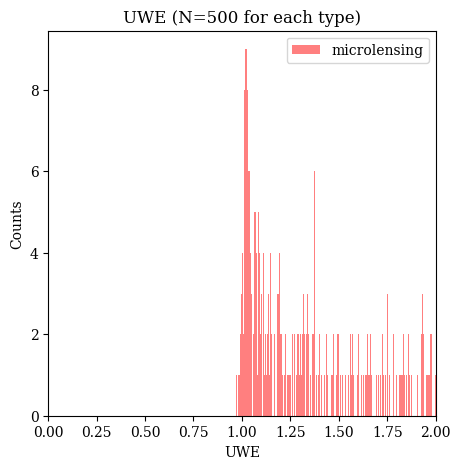

In [50]:
bin_list=np.linspace(0,2,500)
fig = plt.figure(figsize=(5, 5))

#plt.hist(UWE_sing_source,bins=bin_list,color='blue',alpha=0.5,label='single source')
plt.hist(UWE_microlensing,bins=bin_list,color='red',alpha=0.5,label='microlensing')

plt.xlabel('UWE')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.xlim((0.,2))
plt.title('UWE (N='+str(Nsource)+' for each type)')
fig.savefig(figure_dir + 'histogram_UWE_microlensing_only.png', dpi=150, bbox_inches='tight')